In [1]:
import cryptocompare
import datetime
import requests
import pandas as pd
import numpy as np

import urllib.request, json 
from collections import defaultdict

from xgboost import XGBClassifier, plot_importance
from sklearn.ensemble import RandomForestClassifier

import os

from sklearn.feature_selection import f_regression
from sklearn.metrics import explained_variance_score, confusion_matrix, f1_score, classification_report, r2_score, precision_recall_fscore_support

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Dataset Collection

In [3]:
def price_grab(price,base):
    url = "https://min-api.cryptocompare.com/data/histoday?fsym=" + price + "&tsym=" + base + "&limit=2000"
    f = requests.get(url)
    ipdata = f.json()
    df = pd.DataFrame(ipdata['Data'])
    df['time'] = pd.to_datetime(df['time'], unit = 's')
    return df

In [4]:
pairs_list = ['ETH','LTC','XRP','XMR']

prices_df = price_grab('BTC','USD')
prices_df['time'] = pd.to_datetime(prices_df['time'])

prices_df['intraday_range'] = (prices_df['high'] - prices_df['low'])
prices_df['intraday_range_pct'] = prices_df['intraday_range'] / prices_df['open']
prices_df['dod_change'] = (prices_df['close'] - prices_df['open']).div(prices_df['open'])

prices_df['rolling_price_vol_7'] =  prices_df['open'].rolling(7).std() / prices_df['open'].rolling(7).mean()
prices_df['rolling_price_vol_30'] =  prices_df['open'].rolling(30).std() / prices_df['open'].rolling(30).mean()
prices_df['rolling_DoD_vol_7'] =  prices_df['dod_change'].rolling(7).std() / prices_df['dod_change'].rolling(7).mean()
prices_df['rolling_DoD_vol_30'] =  prices_df['dod_change'].rolling(30).std() / prices_df['dod_change'].rolling(30).mean()

for x in pairs_list: 
    print(x)
    df = price_grab('BTC',x)
    df['time'] = pd.to_datetime(df['time'])
    df['intraday_range'] = (df['high'] - df['low'])
    df['intraday_range_pct'] = df['intraday_range'] / df['open']
    
    df['dod_change'] = (df['close'] - df['open']).div(df['open'])
    
    df['rolling_price_vol_7'] =  df['open'].rolling(7).std() / df['open'].rolling(7).mean()
    df['rolling_price_vol_30'] =  df['open'].rolling(30).std() / df['open'].rolling(30).mean()
    df['rolling_DoD_vol_7'] =  df['dod_change'].rolling(7).std() / df['dod_change'].rolling(7).mean()
    df['rolling_DoD_vol_30'] =  df['dod_change'].rolling(30).std() / df['dod_change'].rolling(30).mean()
    
    #df[['high','low']] = df[['high','low']].shift(-1)
    #del df['close']
    prices_df = pd.merge(prices_df, df, on = 'time', suffixes = ['','_' + x])
    
prices_df = prices_df.rename(columns = {'time': 'recorddate'})

ETH
LTC
XRP
XMR


In [5]:
prices_df = prices_df.sort_values('recorddate').reset_index(drop=True)

In [6]:
prices_df['recorddate'] = prices_df['recorddate'] - datetime.timedelta(days=1)

In [7]:
prices_df.tail()

close     high      low     open recorddate  volumefrom      volumeto  intraday_range  intraday_range_pct  dod_change  rolling_price_vol_7  rolling_price_vol_30  rolling_DoD_vol_7  rolling_DoD_vol_30  close_ETH  high_ETH  low_ETH  open_ETH  volumefrom_ETH  volumeto_ETH  intraday_range_ETH  intraday_range_pct_ETH  dod_change_ETH  rolling_price_vol_7_ETH  rolling_price_vol_30_ETH  rolling_DoD_vol_7_ETH  rolling_DoD_vol_30_ETH  close_LTC  high_LTC  low_LTC  open_LTC  volumefrom_LTC  volumeto_LTC  intraday_range_LTC  intraday_range_pct_LTC  dod_change_LTC  rolling_price_vol_7_LTC  rolling_price_vol_30_LTC  rolling_DoD_vol_7_LTC  rolling_DoD_vol_30_LTC  close_XRP  high_XRP   low_XRP  open_XRP  volumefrom_XRP  volumeto_XRP  intraday_range_XRP  intraday_range_pct_XRP  dod_change_XRP  rolling_price_vol_7_XRP  rolling_price_vol_30_XRP  rolling_DoD_vol_7_XRP  rolling_DoD_vol_30_XRP  close_XMR  high_XMR  low_XMR  open_XMR  volumefrom_XMR  volumeto_XMR  intraday_range_XMR  \
1996  5165.59  5186.82  5031.20  5080.66 2019-04-13    21193.03  1.081482e+08          155.62            0.030630    0.016716             0.020843              0.121497         -37.763529            3.740864      30.71     31.14    30.63     30.96        78855.97    2441615.50                0.51                0.016473       -0.008075                 0.022760                  0.025735               2.469782                5.985055      61.61     65.88    61.58     65.02        88601.82    5726553.93                4.30                0.066133       -0.052445                 0.051418                  0.064553               2.683619              -12.820411   15666.61  15772.87  15351.55  15547.26        21144.35  3.296645e+08              421.32                0.027099        0.007677                 0.031583                  0.072733               0.840174                2.504535      77.40     78.80    76.75     77.82         6190.84     482723.11                2.05   
1997  5037.27  5195.31  4969.31  5165.59 2019-04-14    40402.46  2.058670e+08          226.00            0.043751   -0.024841             0.020748              0.121650          -3.808848            4.565655      31.43     32.02    30.63     30.71        94428.43    2940051.46                1.39                0.045262        0.023445                 0.022578                  0.026090               1.076652                4.070497      64.35     66.49    61.12     61.61       112760.84    7132570.74                5.37                0.087161        0.044473                 0.038242                  0.064519               2.711210             -322.091923   15765.41  15966.79  15544.85  15666.61        23207.74  3.660667e+08              421.94                0.026932        0.006306                 0.025330                  0.075083               0.861815                2.527561      78.68     79.18    76.98     77.40         5694.92     442158.97                2.20   
1998  5212.81  5232.03  5029.16  5037.27 2019-04-15    40370.00  2.073115e+08          202.87            0.040274    0.034848             0.019780              0.121040          42.534632            3.912551      31.28     31.50    30.95     31.43        82742.86    2586513.57                0.55                0.017499       -0.004773                 0.021125                  0.027127               1.466442                4.780445      64.47     65.06    63.53     64.35        88605.58    5702854.16                1.53                0.023776        0.001865                 0.034123                  0.064412               3.081127             -150.731298   15966.79  16142.05  15760.44  15765.41        22073.10  3.512505e+08              381.61                0.024206        0.012774                 0.022652                  0.077251               0.805826                2.437051      75.99     79.18    74.40     78.68         4463.30     343859.81                4.78   
1999  5239.78  5270.76  5190.81  5212.81 2019-04-16    36773.48 

In [8]:
charts_list = [
    'total-bitcoins',
    'trade-volume',
    'blocks-size',
    'avg-block-size',
    'n-transactions-per-block',
    'median-confirmation-time',
    'my-wallet-n-users',
    'estimated-transaction-volume',
    'output-volume',
    'n-transactions-excluding-chains-longer-than-100',
    'n-transactions-excluding-popular',
    'utxo-count',
   # 'mempool-size',
    #'mempool-growth',
    #'mempool-count',
   # 'transactions-per-second',
    'n-transactions-total',
    'n-transactions',
    'n-unique-addresses',
    'cost-per-transaction',
    'cost-per-transaction-percent',
    'transaction-fees',
    'miners-revenue',
    'difficulty',
    'hash-rate',
    'median-confirmation-time'
              ]

In [9]:
data_dict = defaultdict(list)
for chart in charts_list:
    print(chart)
    link = 'https://api.blockchain.info/charts/{}?timespan=10years&format=json'.format(chart)
    with urllib.request.urlopen(link) as url:
        data = json.loads(url.read().decode())
    data_dict[chart].append(data['values'])


total-bitcoins
trade-volume
blocks-size
avg-block-size
n-transactions-per-block
median-confirmation-time
my-wallet-n-users
estimated-transaction-volume
output-volume
n-transactions-excluding-chains-longer-than-100
n-transactions-excluding-popular
utxo-count
n-transactions-total
n-transactions
n-unique-addresses
cost-per-transaction
cost-per-transaction-percent
transaction-fees
miners-revenue
difficulty
hash-rate
median-confirmation-time


In [10]:
excels_df = pd.DataFrame({'recorddate' : pd.date_range('2009-01-01', datetime.date.today())})
    
for key in data_dict.keys():
    
    df = pd.DataFrame(data_dict[key][0])
    df['x'] = pd.to_datetime(df['x'], unit = 's')
    df.columns = ['recorddate',key]
    print('{}  {}'.format(key,df['recorddate'].min()))
    
    idx = pd.date_range(df['recorddate'].dt.date.min(), df['recorddate'].dt.date.max())
    df = df.set_index('recorddate')
    df = df.groupby(pd.Grouper(freq='D')).mean()
    df = df.reindex(idx, fill_value=np.nan).fillna(method='ffill')
    
    
    df[key + '_pct_change_1d'] = (df[key] - df[key].shift(1)).div(df[key].shift(1))
    df[key + '_pct_change_7d'] = (df[key] - df[key].shift(7)).div(df[key].shift(7))
    df[key + '_pct_change_30d'] = (df[key] - df[key].shift(30)).div(df[key].shift(30))
    
    df[key + '_rolling_std_7d'] = df[key].rolling(7).std().div(df[key].rolling(7).mean())
    df[key + '_rolling_std_30d'] = df[key].rolling(30).std().div(df[key].rolling(30).mean())
    
    
    df = df.reset_index().rename(columns = {'index' : 'recorddate'})
    
    excels_df = pd.merge(excels_df, df, on = 'recorddate', how = 'outer')

total-bitcoins  2009-04-20 00:00:00
trade-volume  2009-04-20 00:00:00
blocks-size  2009-04-20 00:00:00
avg-block-size  2009-04-20 00:00:00
n-transactions-per-block  2009-04-20 00:00:00
median-confirmation-time  2009-04-20 00:00:00
my-wallet-n-users  2011-11-29 00:00:00
estimated-transaction-volume  2009-04-20 00:00:00
output-volume  2009-04-20 00:00:00
n-transactions-excluding-chains-longer-than-100  2009-04-20 00:00:00
n-transactions-excluding-popular  2009-04-20 00:00:00
utxo-count  2011-09-29 03:00:00
n-transactions-total  2009-04-20 00:00:00
n-transactions  2009-04-20 00:00:00
n-unique-addresses  2009-04-20 00:00:00
cost-per-transaction  2009-04-20 00:00:00
cost-per-transaction-percent  2009-04-20 00:00:00
transaction-fees  2009-04-20 00:00:00
miners-revenue  2009-04-20 00:00:00
difficulty  2009-04-20 00:00:00
hash-rate  2009-04-20 00:00:00


In [11]:
excels_df = excels_df.sort_values('recorddate').reset_index(drop=True)

In [12]:
excels_df.tail()

recorddate  total-bitcoins  total-bitcoins_pct_change_1d  total-bitcoins_pct_change_7d  total-bitcoins_pct_change_30d  total-bitcoins_rolling_std_7d  total-bitcoins_rolling_std_30d  trade-volume  trade-volume_pct_change_1d  trade-volume_pct_change_7d  trade-volume_pct_change_30d  trade-volume_rolling_std_7d  trade-volume_rolling_std_30d    blocks-size  blocks-size_pct_change_1d  blocks-size_pct_change_7d  blocks-size_pct_change_30d  blocks-size_rolling_std_7d  blocks-size_rolling_std_30d  avg-block-size  avg-block-size_pct_change_1d  avg-block-size_pct_change_7d  avg-block-size_pct_change_30d  avg-block-size_rolling_std_7d  avg-block-size_rolling_std_30d  n-transactions-per-block  n-transactions-per-block_pct_change_1d  n-transactions-per-block_pct_change_7d  n-transactions-per-block_pct_change_30d  n-transactions-per-block_rolling_std_7d  n-transactions-per-block_rolling_std_30d  median-confirmation-time  median-confirmation-time_pct_change_1d  \
3754 2019-04-13      17642600.0                      0.000000                      0.000622                       0.003172                       0.000230                        0.000917  1.516413e+08                   -0.637884                   -0.630289                    -0.141042                     0.281253                      0.791342  212348.313182                   0.000000                   0.004984                    0.022511                    0.001847                     0.006503        1.184258                       0.00000                     -0.022640                       0.017771                       0.012667                        0.142780               2495.145695                                0.000000                               -0.035442                                 0.177956                                 0.032192                                  0.165862                 10.500000                                0.000000   
3755 2019-04-14      17645812.5                      0.000182                      0.000804                       0.003135                       0.000226                        0.000919  1.516413e+08                    0.000000                   -0.579862                    -0.141042                     0.392408                      0.795437  212643.760949                   0.001391                   0.006383                    0.022393                    0.001801                     0.006591        1.196266                       0.01014                     -0.012730                       0.211301                       0.012863                        0.141563               2762.540984                                0.107166                                0.067926                                 0.423271                                 0.042978                                  0.165195                 10.983333                                0.046032   
3756 2019-04-15      17645812.5                      0.000000                      0.000599                       0.003135                       0.000224                        0.000908  1.520989e+08                    0.003018                   -0.578594                    -0.499397                     0.485604                      0.814052  212643.760949                   0.000000                   0.004762                    0.022393                    0.001771                     0.006592        1.196266                       0.00000                     -0.018143                       0.211301                       0.011914                        0.140071               2762.540984                                0.000000                                0.097845                                 0.423271                                 0.046407                                  0.163679                 10.983333                                0.000000   
3757 2019-04-16      17649437.5                      0.000205                      0.000804                       0.003121               

In [13]:
t = 2
t = -t - 1

master_df = pd.merge(prices_df, excels_df, on = ['recorddate'], how = 'outer').sort_values('recorddate')
master_df = master_df.set_index('recorddate')

t_list = []
for col in master_df.columns:
    if float(master_df.loc[master_df.index == list(excels_df['recorddate'])[t+1 ], col].isna()) == 0: 
        t_list.append(col)
master_df = master_df[t_list]

# Labeling

In [14]:
master_df = master_df.drop(columns = [s for s in master_df.columns if "close" in s])
master_df[[s for s in master_df.columns if s in ('high','low','intraday_range','volumefrom','volumeto')]] = master_df[[s for s in master_df.columns if s in  ('high','low','intraday_range','volumefrom','volumeto')]].shift(-1)
master_df[[s for s in master_df.columns if s in ('dod_change')]] = master_df[[s for s in master_df.columns if s in  ('dod_change')]].shift(1)

master_df['pred_dod_change'] = master_df['dod_change'].shift(t) 

master_df = master_df.dropna()
master_df=master_df.replace([np.inf,-np.inf],0).fillna(0)

In [16]:
list(master_df.columns)

['high',
 'low',
 'open',
 'volumefrom',
 'volumeto',
 'intraday_range',
 'intraday_range_pct',
 'dod_change',
 'rolling_price_vol_7',
 'rolling_price_vol_30',
 'rolling_DoD_vol_7',
 'rolling_DoD_vol_30',
 'high_ETH',
 'low_ETH',
 'open_ETH',
 'volumefrom_ETH',
 'volumeto_ETH',
 'intraday_range_ETH',
 'intraday_range_pct_ETH',
 'dod_change_ETH',
 'rolling_price_vol_7_ETH',
 'rolling_price_vol_30_ETH',
 'rolling_DoD_vol_7_ETH',
 'rolling_DoD_vol_30_ETH',
 'high_LTC',
 'low_LTC',
 'open_LTC',
 'volumefrom_LTC',
 'volumeto_LTC',
 'intraday_range_LTC',
 'intraday_range_pct_LTC',
 'dod_change_LTC',
 'rolling_price_vol_7_LTC',
 'rolling_price_vol_30_LTC',
 'rolling_DoD_vol_7_LTC',
 'rolling_DoD_vol_30_LTC',
 'high_XRP',
 'low_XRP',
 'open_XRP',
 'volumefrom_XRP',
 'volumeto_XRP',
 'intraday_range_XRP',
 'intraday_range_pct_XRP',
 'dod_change_XRP',
 'rolling_price_vol_7_XRP',
 'rolling_price_vol_30_XRP',
 'rolling_DoD_vol_7_XRP',
 'rolling_DoD_vol_30_XRP',
 'high_XMR',
 'low_XMR',
 'open_XMR'

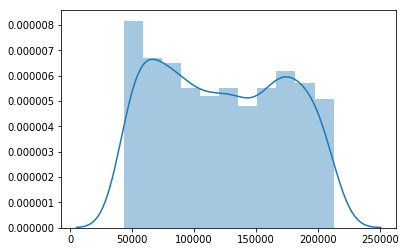

In [41]:
sns.distplot(master_df[['blocks-size']])

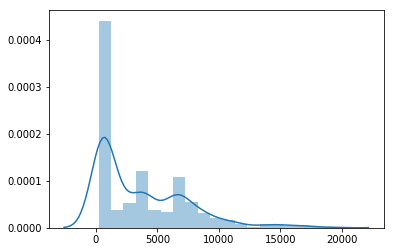

In [42]:
sns.distplot(master_df[['open']])

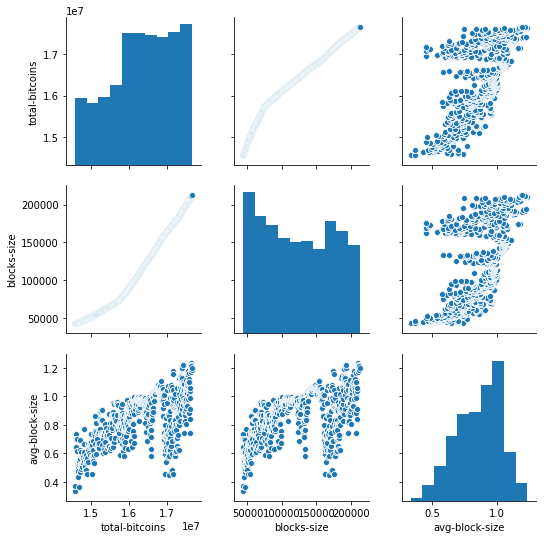

In [34]:
sns.pairplot(master_df[['total-bitcoins',
                       'blocks-size',
                       'avg-block-size']].dropna())

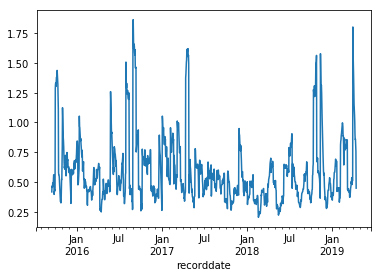

In [22]:
(master_df['intraday_range'].rolling(14).std() / master_df['intraday_range'].rolling(14).mean()).plot()

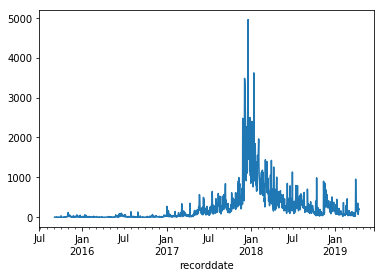

In [21]:
master_df['intraday_range'].plot()

In [61]:
master_df.dropna().head(10)[['high','low','open','dod_change','pred_dod_change']]

high     low    open  dod_change  pred_dod_change
recorddate                                                     
2015-09-04  243.64  234.74  230.25    0.017905        -0.001167
2015-09-05  242.66  237.49  233.67    0.014853         0.015277
2015-09-06  246.38  239.23  239.86    0.026490        -0.023968
2015-09-07  244.34  236.49  239.58   -0.001167         0.002822
2015-09-08  240.63  234.31  243.24    0.015277         0.007644
2015-09-09  241.02  237.38  237.41   -0.023968        -0.017924
2015-09-10  240.32  233.32  238.08    0.002822        -0.022963
2015-09-11  236.16  228.28  239.90    0.007644        -0.001216
2015-09-12  232.64  225.96  235.60   -0.017924        -0.001653
2015-09-13  242.83  228.03  230.19   -0.022963        -0.004052

In [62]:
master_df.tail(10)[['high','low','open','dod_change','pred_dod_change']]

high      low     open  dod_change  pred_dod_change
recorddate                                                        
2019-04-01  5335.70  4831.59  4151.32    0.009393        -0.012705
2019-04-02  5071.98  4799.77  4906.93    0.182017         0.027246
2019-04-03  5074.13  4897.61  4976.59    0.014196         0.001985
2019-04-04  5240.19  4938.00  4913.36   -0.012705         0.028456
2019-04-05  5266.04  5044.28  5047.23    0.027246         0.017867
2019-04-06  5347.88  5141.23  5057.25    0.001985        -0.017527
2019-04-07  5294.09  5159.13  5201.16    0.028456         0.022552
2019-04-08  5460.94  5178.61  5294.09    0.017867        -0.050773
2019-04-09  5343.66  4987.65  5201.30   -0.017527         0.006525
2019-04-10  5118.61  4927.62  5318.60    0.022552         0.000588

In [43]:
bins = [-np.inf,-0.01,0.01,np.inf]
buckets = ['-1','0','1']

master_df['label'] = pd.cut(master_df['pred_dod_change'], bins = bins, labels = buckets).astype(float)
#master_df['label'] = np.where(master_df['pred_dod_change'] > 0.01, 1, 0)

drop_list = ['pred_dod_change','label','dod_change']
X = master_df.drop(columns = drop_list)
y = master_df['label']

X = X.astype(float)
split_cutoff_date = '2018-06-01'

X_train, X_test = X.loc[(X.index < split_cutoff_date)], X.loc[(X.index >= split_cutoff_date) ]
y_train, y_test = y.loc[ (y.index < split_cutoff_date)], y.loc[(y.index >= split_cutoff_date) ]


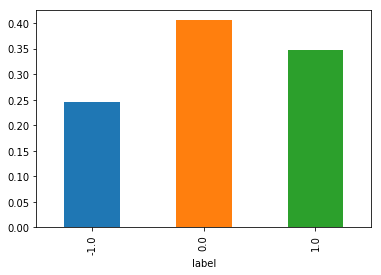

In [45]:
(master_df.groupby('label').size() / len(master_df)).plot(kind='bar')

In [561]:
master_df.loc[(master_df.index < split_cutoff_date)].groupby('label').size()

label
0    631
1    370
dtype: int64

In [562]:
631/370

1.7054054054054053

In [563]:
master_df.loc[(master_df.index >= split_cutoff_date)].groupby('label').size()

label
0    223
1     85
dtype: int64

# Model Building/Tuning

In [146]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

rf_model_opt = RandomForestClassifier(
                                      max_depth = 24, min_samples_split = 7, min_samples_leaf = 0.1)
rf_model_opt.fit(X_train, y_train)

model_clss = XGBClassifier()
model_clss.fit(X_train, y_train)
model_clss_opt = XGBClassifier(max_depth = 6, min_child_weight = 3, gamma = 0, colsample_bytree =0.9, learning_rate = 0.3)
model_clss_opt.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=6, min_child_weight=3, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [147]:
y_pred_clss = model_clss.predict(X_test)
y_pred_clss_opt = model_clss_opt.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_rf_opt = rf_model_opt.predict(X_test)

In [148]:
print(classification_report(y_test,y_pred_rf))
print('Hyperparam optimized: \n')
print(classification_report(y_test,y_pred_rf_opt))

              precision    recall  f1-score   support

        -1.0       0.23      0.25      0.24        83
         0.0       0.45      0.10      0.16       144
         1.0       0.27      0.60      0.37        87

   micro avg       0.28      0.28      0.28       314
   macro avg       0.32      0.32      0.26       314
weighted avg       0.34      0.28      0.24       314

Hyperparam optimized: 

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00        83
         0.0       0.59      0.09      0.16       144
         1.0       0.29      0.97      0.44        87

   micro avg       0.31      0.31      0.31       314
   macro avg       0.29      0.35      0.20       314
weighted avg       0.35      0.31      0.19       314



In [149]:
print(classification_report(y_test,y_pred_clss))
print('Hyperparam optimized: \n')
print(classification_report(y_test,y_pred_clss_opt))

              precision    recall  f1-score   support

        -1.0       0.27      0.05      0.08        83
         0.0       0.65      0.24      0.35       144
         1.0       0.29      0.82      0.43        87

   micro avg       0.35      0.35      0.35       314
   macro avg       0.40      0.37      0.29       314
weighted avg       0.45      0.35      0.30       314

Hyperparam optimized: 

              precision    recall  f1-score   support

        -1.0       0.23      0.07      0.11        83
         0.0       0.57      0.32      0.41       144
         1.0       0.29      0.70      0.41        87

   micro avg       0.36      0.36      0.36       314
   macro avg       0.37      0.36      0.31       314
weighted avg       0.41      0.36      0.33       314



In [79]:
from sklearn.model_selection import GridSearchCV
import warnings; warnings.simplefilter('ignore')

In [80]:
from sklearn.model_selection import TimeSeriesSplit
cv=TimeSeriesSplit(n_splits = 3)

In [81]:
def gs_output(gsearch):
    return pd.DataFrame(gsearch.cv_results_['params'],gsearch.cv_results_['mean_test_score']).reset_index().sort_values('index', ascending = False)

In [82]:
from sklearn.metrics import make_scorer
def precision_up(y_true, y_pred):
    fscore_list = precision_recall_fscore_support(y_true,y_pred)[2]
    precision_list = precision_recall_fscore_support(y_true,y_pred)[0]
    if np.where(fscore_list==0)[0].size > 0:
        output = 0
    else:
        output = precision_list[1]
    return output
    

scorer = make_scorer(precision_up, greater_is_better=True)

In [578]:
X.columns.tolist()

['high',
 'low',
 'open',
 'volumefrom',
 'volumeto',
 'intraday_range',
 'intraday_range_pct',
 'rolling_price_vol_7',
 'rolling_price_vol_30',
 'rolling_DoD_vol_7',
 'rolling_DoD_vol_30',
 'high_ETH',
 'low_ETH',
 'open_ETH',
 'volumefrom_ETH',
 'volumeto_ETH',
 'intraday_range_ETH',
 'intraday_range_pct_ETH',
 'dod_change_ETH',
 'rolling_price_vol_7_ETH',
 'rolling_price_vol_30_ETH',
 'rolling_DoD_vol_7_ETH',
 'rolling_DoD_vol_30_ETH',
 'high_LTC',
 'low_LTC',
 'open_LTC',
 'volumefrom_LTC',
 'volumeto_LTC',
 'intraday_range_LTC',
 'intraday_range_pct_LTC',
 'dod_change_LTC',
 'rolling_price_vol_7_LTC',
 'rolling_price_vol_30_LTC',
 'rolling_DoD_vol_7_LTC',
 'rolling_DoD_vol_30_LTC',
 'high_XRP',
 'low_XRP',
 'open_XRP',
 'volumefrom_XRP',
 'volumeto_XRP',
 'intraday_range_XRP',
 'intraday_range_pct_XRP',
 'dod_change_XRP',
 'rolling_price_vol_7_XRP',
 'rolling_price_vol_30_XRP',
 'rolling_DoD_vol_7_XRP',
 'rolling_DoD_vol_30_XRP',
 'high_XMR',
 'low_XMR',
 'open_XMR',
 'volumefrom_

In [83]:
param_test1 = {
 'max_depth':np.linspace(1, 50, 50, endpoint=True),
    'min_samples_split': range(2,15),
    'min_samples_leaf': np.linspace(0.1, 0.5, 9, endpoint=True)
}


gsearch1 = GridSearchCV(estimator = RandomForestClassifier( ), scoring = scorer,
 param_grid = param_test1, n_jobs=-1,iid=False, cv=cv)
gsearch1.fit(X_train, y_train)
print(gsearch1.best_params_, gsearch1.best_score_)
gs_output(gsearch1)

{'max_depth': 24.0, 'min_samples_leaf': 0.1, 'min_samples_split': 7} 0.20757575757575755


index  max_depth  min_samples_leaf  min_samples_split
2696  0.207576       24.0              0.10                  7
1177  0.205797       11.0              0.10                  9
2108  0.203704       19.0              0.10                  4
244   0.202532        3.0              0.10                 12
4453  0.201717       39.0              0.10                  9
1405  0.201102       13.0              0.10                  3
2937  0.200000       26.0              0.10                 14
4217  0.199454       37.0              0.10                  7
944   0.198903        9.0              0.10                 10
596   0.196970        6.0              0.10                 13
3044  0.127726       27.0              0.10                  4
3905  0.000000       34.0              0.25                  7
3906  0.000000       34.0              0.25                  8
3904  0.000000       34.0              0.25                  6
3903  0.000000       34.0              0.25                  5
3902  0.000000       34.0              0.25                  4
0     0.000000        1.0              0.10                  2
3900  0.000000       34.0              0.25                  2
3901  0.000000       34.0              0.25                  3
3908  0.000000       34.0              0.25                 10
3899  0.000000       34.0              0.20                 14
3898  0.000000       34.0              0.20                 13
3897  0.000000       34.0              0.20                 12
3896  0.000000       34.0              0.20                 11
3895  0.000000       34.0              0.20                 10
3894  0.000000       34.0              0.20                  9
3893  0.000000       34.0              0.20                  8
3907  0.000000       34.0              0.25                  9
3911  0.000000       34.0              0.25                 13
3909  0.000000       34.0              0.25                 11
3910  0.000000       34.0              0.25                 12
3929  0.000000       34.0              0.35                  5
3928  0.000000       34.0              0.35                  4
3927  0.000000       34.0              0.35                  3
3926  0.000000       34.0              0.35                  2
3925  0.000000       34.0              0.30                 14
3924  0.000000       34.0              0.30                 13
3923  0.000000       34.0              0.30                 12
3922  0.000000       34.0              0.30                 11
3921  0.000000       34.0              0.30                 10
3920  0.000000       34.0              0.30                  9
3919  0.000000       34.0              0.30                  8
3918  0.000000       34.0              0.30                  7
3917  0.000000       34.0              0.30                  6
3916  0.000000       34.0              0.30                  5
3915  0.000000       34.0              0.30                  4
3914  0.000000       34.0              0.30                  3
3913  0.000000       34.0              0.30                  2
3912  0.000000       34.0              0.25                 14
3891  0.000000       34.0              0.20                  6
3892  0.000000       34.0              0.20                  7
3888  0.000000       34.0              0.20                  3
3890  0.000000       34.0              0.20                  5
3867  0.000000       34.0              0.10                  8
3865  0.000000       34.0              0.10                  6
3864  0.000000       34.0              0.10                  5
3863  0.000000       34.0              0.10                  4
3862  0.000000       34.0              0.10                  3
3861  0.000000       34.0              0.10                  2
3860  0.000000       33.0              0.50                 14
3859  0.000000       33.0              0.50                 13
3858  0.000000       33.0              0.50                 12
3857  0.000000       33.0              0

In [87]:
param_test1 = {
 'max_depth': [4,5,6,7,8,9],
    'min_child_weight': [1,2,3,4,5,6,7]
}

gsearch1 = GridSearchCV(estimator = XGBClassifier(), scoring = scorer,
 param_grid = param_test1, n_jobs=-1,iid=False, cv = cv)
gsearch1.fit(X_train, y_train)
print(gsearch1.best_params_, gsearch1.best_score_)
gs_output(gsearch1)

{'max_depth': 6, 'min_child_weight': 3} 0.4182630906768838


index  max_depth  min_child_weight
16  0.418263          6                 3
37  0.416439          9                 3
27  0.416125          7                 7
5   0.414997          4                 6
26  0.407711          7                 6
28  0.406858          8                 1
13  0.404152          5                 7
41  0.400541          9                 7
8   0.398408          5                 2
6   0.397421          4                 7
15  0.397358          6                 2
3   0.396794          4                 4
36  0.395761          9                 2
30  0.395300          8                 3
18  0.390733          6                 5
22  0.390450          7                 2
19  0.389686          6                 6
24  0.389373          7                 4
4   0.386196          4                 5
9   0.384991          5                 3
38  0.383865          9                 4
34  0.383100          8                 7
0   0.377802          4                 1
10  0.376726          5                 4
25  0.375734          7                 5
11  0.374936          5                 5
29  0.373670          8                 2
17  0.372962          6                 4
33  0.372798          8                 6
35  0.369636          9                 1
31  0.361835          8                 4
12  0.358915          5                 6
40  0.219170          9                 6
23  0.217043          7                 3
2   0.209598          4                 3
14  0.204104          6                 1
39  0.202154          9                 5
32  0.201496          8                 5
20  0.199609          6                 7
21  0.195532          7                 1
1   0.188552          4                 2
7   0.159929          5                 1

In [88]:
param_test2 = {
 'max_depth': [3,4,5,6,7,8],
    'min_child_weight': [1,2,3,4,5]
}

gsearch2 = GridSearchCV(estimator = XGBClassifier(), scoring = scorer,
 param_grid = param_test2, n_jobs=-1,iid=False, cv = cv)
gsearch2.fit(X_train, y_train)
print(gsearch2.best_params_, gsearch2.best_score_)
gs_output(gsearch2)

{'max_depth': 6, 'min_child_weight': 3} 0.4182630906768838


index  max_depth  min_child_weight
17  0.418263          6                 3
25  0.406858          8                 1
2   0.398421          3                 3
11  0.398408          5                 2
16  0.397358          6                 2
8   0.396794          4                 4
27  0.395300          8                 3
4   0.392044          3                 5
19  0.390733          6                 5
21  0.390450          7                 2
23  0.389373          7                 4
9   0.386196          4                 5
12  0.384991          5                 3
5   0.377802          4                 1
13  0.376726          5                 4
24  0.375734          7                 5
14  0.374936          5                 5
26  0.373670          8                 2
18  0.372962          6                 4
28  0.361835          8                 4
22  0.217043          7                 3
7   0.209598          4                 3
15  0.204104          6                 1
29  0.201496          8                 5
3   0.197421          3                 4
20  0.195532          7                 1
0   0.192496          3                 1
6   0.188552          4                 2
1   0.185435          3                 2
10  0.159929          5                 1

In [89]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,8)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier(max_depth = 6, min_child_weight = 3), scoring = scorer,
 param_grid = param_test3, n_jobs=-1,iid=False, cv = cv)
gsearch3.fit(X_train, y_train)
print(gsearch3.best_params_, gsearch3.best_score_)
gs_output(gsearch3)

{'gamma': 0.0} 0.4182630906768838


index  gamma
0  0.418263    0.0
6  0.390450    0.6
1  0.389954    0.1
4  0.388518    0.4
3  0.388353    0.3
5  0.380812    0.5
2  0.373808    0.2
7  0.176347    0.7

In [94]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,11)],
 'colsample_bytree':[i/10.0 for i in range(6,11)],
    'gamma' : [0,0.1,0.6]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier(max_depth = 6, min_child_weight = 3), 
 param_grid = param_test4, scoring=scorer,n_jobs=-1,iid=False, cv=cv)
gsearch4.fit(X_train, y_train)
print(gsearch4.best_params_, gsearch4.best_score_)
gs_output(gsearch4)

{'colsample_bytree': 0.8, 'gamma': 0.1, 'subsample': 0.7} 0.44549689440993784


index  colsample_bytree  gamma  subsample
36  0.445497               0.8    0.1        0.7
52  0.424258               0.9    0.1        0.8
40  0.421481               0.8    0.6        0.6
17  0.418802               0.7    0.0        0.8
64  0.418263               1.0    0.0        1.0
49  0.415300               0.9    0.0        1.0
27  0.408912               0.7    0.6        0.8
8   0.408417               0.6    0.1        0.9
35  0.406667               0.8    0.1        0.6
15  0.404791               0.7    0.0        0.6
72  0.404532               1.0    0.6        0.8
63  0.403266               1.0    0.0        0.9
58  0.401856               0.9    0.6        0.9
33  0.400558               0.8    0.0        0.9
60  0.399546               1.0    0.0        0.6
53  0.398908               0.9    0.1        0.9
55  0.397383               0.9    0.6        0.6
42  0.397237               0.8    0.6        0.8
21  0.396508               0.7    0.1        0.7
32  0.396194               0.8    0.0        0.8
1   0.395270               0.6    0.0        0.7
65  0.395184               1.0    0.1        0.6
68  0.392489               1.0    0.1        0.9
57  0.391256               0.9    0.6        0.8
31  0.391103               0.8    0.0        0.7
70  0.390662               1.0    0.6        0.6
74  0.390450               1.0    0.6        1.0
69  0.389954               1.0    0.1        1.0
16  0.389298               0.7    0.0        0.7
41  0.389021               0.8    0.6        0.7
24  0.388597               0.7    0.1        1.0
51  0.388499               0.9    0.1        0.7
2   0.385300               0.6    0.0        0.8
48  0.385181               0.9    0.0        0.9
37  0.384956               0.8    0.1        0.8
22  0.384885               0.7    0.1        0.8
3   0.384248               0.6    0.0        0.9
29  0.383665               0.7    0.6        1.0
26  0.383609               0.7    0.6        0.7
39  0.382639               0.8    0.1        1.0
73  0.382424               1.0    0.6        0.9
47  0.379458               0.9    0.0        0.8
10  0.378820               0.6    0.6        0.6
62  0.375185               1.0    0.0        0.8
23  0.374603               0.7    0.1        0.9
54  0.370307               0.9    0.1        1.0
43  0.369614               0.8    0.6        0.9
18  0.367582               0.7    0.0        0.9
38  0.366464               0.8    0.1        0.9
0   0.364678               0.6    0.0        0.6
20  0.364374               0.7    0.1        0.6
28  0.361516               0.7    0.6        0.9
6   0.360644               0.6    0.1        0.7
7   0.360434               0.6    0.1        0.8
12  0.359169               0.6    0.6        0.8
67  0.358862               1.0    0.1        0.8
45  0.351751               0.9    0.0        0.6
50  0.338284               0.9    0.1        0.6
44  0.245573               0.8    0.6        1.0
56  0.213415               0.9    0.6        0.7
9   0.200758               0.6    0.1        1.0
59  0.199640               0.9    0.6        1.0
4   0.198718               0.6    0.0        1.0
66  0.197343               1.0    0.1        0.7
46  0.185185               0.9    0.0        0.7
30  0.181704               0.8    0.0        0.6
14  0.181609               0.6    0.6        1.0
19  0.181277               0.7    0.0        1.0
25  0.179194               0.7    0.6        0.6
71  0.178732               1.0    0.6        0.7
5   0.176695               0.6    0.1        0.6
34  0.172577               0.8    0.0        1.0
61  0.168295               1.0    0.0        0.7
11  0.151072               0.6    0.6        0.7
13  0.143670               0.6    0.6        0.9

In [106]:
param_test5 = {
 'reg_alpha':[0, 1e-7, 1e-5, 1e-3, 1e-2, 0.1, 0.5, 0.9, 1, 1.1,1.5,20, 100]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier(max_depth = 6, min_child_weight = 3, gamma = 0,
                                                 colsample_bytree = 0.9, substample = 1), 
 param_grid = param_test5, scoring=scorer,n_jobs=-1,iid=False, cv=cv)
gsearch5.fit(X_train, y_train)
print(gsearch5.best_params_, gsearch5.best_score_)
gs_output(gsearch5)

{'reg_alpha': 0} 0.4153003305545679


index     reg_alpha
0   0.415300  0.000000e+00
1   0.415300  1.000000e-07
2   0.415300  1.000000e-05
10  0.411669  1.500000e+00
4   0.410923  1.000000e-02
6   0.397201  5.000000e-01
5   0.394286  1.000000e-01
3   0.394177  1.000000e-03
9   0.389454  1.100000e+00
8   0.389444  1.000000e+00
7   0.388069  9.000000e-01
11  0.037037  2.000000e+01
12  0.000000  1.000000e+02

In [107]:
param_test7 = {
 'learning_rate':[0.001,0.01,0.1,0.17,0.2,0.3,0.7,0.8,0.9,1],
    'reg_alpha' : [0,1e-7,1e-5,0.001]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier(max_depth = 6, min_child_weight = 3, gamma = 0,
                                                 colsample_bytree = 1, substample = 1), 
 param_grid = param_test7, scoring= scorer,n_jobs=-1,iid=False, cv=cv)
gsearch7.fit(X_train, y_train)
print(gsearch7.best_params_, gsearch7.best_score_)
gs_output(gsearch7)

{'learning_rate': 0.3, 'reg_alpha': 0} 0.4214135386218001


index  learning_rate     reg_alpha
20  0.421414          0.300  0.000000e+00
21  0.421414          0.300  1.000000e-07
8   0.418263          0.100  0.000000e+00
9   0.418263          0.100  1.000000e-07
15  0.406871          0.170  1.000000e-03
22  0.405455          0.300  1.000000e-05
1   0.404962          0.001  1.000000e-07
0   0.404962          0.001  0.000000e+00
2   0.404962          0.001  1.000000e-05
3   0.401885          0.001  1.000000e-03
35  0.400182          0.900  1.000000e-03
34  0.399932          0.900  1.000000e-05
33  0.399932          0.900  1.000000e-07
32  0.399932          0.900  0.000000e+00
19  0.392556          0.200  1.000000e-03
23  0.391298          0.300  1.000000e-03
24  0.391069          0.700  0.000000e+00
26  0.391069          0.700  1.000000e-05
25  0.391069          0.700  1.000000e-07
39  0.386345          1.000  1.000000e-03
30  0.386120          0.800  1.000000e-05
11  0.386036          0.100  1.000000e-03
28  0.384003          0.800  0.000000e+00
29  0.384003          0.800  1.000000e-07
17  0.379135          0.200  1.000000e-07
16  0.379135          0.200  0.000000e+00
18  0.379135          0.200  1.000000e-05
10  0.372786          0.100  1.000000e-05
14  0.368885          0.170  1.000000e-05
13  0.368885          0.170  1.000000e-07
12  0.368885          0.170  0.000000e+00
27  0.216898          0.700  1.000000e-03
31  0.200701          0.800  1.000000e-03
36  0.188910          1.000  0.000000e+00
38  0.188910          1.000  1.000000e-05
37  0.188910          1.000  1.000000e-07
7   0.178039          0.010  1.000000e-03
5   0.176471          0.010  1.000000e-07
6   0.176471          0.010  1.000000e-05
4   0.176471          0.010  0.000000e+00

In [108]:
pd.DataFrame(rf_model_opt.feature_importances_, index=X.columns, 
                          columns=["Importance"]).sort_values('Importance', ascending = False)

Importance
intraday_range_pct                                    0.152674
intraday_range                                        0.147201
volumeto                                              0.112908
volumefrom                                            0.109232
trade-volume                                          0.079561
rolling_price_vol_30                                  0.066218
open_ETH                                              0.061609
volumeto_LTC                                          0.056223
high_XRP                                              0.030406
trade-volume_rolling_std_30d                          0.022910
high_ETH                                              0.020867
high                                                  0.015486
high_LTC                                              0.014305
utxo-count_rolling_std_7d                             0.014154
low_LTC                                               0.013672
rolling_price_vol_30_LTC                              0.012890
low_XRP                                               0.012806
utxo-count                                            0.011354
rolling_DoD_vol_30                                    0.010434
dod_change_ETH                                        0.010207
utxo-count_pct_change_30d                             0.010005
low                                                   0.008156
intraday_range_pct_ETH                                0.006720
rolling_DoD_vol_30_XMR                                0.000000
rolling_DoD_vol_7_XMR                                 0.000000
intraday_range_XMR                                    0.000000
trade-volume_pct_change_1d                            0.000000
rolling_price_vol_30_XMR                              0.000000
trade-volume_pct_change_7d                            0.000000
trade-volume_pct_change_30d                           0.000000
trade-volume_rolling_std_7d                           0.000000
rolling_price_vol_7_XMR                               0.000000
dod_change_XMR                                        0.000000
intraday_range_pct_XMR                                0.000000
my-wallet-n-users_rolling_std_30d                     0.000000
my-wallet-n-users                                     0.000000
my-wallet-n-users_pct_change_1d                       0.000000
my-wallet-n-users_pct_change_7d                       0.000000
my-wallet-n-users_pct_change_30d                      0.000000
my-wallet-n-users_rolling_std_7d                      0.000000
volumefrom_XMR                                        0.000000
n-transactions-excluding-chains-longer-than-100       0.000000
n-transactions-excluding-chains-longer-than-100...    0.000000
n-transactions-excluding-chains-longer-than-100...    0.000000
n-transactions-excluding-chains-longer-than-100...    0.000000
n-transactions-excluding-chains-longer-than-100...    0.000000
n-transactions-excluding-chains-longer-than-100...    0.000000
utxo-count_pct_change_1d                              0.000000
utxo-count_pct_change_7d                              0.000000
volumeto_XMR                                          0.000000
intraday_range_pct_XRP                                0.000000
open_XMR                                              0.000000
low_XMR                                               0.000000
open                                                  0.000000
rolling_price_vol_7                                   0.000000
rolling_DoD_vol_7                                     0.000000
low_ETH                                               0.000000
volumefrom_ETH                                        0.000000
volumeto_ETH                                          0.000000
intraday_range_ETH                                    0.000000
rolling_price_vol_7_ETH                               0.000000
rolling_price_vol_30_ETH                              0.000000
rolling_DoD_vol_7_ETH                                 0.000000
rolling_DoD_vol_30_E

In [151]:
pd.DataFrame(rf_model.feature_importances_, index=X.columns, 
                          columns=["Importance"]).sort_values('Importance', ascending = False)

Importance
volumeto                                              0.052414
intraday_range_pct                                    0.032465
dod_change_XRP                                        0.026084
volumeto_LTC                                          0.023968
low                                                   0.019485
rolling_price_vol_30                                  0.018904
rolling_DoD_vol_7                                     0.017263
intraday_range                                        0.017006
intraday_range_pct_XRP                                0.016469
n-transactions-excluding-chains-longer-than-100...    0.016358
volumefrom_ETH                                        0.016146
dod_change_XMR                                        0.016040
n-transactions-excluding-chains-longer-than-100...    0.015396
rolling_DoD_vol_7_XMR                                 0.014890
rolling_DoD_vol_7_ETH                                 0.014888
rolling_DoD_vol_7_XRP                                 0.014872
trade-volume_pct_change_30d                           0.014562
rolling_price_vol_7_XRP                               0.014456
rolling_price_vol_7_XMR                               0.014064
intraday_range_ETH                                    0.013952
intraday_range_XRP                                    0.013895
dod_change_LTC                                        0.013816
utxo-count_rolling_std_30d                            0.013579
rolling_price_vol_30_LTC                              0.013449
intraday_range_pct_ETH                                0.013065
rolling_price_vol_7_LTC                               0.012966
dod_change_ETH                                        0.012697
rolling_price_vol_7_ETH                               0.012564
open                                                  0.012353
rolling_DoD_vol_30_XRP                                0.011936
n-transactions-excluding-chains-longer-than-100...    0.011415
volumeto_XMR                                          0.011412
trade-volume_pct_change_7d                            0.011407
rolling_DoD_vol_7_LTC                                 0.011388
my-wallet-n-users_rolling_std_7d                      0.011189
utxo-count_rolling_std_7d                             0.011112
intraday_range_LTC                                    0.011075
rolling_DoD_vol_30                                    0.010932
intraday_range_pct_XMR                                0.010815
rolling_price_vol_30_XRP                              0.010741
volumefrom_XRP                                        0.010568
utxo-count_pct_change_1d                              0.010567
volumeto_ETH                                          0.010368
volumeto_XRP                                          0.010338
high_XMR                                              0.010205
rolling_price_vol_7                                   0.010188
utxo-count_pct_change_7d                              0.010184
intraday_range_XMR                                    0.010147
rolling_DoD_vol_30_XMR                                0.010129
volumefrom                                            0.010067
rolling_price_vol_30_ETH                              0.009874
trade-volume_pct_change_1d                            0.009820
trade-volume_rolling_std_30d                          0.009775
volumefrom_LTC                                        0.009699
rolling_price_vol_30_XMR                              0.009543
utxo-count_pct_change_30d                             0.009176
high_LTC                                              0.009153
low_LTC                                               0.009045
low_XRP                                               0.009010
volumefrom_XMR                                        0.008836
utxo-count                                            0.008758
trade-volume_rolling_std_7d                           0.008735
high_ETH                                              0.008709
open_ETH            

In [109]:
pd.DataFrame(model_clss_opt.feature_importances_, index=X.columns, 
                          columns=["Importance"]).sort_values('Importance', ascending = False)

Importance
dod_change_XRP                                        0.029288
intraday_range_pct                                    0.024757
trade-volume_pct_change_7d                            0.024110
rolling_DoD_vol_7                                     0.022330
dod_change_LTC                                        0.021521
dod_change_ETH                                        0.021521
rolling_DoD_vol_7_XRP                                 0.021521
rolling_DoD_vol_30_ETH                                0.021521
rolling_price_vol_7_XMR                               0.020712
n-transactions-excluding-chains-longer-than-100...    0.020712
n-transactions-excluding-chains-longer-than-100...    0.020227
intraday_range_pct_XRP                                0.020065
volumefrom_ETH                                        0.019256
volumefrom                                            0.018932
rolling_price_vol_30                                  0.018447
dod_change_XMR                                        0.018123
rolling_price_vol_7                                   0.018123
rolling_DoD_vol_30_LTC                                0.017638
intraday_range_ETH                                    0.017638
rolling_DoD_vol_30                                    0.017314
volumeto_XRP                                          0.017152
rolling_DoD_vol_30_XRP                                0.017152
n-transactions-excluding-chains-longer-than-100...    0.016990
rolling_DoD_vol_7_XMR                                 0.016505
rolling_DoD_vol_7_ETH                                 0.016019
rolling_DoD_vol_7_LTC                                 0.016019
intraday_range                                        0.016019
rolling_price_vol_7_XRP                               0.015696
trade-volume_rolling_std_30d                          0.015372
rolling_price_vol_7_ETH                               0.013430
intraday_range_pct_ETH                                0.013269
trade-volume_pct_change_1d                            0.013269
rolling_DoD_vol_30_XMR                                0.013107
intraday_range_pct_XMR                                0.012621
volumeto_ETH                                          0.012298
n-transactions-excluding-chains-longer-than-100...    0.012298
volumefrom_XMR                                        0.012136
rolling_price_vol_7_LTC                               0.011974
n-transactions-excluding-chains-longer-than-100...    0.011812
volumefrom_LTC                                        0.011812
utxo-count_pct_change_7d                              0.011650
volumeto_LTC                                          0.011327
volumeto_XMR                                          0.011327
intraday_range_XRP                                    0.011003
trade-volume_rolling_std_7d                           0.010841
volumeto                                              0.010518
utxo-count_rolling_std_7d                             0.010356
rolling_price_vol_30_XMR                              0.010194
intraday_range_pct_LTC                                0.009871
my-wallet-n-users_pct_change_7d                       0.009709
intraday_range_LTC                                    0.009385
utxo-count_pct_change_30d                             0.008900
trade-volume                                          0.008738
volumefrom_XRP                                        0.008738
high_LTC                                              0.008738
rolling_price_vol_30_LTC                              0.008414
my-wallet-n-users_rolling_std_7d                      0.008414
intraday_range_XMR                                    0.008252
trade-volume_pct_change_30d                           0.008252
rolling_price_vol_30_XRP                              0.007605
utxo-count_rolling_std_30d                            0.007443
my-wallet-n-users_rolling_std_30d                     0.007282
n-transactions-excluding-chains-longer-than-100       0.007282
low_XMR             

In [114]:
pd.DataFrame(model_clss.feature_importances_, index=X.columns, 
                          columns=["Importance"]).sort_values('Importance', ascending = False)

Importance
intraday_range_pct                                    0.037806
dod_change_XRP                                        0.034079
rolling_DoD_vol_30                                    0.026624
n-transactions-excluding-chains-longer-than-100...    0.025559
rolling_DoD_vol_7                                     0.025027
rolling_DoD_vol_30_ETH                                0.025027
intraday_range_pct_XRP                                0.023429
trade-volume_pct_change_7d                            0.022364
volumefrom_ETH                                        0.022364
dod_change_XMR                                        0.021299
dod_change_LTC                                        0.020767
volumeto_XRP                                          0.020234
volumefrom                                            0.020234
volumeto_ETH                                          0.020234
volumeto                                              0.019169
intraday_range_ETH                                    0.018637
rolling_price_vol_7_XMR                               0.018637
rolling_DoD_vol_7_XRP                                 0.018637
rolling_price_vol_30                                  0.018104
n-transactions-excluding-chains-longer-than-100...    0.017572
rolling_price_vol_7                                   0.017572
rolling_price_vol_7_XRP                               0.017039
volumefrom_XMR                                        0.017039
trade-volume_rolling_std_30d                          0.017039
rolling_DoD_vol_7_ETH                                 0.015974
dod_change_ETH                                        0.014909
n-transactions-excluding-chains-longer-than-100...    0.014909
n-transactions-excluding-chains-longer-than-100...    0.014377
volumeto_LTC                                          0.014377
rolling_price_vol_7_ETH                               0.013845
trade-volume_pct_change_1d                            0.013312
high_LTC                                              0.013312
volumeto_XMR                                          0.012780
rolling_DoD_vol_7_LTC                                 0.012780
n-transactions-excluding-chains-longer-than-100...    0.012780
intraday_range                                        0.012780
rolling_DoD_vol_30_LTC                                0.012247
intraday_range_XRP                                    0.011715
utxo-count_pct_change_7d                              0.011182
high                                                  0.010650
rolling_price_vol_30_LTC                              0.010650
trade-volume_pct_change_30d                           0.009585
intraday_range_pct_ETH                                0.009585
rolling_DoD_vol_30_XMR                                0.009052
rolling_price_vol_30_XRP                              0.009052
low_LTC                                               0.009052
intraday_range_LTC                                    0.009052
my-wallet-n-users_rolling_std_7d                      0.009052
my-wallet-n-users_rolling_std_30d                     0.008520
intraday_range_XMR                                    0.008520
utxo-count_rolling_std_7d                             0.007987
rolling_DoD_vol_30_XRP                                0.007987
rolling_price_vol_30_XMR                              0.007987
volumefrom_LTC                                        0.007455
intraday_range_pct_XMR                                0.007455
trade-volume_rolling_std_7d                           0.007455
trade-volume                                          0.006922
utxo-count                                            0.006922
open_XMR                                              0.006922
volumefrom_XRP                                        0.006390
n-transactions-excluding-chains-longer-than-100       0.006390
low_XMR                                               0.006390
high_XMR                                              0.006390
low                 

In [112]:
import matplotlib.pyplot as plt

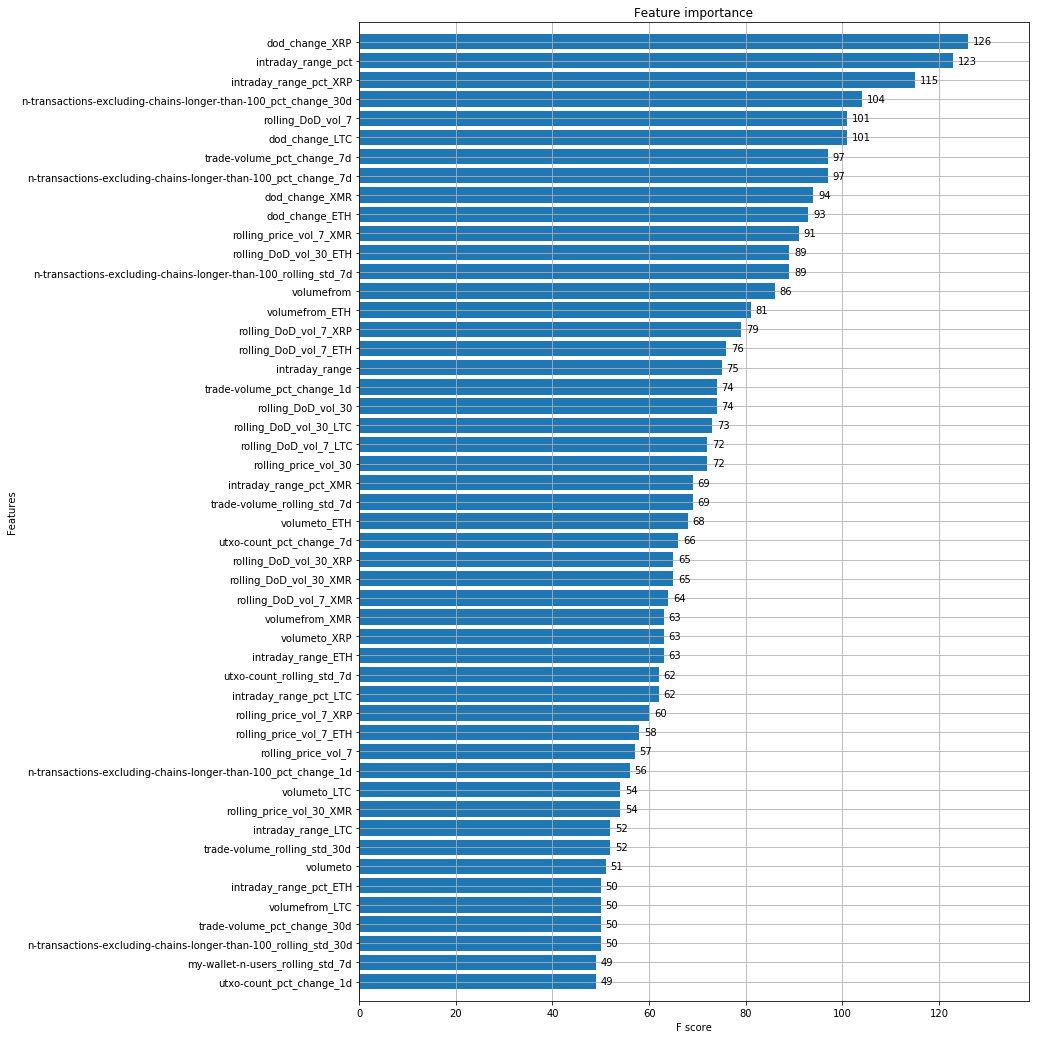

In [115]:
fig, ax = plt.subplots(figsize=(12,18))
plot_importance(model_clss_opt, max_num_features=50, height=0.8, ax=ax)
plt.show()

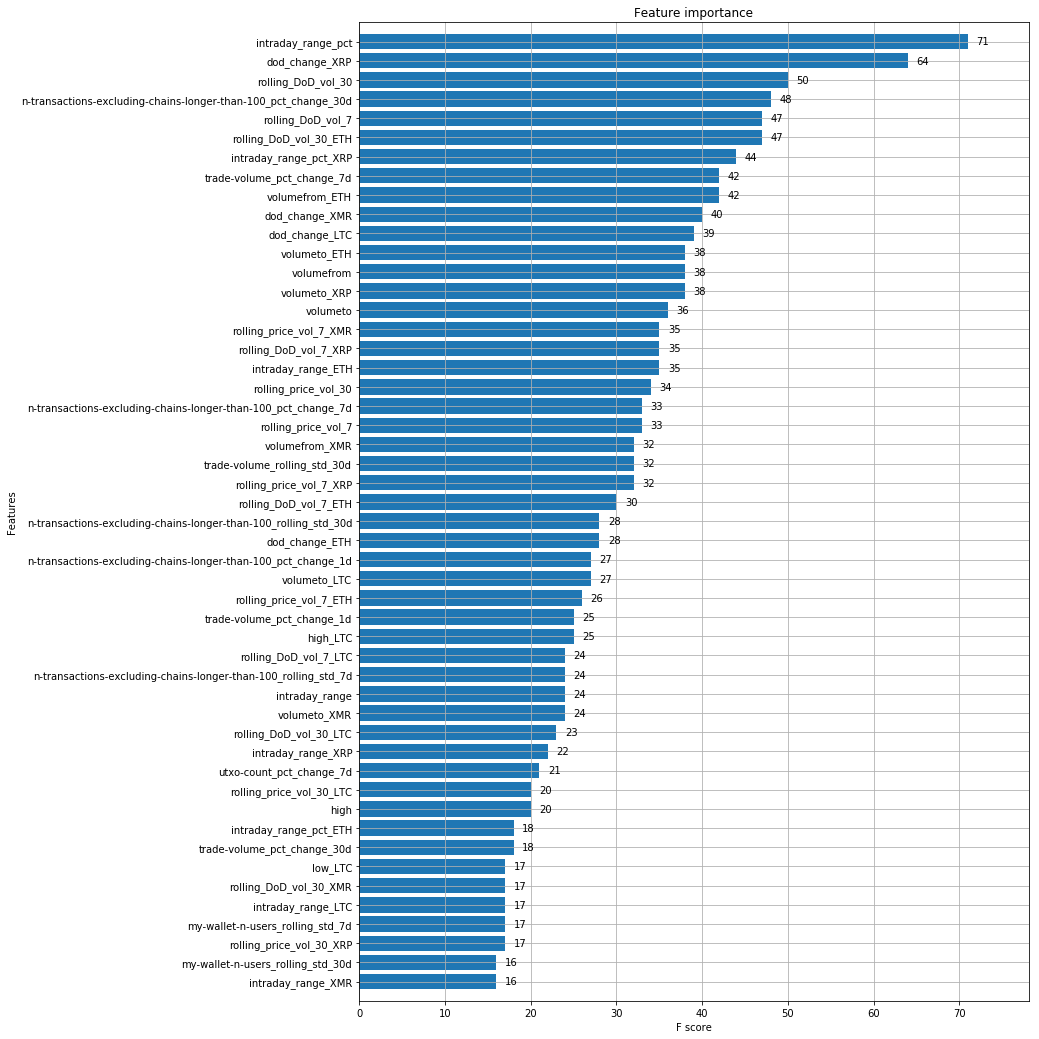

In [116]:
fig, ax = plt.subplots(figsize=(12,18))
plot_importance(model_clss, max_num_features=50, height=0.8, ax=ax)
plt.show()

# Backtesting

In [117]:
model_df = master_df.copy()
model_df['pred_label'] = rf_model.predict(master_df[X.columns])
model_df['pred_label_opt'] = rf_model_opt.predict(master_df[X.columns])
model_df['pred_label_xgb'] = model_clss.predict(master_df[X.columns])
model_df['pred_label_xgb_opt'] = model_clss_opt.predict(master_df[X.columns])

model_df[['label','pred_label','pred_label_opt',
         'pred_label_xgb','pred_label_xgb_opt']] = model_df[['label','pred_label','pred_label_opt',
                                                            'pred_label_xgb','pred_label_xgb_opt']].shift(-1-t)

backtest_df = model_df.loc[model_df.index >= '2018-07-01']
backtest_df = backtest_df.reset_index()
bt_df = backtest_df.copy()

In [541]:
bt_df.set_index('recorddate')[['open','dod_change','pred_dod_change','label']].tail(20)

open  dod_change  pred_dod_change  label
recorddate                                             
2019-03-15  3927.08    0.011759         0.008847    1.0
2019-03-16  4027.01    0.025446         0.008104    0.0
2019-03-17  3998.00   -0.007204        -0.014746    0.0
2019-03-18  3988.85   -0.002289         0.000978    0.0
2019-03-19  4024.14    0.008847         0.001592    0.0
2019-03-20  4056.75    0.008104        -0.003269    0.0
2019-03-21  3996.93   -0.014746        -0.017416    0.0
2019-03-22  4000.84    0.000978         0.004502    0.0
2019-03-23  4007.21    0.001592         0.026320    0.0
2019-03-24  3994.11   -0.003269        -0.002355    0.0
2019-03-25  3924.55   -0.017416         0.018563    0.0
2019-03-26  3942.22    0.004502         0.001642    1.0
2019-03-27  4045.98    0.026320        -0.001321    0.0
2019-03-28  4036.45   -0.002355         0.009393    1.0
2019-03-29  4111.38    0.018563         0.182017    0.0
2019-03-30  4118.13    0.001642         0.014196    0.0
2019-03-31  4112.69   -0.001321        -0.012705    0.0
2019-04-01  4151.32    0.009393         0.027246    1.0
2019-04-02  4906.93    0.182017         0.001985    1.0
2019-04-03  4976.59    0.014196         0.026042    0.0

In [118]:
pd.crosstab(bt_df['label'],bt_df['pred_label'])

pred_label  -1.0   0.0   1.0
label                       
-1.0          11    10    53
 0.0           6    24   102
 1.0          10     9    59

In [119]:
pd.crosstab(bt_df['label'],bt_df['pred_label_opt'])

pred_label_opt  0.0  1.0
label                   
-1.0             12   62
 0.0             45   87
 1.0             11   67

In [544]:
print(classification_report(bt_df['label'],bt_df['pred_label_opt']))

              precision    recall  f1-score   support

         0.0       0.75      0.84      0.79       203
         1.0       0.33      0.22      0.26        74

   micro avg       0.68      0.68      0.68       277
   macro avg       0.54      0.53      0.53       277
weighted avg       0.64      0.68      0.65       277



In [545]:
print(classification_report(bt_df['label'],bt_df['pred_label']))

              precision    recall  f1-score   support

         0.0       0.74      0.78      0.76       203
         1.0       0.29      0.24      0.26        74

   micro avg       0.64      0.64      0.64       277
   macro avg       0.51      0.51      0.51       277
weighted avg       0.62      0.64      0.63       277



In [120]:
def return_func(start_date,model, df):
    usd_bal = 1
    btc_bal = 0
    df = df.loc[df['recorddate'] >= start_date].copy()
    for idx, row in df.iterrows():
        acc_value = usd_bal + btc_bal * row['open']

        if row[model] == 1 and usd_bal > 0:

            btc_bal = usd_bal / row['open']
            usd_bal = 0

        elif row[model] == -1 and btc_bal > 0:
 
            usd_bal = btc_bal * row['open']
            btc_bal = 0    
        
    return acc_value / 1 - 1

In [121]:
def return_func_nosell_churn(start_date,model, df):
    usd_bal = 1
    btc_bal = 0
    acc_value = 0
    df = df.loc[df['recorddate'] >= start_date].copy()
    for idx, row in df.iterrows():
        acc_value = usd_bal + btc_bal * row['open']

        if row[model] == 1 and usd_bal > 0:

            btc_bal = usd_bal / row['open']
            usd_bal = 0

        elif btc_bal > 0:
 
            usd_bal = btc_bal * row['open']
            btc_bal = 0    
        
    return acc_value / 1 - 1

In [122]:
def return_func_nosell(start_date,model, df):
    usd_bal = 1
    btc_bal = 0
    acc_value = 0
    df = df.loc[df['recorddate'] >= start_date].copy()
    for idx, row in df.iterrows():
        acc_value = usd_bal + btc_bal * row['open']

        if row[model] == 1 and usd_bal > 0:

            btc_bal = usd_bal / row['open']
            usd_bal = 0

        elif row[model] != 1 and btc_bal > 0:
 
            usd_bal = btc_bal * row['open']
            btc_bal = 0    
        
    return acc_value / 1 - 1

In [123]:
def hodl_func(start_date, df):
    end_val = list(df['open'])[-1]
    start_val = float(df.loc[bt_df['recorddate'] == start_date]['open'])
    
    return (end_val - start_val)/start_val

In [550]:
return_func_nosell('2019-01-07','label', bt_df)

0.949687324350305

In [551]:
hodl_func('2019-01-01', bt_df)

0.2825767045088463

In [126]:
def backtest_func(df):
    scenarios_df = pd.DataFrame(df['recorddate'])
    scenarios_df['rf_profit'] = scenarios_df['recorddate'].apply(lambda x: return_func(x,'pred_label', df))
    scenarios_df['rf_profit_nosell'] = scenarios_df['recorddate'].apply(lambda x: return_func_nosell(x,'pred_label', df))
    scenarios_df['rf_profit_nosell_churn'] = scenarios_df['recorddate'].apply(lambda x: return_func_nosell_churn(x,'pred_label', df))
    
    scenarios_df['rf_opt_profit'] = scenarios_df['recorddate'].apply(lambda x: return_func(x,'pred_label_opt', df))
    scenarios_df['rf_opt_profit_nosell'] = scenarios_df['recorddate'].apply(lambda x: return_func_nosell(x,'pred_label_opt', df))
    scenarios_df['rf_opt_profit_nosell_churn'] = scenarios_df['recorddate'].apply(lambda x: return_func_nosell_churn(x,'pred_label_opt', df))
    
    scenarios_df['xgb_profit'] = scenarios_df['recorddate'].apply(lambda x: return_func(x,'pred_label_xgb', df))
    scenarios_df['xgb_profit_nosell'] = scenarios_df['recorddate'].apply(lambda x: return_func_nosell(x,'pred_label_xgb', df))
    scenarios_df['xgb_profit_nosell_churn'] = scenarios_df['recorddate'].apply(lambda x: return_func_nosell_churn(x,'pred_label_xgb', df))
    
    scenarios_df['xgb_opt_profit'] = scenarios_df['recorddate'].apply(lambda x: return_func(x,'pred_label_xgb_opt', df))
    scenarios_df['xgb_opt_profit_nosell'] = scenarios_df['recorddate'].apply(lambda x: return_func_nosell(x,'pred_label_xgb_opt', df))
    scenarios_df['xgb_opt_profit_nosell_churn'] = scenarios_df['recorddate'].apply(lambda x: return_func_nosell_churn(x,'pred_label_xgb_opt', df))

    
    scenarios_df['hodl'] = scenarios_df['recorddate'].apply(lambda x: hodl_func(x, df))
    scenarios_df = scenarios_df.set_index('recorddate')
    
    return scenarios_df 

In [127]:
scen_df = backtest_func(bt_df)

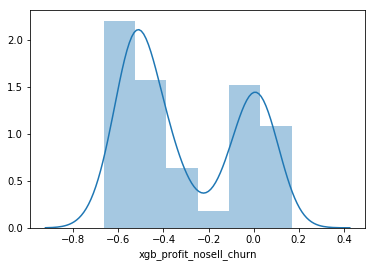

In [128]:
sns.distplot(scen_df['xgb_profit_nosell_churn'])

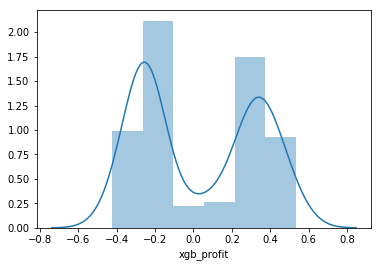

In [129]:
sns.distplot(scen_df['xgb_profit'])

In [130]:
scen_df.describe()

rf_profit  rf_profit_nosell  rf_profit_nosell_churn  rf_opt_profit  rf_opt_profit_nosell  rf_opt_profit_nosell_churn  xgb_profit  xgb_profit_nosell  xgb_profit_nosell_churn  xgb_opt_profit  xgb_opt_profit_nosell  xgb_opt_profit_nosell_churn        hodl
count  284.000000        284.000000              284.000000     284.000000            284.000000                  284.000000  284.000000         284.000000               284.000000      284.000000             284.000000                   284.000000  284.000000
mean     0.073390          0.137581                0.098095       0.086014             -0.120332                    0.044847    0.027761          -0.136580                -0.305345        0.132212              -0.054547                     0.141202    0.094291
std      0.287830          0.223368                0.156079       0.298839              0.166321                    0.149556    0.304740           0.221000                 0.251520        0.266010               0.166177                     0.130228    0.306453
min     -0.359903         -0.217780               -0.197977      -0.366517             -0.425512                   -0.306625   -0.424638          -0.470557                -0.665640       -0.305227              -0.339301                    -0.220852   -0.366517
25%     -0.195891         -0.067902               -0.040017      -0.185630             -0.264811                   -0.016245   -0.250027          -0.343586                -0.528251       -0.094332              -0.207213                     0.080374   -0.182582
50%      0.000000          0.050300                0.098498       0.022566             -0.194992                    0.052696   -0.003128          -0.223661                -0.416076        0.040121              -0.063546                     0.108396    0.002315
75%      0.362005          0.330060                0.228169       0.372843              0.061678                    0.125333    0.333920           0.076199                -0.017324        0.372761               0.097329                     0.191359    0.380459
max      0.551588          0.642471                0.465857       0.645347              0.170174                    0.548794    0.533934           0.257811                 0.168400        0.612796               0.217499                     0.533984    0.645347

In [135]:
plot_list = ['hodl','rf_profit','rf_profit_nosell','rf_profit_nosell_churn','rf_opt_profit','rf_profit_nosell_churn','xgb_opt_profit']

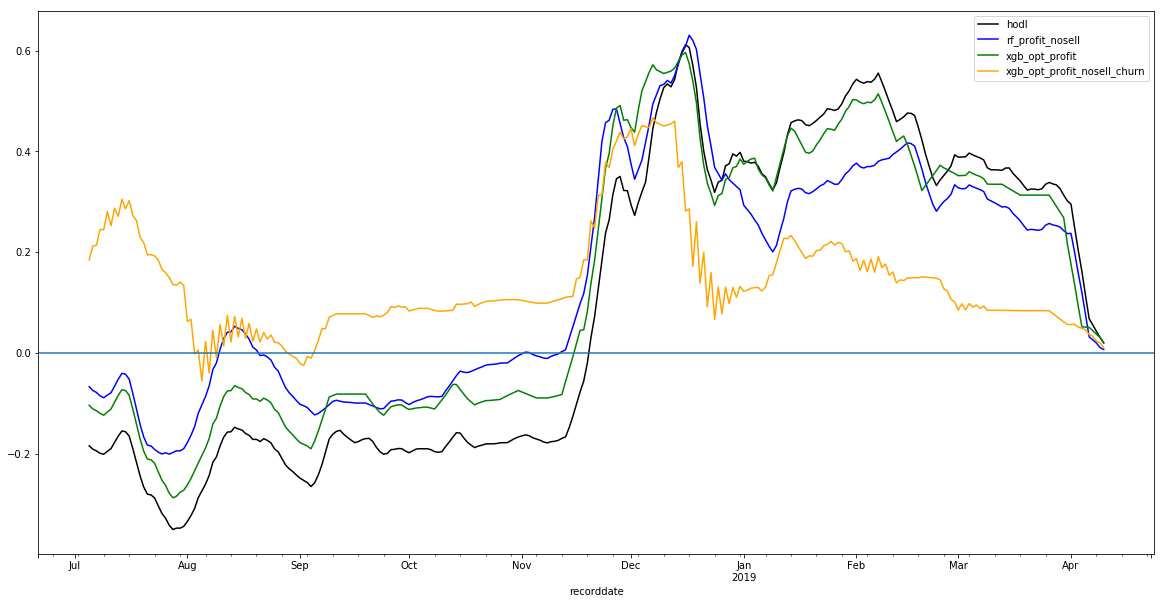

In [155]:
plot_list = ['hodl','rf_profit_nosell','xgb_opt_profit','xgb_opt_profit_nosell_churn']
fig, ax = plt.subplots(figsize=(20,10))
scen_df[plot_list].rolling(5).mean().plot(ax = ax, color = ['black','blue','green','orange','red','pink','purple'])
ax.axhline(y=0, xmin=0, xmax=1)
plt.show()

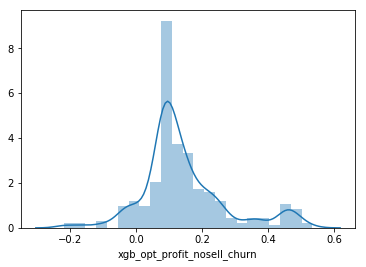

In [165]:
sns.distplot(scen_df['xgb_opt_profit_nosell_churn'])

In [174]:
(scen_df.sub(scen_df['hodl'], axis = 0).mean() / scen_df.std()).sort_values(ascending = False)

xgb_opt_profit_nosell_churn    0.360218
rf_profit_nosell               0.193805
xgb_opt_profit                 0.142553
rf_profit_nosell_churn         0.024370
hodl                           0.000000
rf_opt_profit                 -0.027698
rf_profit                     -0.072617
xgb_profit                    -0.218319
rf_opt_profit_nosell_churn    -0.330608
xgb_opt_profit_nosell         -0.895663
xgb_profit_nosell             -1.044667
rf_opt_profit_nosell          -1.290417
xgb_profit_nosell_churn       -1.588883
dtype: float64

In [175]:
scen_df.mean()

rf_profit                      0.073390
rf_profit_nosell               0.137581
rf_profit_nosell_churn         0.098095
rf_opt_profit                  0.086014
rf_opt_profit_nosell          -0.120332
rf_opt_profit_nosell_churn     0.044847
xgb_profit                     0.027761
xgb_profit_nosell             -0.136580
xgb_profit_nosell_churn       -0.305345
xgb_opt_profit                 0.132212
xgb_opt_profit_nosell         -0.054547
xgb_opt_profit_nosell_churn    0.141202
hodl                           0.094291
dtype: float64

AttributeError: module 'seaborn' has no attribute 'plt'

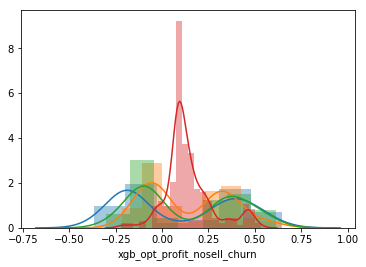

In [158]:
for col in plot_list:
    sns.distplot(scen_df[col])
sns.plt.show()

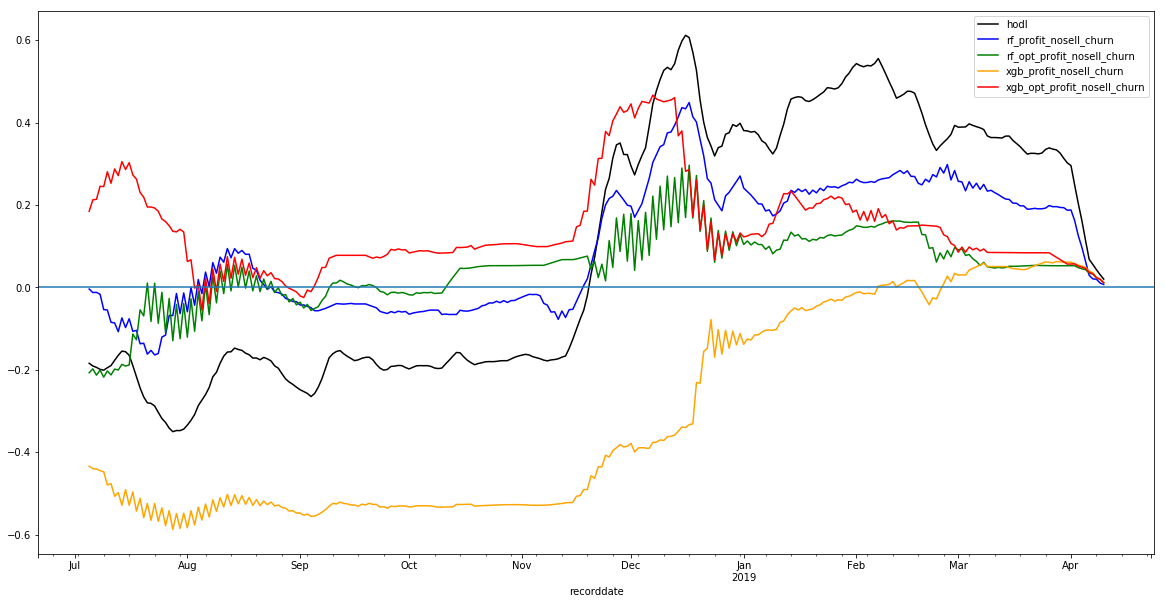

In [154]:
plot_list = ['hodl','rf_profit_nosell_churn','rf_opt_profit_nosell_churn','xgb_profit_nosell_churn','xgb_opt_profit_nosell_churn']
fig, ax = plt.subplots(figsize=(20,10))
scen_df[plot_list].rolling(5).mean().plot(ax = ax, color = ['black','blue','green','orange','red','pink','purple'])
ax.axhline(y=0, xmin=0, xmax=1)
plt.show()

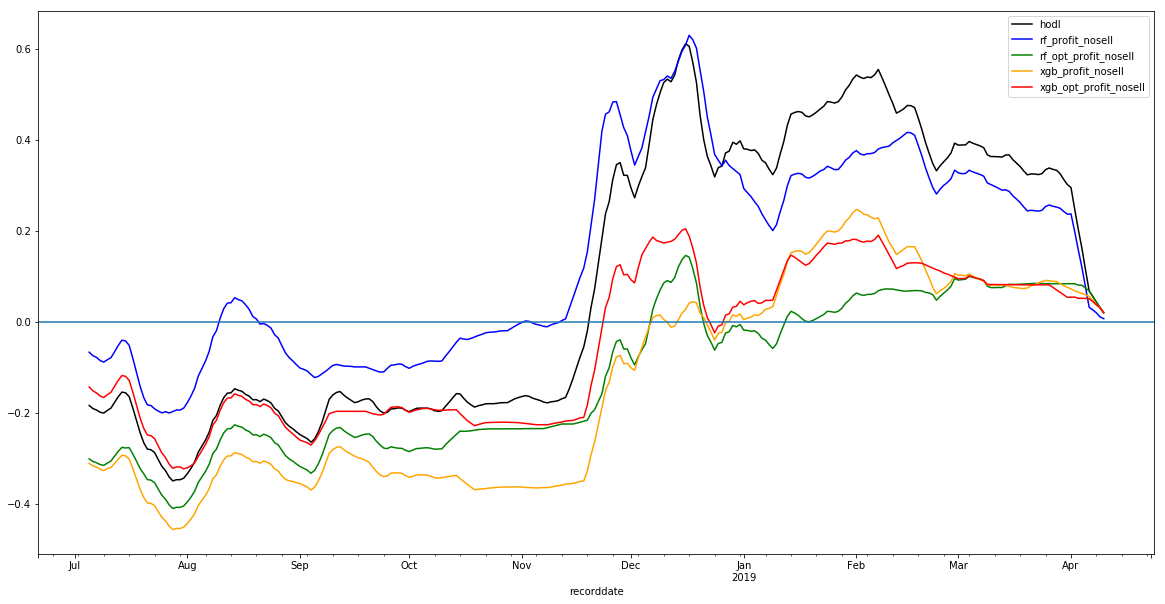

In [153]:
plot_list = ['hodl','rf_profit_nosell','rf_opt_profit_nosell','xgb_profit_nosell','xgb_opt_profit_nosell']
fig, ax = plt.subplots(figsize=(20,10))
scen_df[plot_list].rolling(5).mean().plot(ax = ax, color = ['black','blue','green','orange','red','pink','purple'])
ax.axhline(y=0, xmin=0, xmax=1)
plt.show()

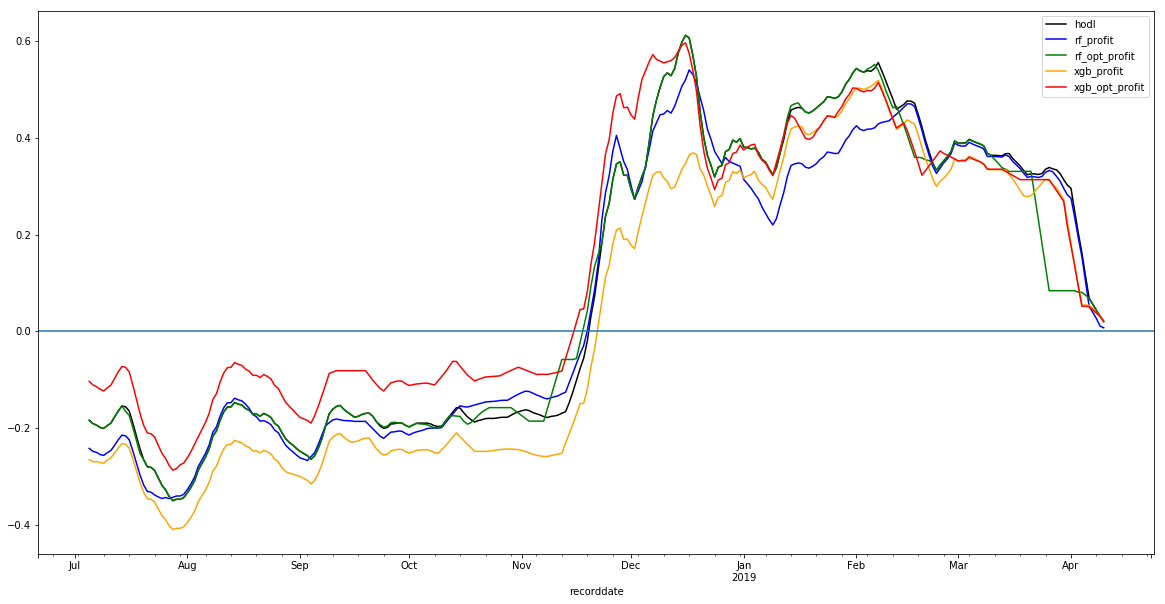

In [152]:
plot_list = ['hodl','rf_profit','rf_opt_profit','xgb_profit','xgb_opt_profit']
fig, ax = plt.subplots(figsize=(20,10))
scen_df[plot_list].rolling(5).mean().plot(ax = ax, color = ['black','blue','green','orange','red','pink','purple'])
ax.axhline(y=0, xmin=0, xmax=1)
plt.show()

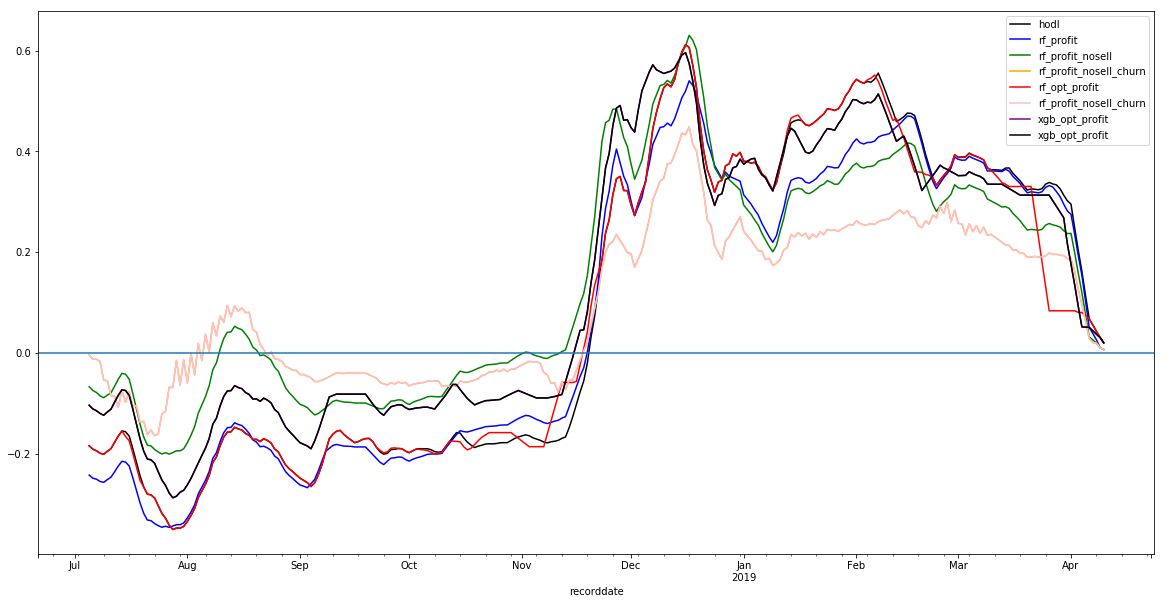

In [137]:
fig, ax = plt.subplots(figsize=(20,10))
scen_df[plot_list].rolling(5).mean().plot(ax = ax, color = ['black','blue','green','orange','red','pink','purple'])
ax.axhline(y=0, xmin=0, xmax=1)
plt.show()

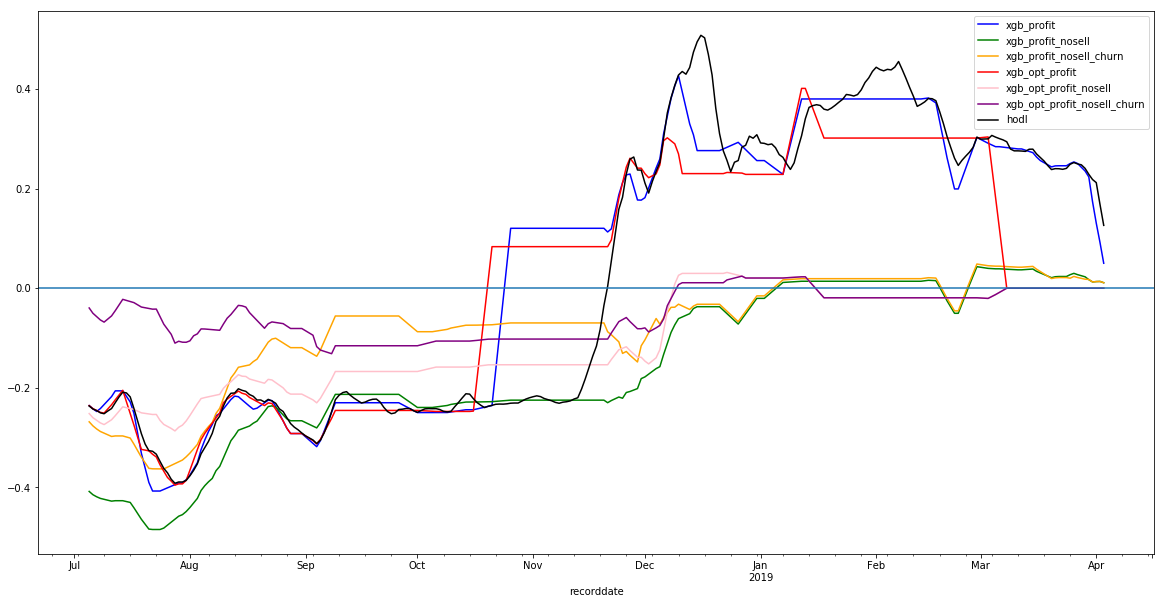

In [554]:
fig, ax = plt.subplots(figsize=(20,10))
scen_df.rolling(5).mean().plot(ax = ax, color = ['blue','green','orange','red','pink','purple','black'])
ax.axhline(y=0, xmin=0, xmax=1)
plt.show()

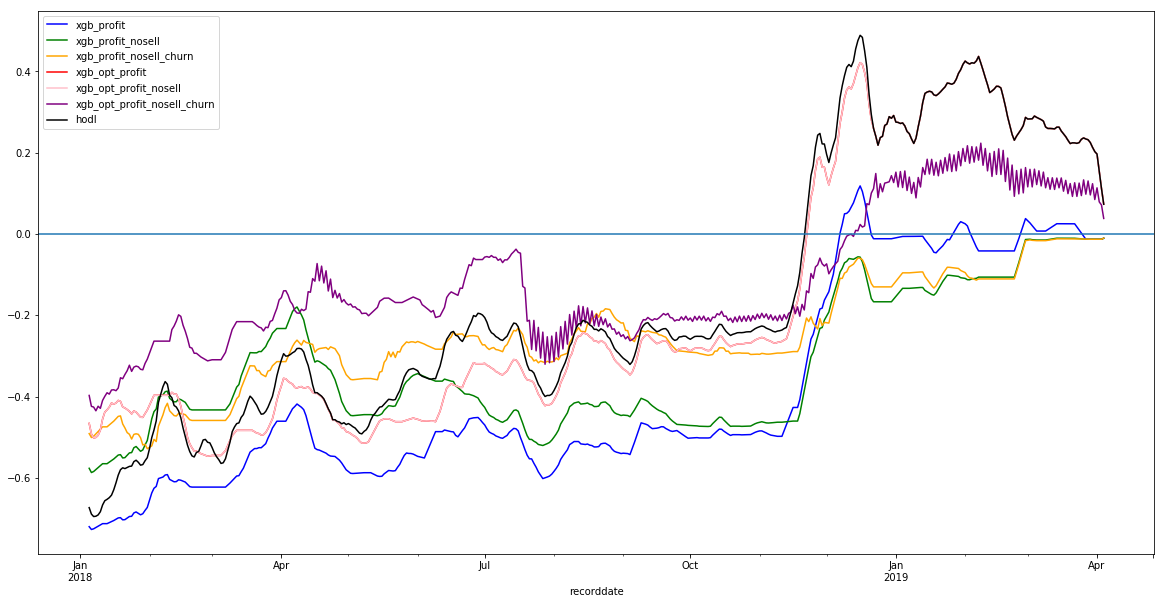

In [308]:
fig, ax = plt.subplots(figsize=(20,10))
scen_df.rolling(5).mean().plot(ax = ax, color = ['blue','green','orange','red','pink','purple','black'])
ax.axhline(y=0, xmin=0, xmax=1)
plt.show()

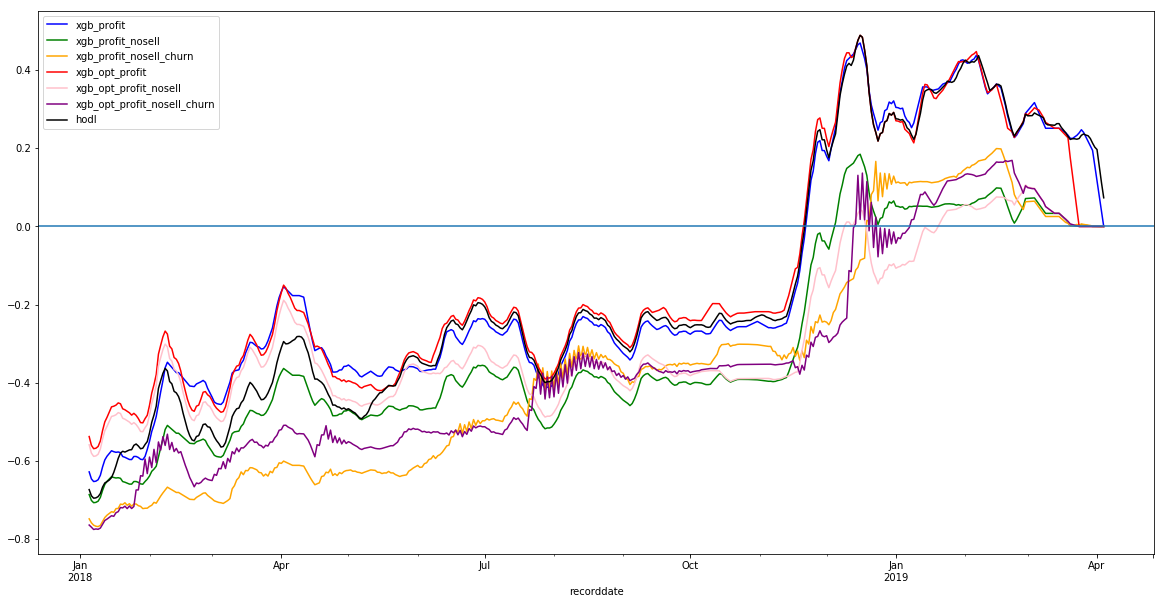

In [129]:
fig, ax = plt.subplots(figsize=(20,10))
scen_df.rolling(5).mean().plot(ax = ax, color = ['blue','green','orange','red','pink','purple','black'])
ax.axhline(y=0, xmin=0, xmax=1)
plt.show()

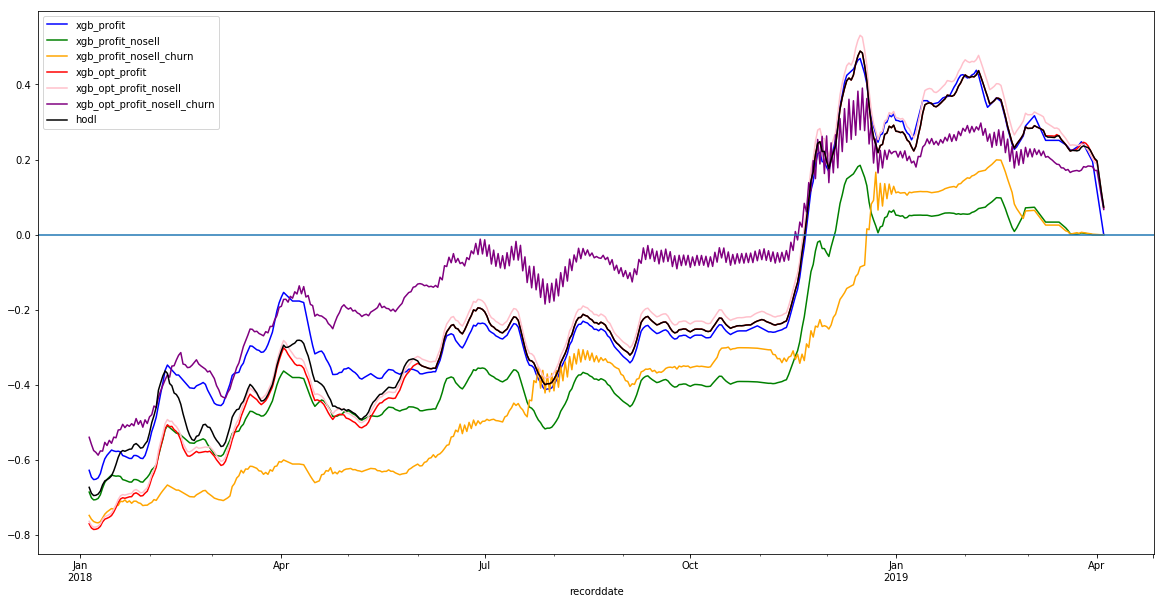

In [91]:
fig, ax = plt.subplots(figsize=(20,10))
scen_df.rolling(5).mean().plot(ax = ax, color = ['blue','green','orange','red','pink','purple','black'])
ax.axhline(y=0, xmin=0, xmax=1)
plt.show()

In [831]:
bt_df.tail()

recorddate     high      low     open  volumefrom      volumeto  intraday_range  intraday_range_pct  dod_change  rolling_price_vol_7  rolling_price_vol_30  rolling_DoD_vol_7  rolling_DoD_vol_30  high_ETH  low_ETH  open_ETH  volumefrom_ETH  volumeto_ETH  intraday_range_ETH  intraday_range_pct_ETH  dod_change_ETH  rolling_price_vol_7_ETH  rolling_price_vol_30_ETH  rolling_DoD_vol_7_ETH  rolling_DoD_vol_30_ETH  high_LTC  low_LTC  open_LTC  volumefrom_LTC  volumeto_LTC  intraday_range_LTC  intraday_range_pct_LTC  dod_change_LTC  rolling_price_vol_7_LTC  rolling_price_vol_30_LTC  rolling_DoD_vol_7_LTC  rolling_DoD_vol_30_LTC  high_XRP   low_XRP  open_XRP  volumefrom_XRP  volumeto_XRP  intraday_range_XRP  intraday_range_pct_XRP  dod_change_XRP  rolling_price_vol_7_XRP  rolling_price_vol_30_XRP  rolling_DoD_vol_7_XRP  rolling_DoD_vol_30_XRP  high_XMR  low_XMR  open_XMR  volumefrom_XMR  volumeto_XMR  intraday_range_XMR  intraday_range_pct_XMR  dod_change_XMR  rolling_price_vol_7_XMR  \
454 2019-03-31  4164.33  4082.20  4118.13    36921.55  1.528268e+08        0.019970            0.000002    0.001642             0.018869              0.023180           3.365505            5.407146     29.21    28.84     28.89        84620.33    2457222.63            0.012807                0.000443        0.003808                 0.010055                  0.013819              -7.209252               14.384718     68.35    67.66     67.98        70584.30    4800394.73            0.010150                0.000149       -0.002059                 0.010022                  0.065851               4.926537               -4.544833  13303.18  13163.09  13213.53        26557.51  3.520166e+08            0.010602            8.023603e-07        0.005982                 0.010463                  0.026015               2.051367                2.087458     77.34    72.46     76.75         5099.49     383995.20            0.063583                0.000828       -0.045472                 0.005786   
455 2019-04-01  5104.42  4147.70  4112.69   172473.31  8.147481e+08        0.230462            0.000005   -0.001321             0.020051              0.023746           1.328491            4.996274     29.52    28.93     29.00        90168.29    2630129.91            0.020345                0.000702        0.011379                 0.009628                  0.013028             -53.962083               20.594704     68.82    67.66     67.84        72670.10    4968310.56            0.017099                0.000252        0.010318                 0.011562                  0.058082               3.077228               -5.920694  13338.67  13164.82  13292.57        33081.14  4.388413e+08            0.013079            9.839132e-07       -0.001857                 0.010581                  0.026344               2.478056                2.285733     73.64    69.01     73.26         6952.89     496763.04            0.063200                0.000863       -0.058013                 0.016383   
456 2019-04-02  5335.70  4831.59  4151.32   159843.43  8.091583e+08        0.102734            0.000056    0.009393             0.017466              0.024765           1.983094            3.916278     31.55    29.27     29.33       176955.06    5376478.86            0.077736                0.002650        0.013979                 0.009268                  0.013160               8.252232               18.057081     71.63    62.50     68.54       130290.64    8800579.79            0.133207                0.001943       -0.077181                 0.014282                  0.051941              -4.145640               -3.975375  14486.46  13089.01  13267.88        45495.69  6.314648e+08            0.105326            7.938404e-06        0.044484                 0.009496                  0.026503               1.924659                2.406263     75.19    67.61     69.01         5720.72     411349.29            0.109839                0.001592        0.024054                 0.037851   
457 2019-04-03  

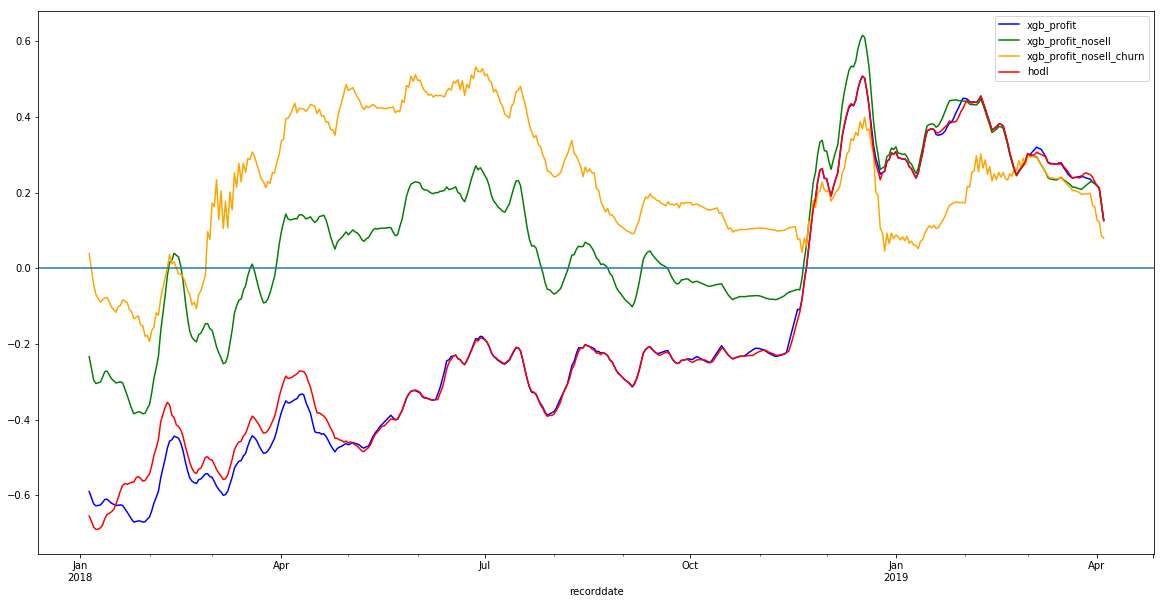

In [823]:
fig, ax = plt.subplots(figsize=(20,10))
scen_df.rolling(5).mean().plot(ax = ax, color = ['blue','green','orange','red','pink','black'])
ax.axhline(y=0, xmin=0, xmax=1)
plt.show()

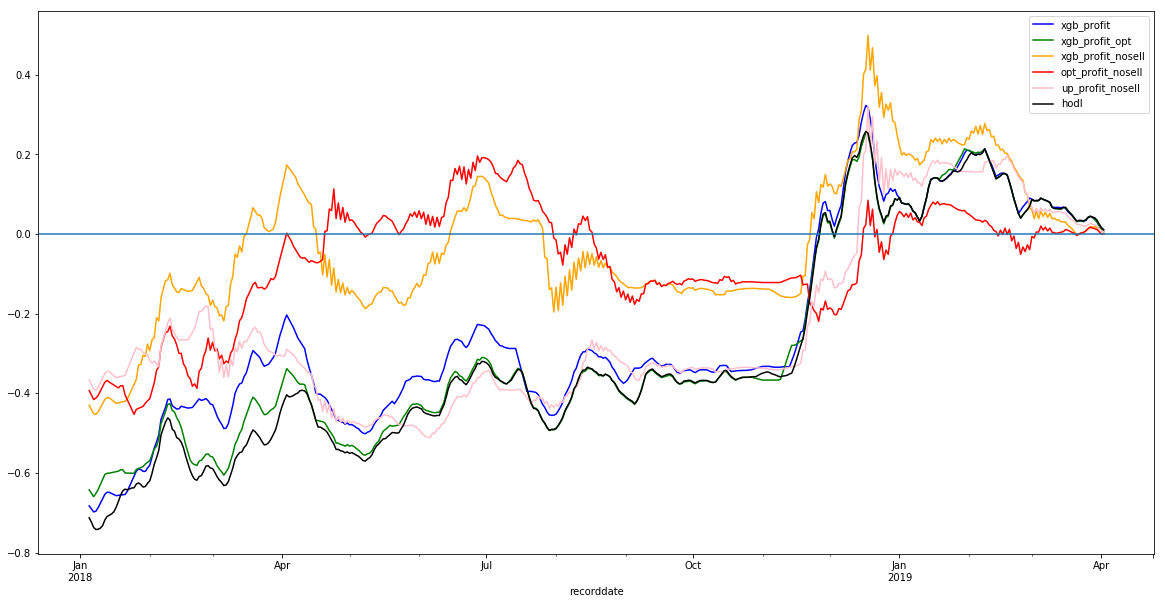

In [491]:
fig, ax = plt.subplots(figsize=(20,10))
scenarios_df.rolling(5).mean().plot(ax = ax, color = ['blue','green','orange','red','pink','black'])
ax.axhline(y=0, xmin=0, xmax=1)
plt.show()

# Strategy: Models for longer duration forecasts

total-bitcoins 2019-04-04 00:00:00
trade-volume 2019-04-05 00:00:00
blocks-size 2019-04-04 00:00:00
avg-block-size 2019-04-04 00:00:00
n-transactions-per-block 2019-04-04 00:00:00
median-confirmation-time 2019-04-04 00:00:00
my-wallet-n-users 2019-04-05 17:54:32
estimated-transaction-volume 2019-04-04 00:00:00
output-volume 2019-04-04 00:00:00
n-transactions-excluding-popular 2019-04-04 00:00:00
utxo-count 2019-04-06 11:00:00
n-transactions-total 2019-04-04 00:00:00
n-transactions 2019-04-04 00:00:00
cost-per-transaction 2019-04-04 00:00:00
cost-per-transaction-percent 2019-04-04 00:00:00
transaction-fees 2019-04-04 00:00:00
miners-revenue 2019-04-04 00:00:00
difficulty 2019-04-04 00:00:00
hash-rate 2019-04-04 00:00:00

In [316]:
float(bc_df.loc[bc_df.index == '2019-04-05', 'hash-rate'].isna())

1.0

In [319]:
list(bc_df.index)[-3]

Timestamp('2019-04-04 00:00:00')

In [495]:
bc_df.columns

Index(['total-bitcoins', 'total-bitcoins_pct_change_1d', 'total-bitcoins_pct_change_7d', 'total-bitcoins_pct_change_30d', 'total-bitcoins_rolling_std_7d', 'total-bitcoins_rolling_std_30d', 'trade-volume', 'trade-volume_pct_change_1d', 'trade-volume_pct_change_7d', 'trade-volume_pct_change_30d',
       ...
       'difficulty_pct_change_7d', 'difficulty_pct_change_30d', 'difficulty_rolling_std_7d', 'difficulty_rolling_std_30d', 'hash-rate', 'hash-rate_pct_change_1d', 'hash-rate_pct_change_7d', 'hash-rate_pct_change_30d', 'hash-rate_rolling_std_7d', 'hash-rate_rolling_std_30d'], dtype='object', length=114)

In [498]:
bc_df.loc[bc_df.index == list(bc_df.index)[-3], 'total-bitcoins']

recorddate
2019-04-04    17627925.0
Name: total-bitcoins, dtype: float64

In [532]:
bc_df = t_master_df.copy()
t1_list = []
t_list = []

t1_master_df = t_master_df.copy()

for col in bc_df.columns:
    if float(bc_df.loc[bc_df.index == list(bc_df.index)[-2], col].isna()) == 0:
        t1_list.append(col)
        
    if float(bc_df.loc[bc_df.index == list(bc_df.index)[-1], col].isna()) == 0:
        t_list.append(col)     
        
t1_master_df = bc_df[t1_list]
t_master_df = bc_df[t_list]

              precision    recall  f1-score   support

        -1.0       0.41      0.08      0.13       145
         0.0       0.47      0.22      0.30       167
         1.0       0.34      0.83      0.49       147

   micro avg       0.37      0.37      0.37       459
   macro avg       0.41      0.37      0.30       459
weighted avg       0.41      0.37      0.30       459



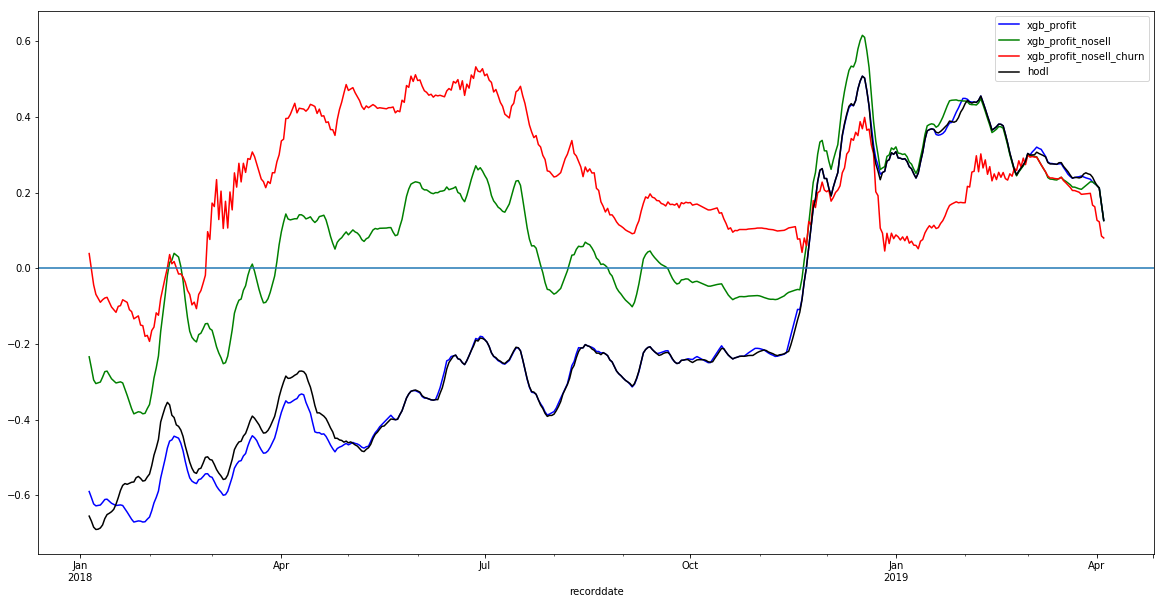

In [694]:
t = 1
t = -t - 1
master_df = pd.merge(prices_df, excels_df, on = ['recorddate'], how = 'outer').sort_values('recorddate')
master_df = master_df.set_index('recorddate')

t_list = []
for col in master_df.columns:
    if float(master_df.loc[master_df.index == list(excels_df['recorddate'])[t + 1], col].isna()) == 0: 
        t_list.append(col)
master_df = master_df[t_list]


master_df = master_df.drop(columns = [s for s in master_df.columns if "close" in s])
master_df[[s for s in master_df.columns if s in ('high','low','intraday_range','volumefrom','volumeto')]] = master_df[[s for s in master_df.columns if s in  ('high','low','intraday_range','volumefrom','volumeto')]].shift(-1)
master_df[[s for s in master_df.columns if s in ('dod_change')]] = master_df[[s for s in master_df.columns if s in  ('dod_change')]].shift(1)

master_df['pred_dod_change'] = master_df['dod_change'].shift(t) 

master_df = master_df.dropna()
master_df=master_df.replace([np.inf,-np.inf],0).fillna(0)

bins = [-np.inf,-0.01,0.01,np.inf]
buckets = ['-1','0','1']

master_df['label'] = pd.cut(master_df['pred_dod_change'], bins = bins, labels = buckets).astype(float)

drop_list = ['pred_dod_change','label','dod_change']
X = master_df.drop(columns = drop_list)
y = master_df['label']

X = X.astype(float)
split_cutoff_date = '2018-01-01'

X_train, X_test = X.loc[(X.index < split_cutoff_date)], X.loc[(X.index >= split_cutoff_date) ]
y_train, y_test = y.loc[ (y.index < split_cutoff_date)], y.loc[(y.index >= split_cutoff_date) ]
y_train_up, y_test_up = y_up.loc[ (y_up.index < split_cutoff_date)], y_up.loc[(y_up.index >= split_cutoff_date) ]

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred))

model_df = master_df.copy()
model_df['pred_label'] = model.predict(master_df.drop(columns = drop_list))

model_df[['label','pred_label']] = model_df[['label','pred_label']].shift(-1-t) 

backtest_df = model_df.loc[model_df.index >= '2018-01-01']
backtest_df = backtest_df.reset_index()
bt_df = backtest_df.copy()

scen_df = backtest_func(bt_df)

fig, ax = plt.subplots(figsize=(20,10))
scen_df.rolling(5).mean().plot(ax = ax, color = ['blue','green','red','black'])
ax.axhline(y=0, xmin=0, xmax=1)
plt.show()

In [741]:
backtest_func(bt_df)

1.0
1.0
1.0973761015345618
1.0973761015345618
1.0973761015345618
1.225668667836673
1.2415537899540274
1.1731495943031438
1.0826353385831207
1.0826353385831207
1.116478332688147
1.116478332688147
1.1612052195150797
1.1612052195150797
1.1612052195150797
1.1608621016920546
1.1608621016920546
1.1485368373965232
1.149855894815913
1.1854869076345336
1.315306028320384
1.315306028320384
1.315306028320384
1.315306028320384
1.315306028320384
1.2862747368309309
1.2862747368309309
1.327517901219688
1.3631198857018803
1.301331011250958
1.1707938765424104
1.1846315634343665
1.0558076330547326
1.0277917034407325
1.071623787150059
0.9519404215841221
0.803483563435213
0.803483563435213
0.7922710487704011
0.7922710487704011
0.7922710487704011
0.7806550367949211
0.7364985222891183
0.8117971722652203
0.8117971722652203
0.9011931069618516
0.9532668683376639
0.9679909046406385
1.0543019931715867
0.9897843404874533
0.9897843404874533
0.9963786068952267
0.9963786068952267
0.9361395681180191
0.9672762213474249

0.6044242314334812
0.6069902655719628
0.6100490669948331
0.6042784610471027
0.5952628795417247
0.5366346639245028
0.5456431153566339
0.5194606941640825
0.49993142354114134
0.5263285391614569
0.5067667870937248
0.5151953259017842
0.5116049379068481
0.5319478291102835
0.5340646686342174
0.5356483371253643
0.5324295051696217
0.4794158261190617
0.4885177607337617
0.48783802708423496
0.4959678950462902
0.48264733376057634
0.4865538216694531
0.4651033924216841
0.49148466343478464
0.5058731512467946
0.502487158684933
0.5241871404963395
0.5156175846840659
0.5220615864384371
0.5177074883757344
0.5230328608607212
0.5353956156402838
0.5313853455541483
0.5283257519009172
0.49964938953271293
0.5065806129589476
0.49543393178314216
0.4935286177655293
0.4965953414920072
0.5041959995730788
0.5340060435875217
0.5804481717956292
0.5849345723285778
0.5923585630392014
0.5810162009642897
0.5866782713525969
0.5861427236287273
0.6114433924297598
0.665141558512011
0.647281517259178
0.6288011596338748
0.6482725

0.534732518828333
0.5324263362481787
0.5479001796544213
0.5618006535642069
0.5586499534194892
0.5544630159629056
0.5566971055802312
0.5706799714475352
0.5784271921453463
0.5759554334197946
0.5838650613415602
0.5311952102675673
0.5161713537062328
0.5080668371157218
0.4912010449656347
0.49507029804755615
0.5010405460461966
0.49875179253397894
0.5020427174525501
0.5143294181174803
0.5137922859328893
0.5167465129481401
0.5151430386979744
0.49604157246984026
0.5027842450702156
0.5069347399302047
0.5154226960153205
0.5357117155542246
0.5321094441038772
0.5310106205935117
0.5215672346933268
0.5100173082638976
0.5119867929407315
0.5296955181946604
0.5256765335745566
0.5231691244827709
0.5247591308168037
0.5224743384563898
0.5169667529884296
0.5143642762533535
0.5212875773759806
0.5254768915236466
0.5220750543545699
0.5229877037301582
0.5268387355137824
0.5253905384143245
0.5213723460245813
0.4919330658189713
0.49531034384686456
0.49651215730412807
0.49734083026147646
0.5238773784252847
0.52152

0.28040477169652794
0.2650213930901715
0.2676976766275876
0.2985449604250213
0.3001785997480961
0.2807695921368717
0.29393603885430625
0.29016599422703043
0.2710881959599185
0.2764820766738683
0.2617135010360758
0.24404316742364893
0.23951897382468362
0.24235491006919835
0.2515818562158577
0.24278135085263275
0.2381500218844302
0.24407187690167984
0.2314341047187165
0.22655839507166564
0.2263504264137346
0.22795115487174952
0.24845532403517664
0.2601953998562961
0.26164417815009877
0.28973185090070963
0.2730068293697877
0.2832603144138442
0.28062674497788875
0.28583086304436606
0.2685197480229111
0.2695035728188477
0.25531058720401595
0.2764414632659222
0.2658819771999267
0.2728247692652016
0.2624039289711601
0.2717001980037965
0.27736226725642515
0.26859887414528894
0.27127375722036207
0.26996642562319934
0.28729434619277
0.28362163369833054
0.2829459106178474
0.2834773860770046
0.25685529716831207
0.256928821441318
0.2565913100166622
0.2486688945424796
0.25935862360637135
0.253570512

0.30859464450180324
0.30613500319564435
0.2996281558225443
0.3111032698496453
0.3111675112157873
0.31178021324536587
0.3106086113303525
0.31701026346639516
0.31557286289896963
0.3111602840620963
0.3122588114231232
0.31144535512435106
0.3116862602473833
0.31535123018578
0.323375779833983
0.3210462272942615
0.3203114666690133
0.3231453139329488
0.325763952620309
0.32096030446704665
0.32127428414406534
0.3217858060219704
0.3207338536513964
0.3151480668653562
0.31656699804001587
0.32489910322862336
0.32413382795445767
0.3301508349107256
0.33069287143754805
0.33025603014778293
0.3333580851153611
0.3940348584534844
0.3996286754102924
1.0
1.031259827662117
1.031259827662117
1.072572802800605
1.072572802800605
1.072572802800605
1.0722558744584412
1.0722558744584412
1.060871372349299
1.062089748816777
1.0950011193852383
1.2149114124075857
1.2149114124075857
1.2149114124075857
1.2149114124075857
1.2149114124075857
1.1880960199528674
1.1880960199528674
1.2261911780535935
1.2590757359591074
1.2020

0.7414968509651478
0.7670691771141523
0.7662815161049561
0.7502539903949021
0.7683572952274449
0.7350691587776564
0.7285485982615698
0.7009993805621919
0.6714397355271143
0.6844550598013444
0.611092519778867
0.5893484325086201
0.5970891796754159
0.5877860088691992
0.608343445274063
0.6392694585881941
0.5860593458708737
0.583905316582624
0.570526258021396
0.5948044468135878
0.5948044468135878
0.5728352429210911
0.5797148039080497
0.588655533338857
0.6688656122533991
0.6664197148654677
0.6768622371043184
0.7067479139843835
0.6816932852047998
0.6683526403279552
0.6909866828343497
0.7004277286332298
0.748968540782199
0.7539210822334436
0.744438694947151
0.7566217781764476
0.7566217781764476
0.6951907042132415
0.7277379232196108
0.7277379232196108
0.7277379232196108
0.7322063405754481
0.719823041475749
0.7065158595330995
0.7065158595330995
0.745856320237459
0.7423444760494631
0.7423444760494631
0.7423444760494631
0.7217991245816202
0.7217991245816202
0.7316409158820141
0.7089339199237725
0.

0.49336490988733506
0.4892501478474751
0.4942827953059792
0.5059659942928814
0.5021761606964893
0.4992847467594553
0.4721846664179686
0.4787348944177383
0.468200923911765
0.4664003411778015
0.46929849326228074
0.47648135843884853
0.5046528042241197
0.5485421019498603
0.5527818940589809
0.559797802915518
0.5490789076963267
0.5544297454508534
0.5539236357094152
0.5778335775771312
0.6285800633529222
0.611701752685782
0.5942372231909107
0.6126383551806628
0.6162275417197982
0.6151704012539536
0.6121292507070265
0.579199924142405
0.5698151821173604
0.564682211130228
0.5553431387712009
0.5254175286010331
0.5272652783671128
0.5200180264482911
0.5033613259637925
0.4705517886870853
0.48988203634122357
0.4606609369206024
0.4673676396777104
0.4733481198768372
0.46891516754095464
0.4641557893955053
0.46974021626146517
0.4734529355037624
0.4934704741973096
0.4795868957280296
0.4868116871553674
0.4694310101620361
0.48597690555521383
0.476622110852148
0.489573578924844
0.5022869657878101
0.5053393465

0.4856135382701758
0.48458828823024586
0.48502939288584757
0.4839996494198843
0.4835832586074657
0.48455383863065726
0.48459652617797355
0.47288665793520873
0.4724919853486177
0.4750157929706514
0.4778983257710096
0.4788981130634175
0.47754259621004047
0.484320180476926
0.4818098531329922
0.4852690422742899
0.4891049302980454
0.4827482302696119
0.4776504384348395
0.4790284224183831
0.4799113806339254
0.47743250727222475
0.47474319179129815
0.4299092846397659
0.42294372538382097
0.41841060742056596
0.4169861913680116
0.4205292577952642
0.36019452863754453
0.332649078149112
0.3439747584660301
0.3235775998922298
0.32528060835884826
0.2886359701529948
0.2998957468880913
0.2834430674671844
0.28630537985039284
0.31929686269117813
0.3210440565137907
0.300285926048649
0.3143675743326543
0.3103354733721116
0.2899315746592613
0.29570038478167227
0.2799052433703041
0.2610066423786074
0.25616797144508835
0.25920103401756195
0.269069346491015
0.2596571167599413
0.2547038634625733
0.2610373474565015

0.2716449438520321
0.27200600472671005
0.2738037396897291
0.27786699917667074
0.2961584793372415
0.29704182952749125
0.30081215283309043
0.2980107140549289
0.3015297329362239
0.31406164874580017
0.2854893954198715
0.2910824327427127
0.28899100465731414
0.28996291694890003
0.2894065652866604
0.29002044446771663
0.29088789889618816
0.28856938849967134
0.28243589527636886
0.2932525826959656
0.2933131379789305
0.2938906839902078
0.29278630701713626
0.29882064096458383
0.29746571650824527
0.29330632550959695
0.2943418208482959
0.2935750395777535
0.29380212188887167
0.2972568007820165
0.30482091256536364
0.3026250266168507
0.3019324255679402
0.30460367048772724
0.30707205520958203
0.3025440339258852
0.30283999787137594
0.3033221693119836
0.3023305765534341
0.29706529469964016
0.29840280951212633
0.3062568297126677
0.3055354649043489
0.3112072240950444
0.31171815929506036
0.31130638337089933
0.31423044659706467
0.371425668298405
0.37669851956256956
1.0
1.0309873723996734
1.1438877117127435
1.

0.500259818728149
0.5068304390282633
0.4989335782165618
0.5163834581893268
0.542634553400792
0.4974679255213131
0.4956395091858558
0.48428289051784007
0.5048910768712532
0.5048910768712532
0.486242838663372
0.4920824536388727
0.4996716613768395
0.5677568166510457
0.5656806523373374
0.5745446349902407
0.5999126557974747
0.5786453996885136
0.5673213879160561
0.5865339646817856
0.5945478586695037
0.6357510188835682
0.6399549114401282
0.6319059253339651
0.642247357789966
0.642247357789966
0.5901024868953454
0.6177297189063401
0.6177297189063401
0.6177297189063401
0.6215226697875663
0.6110112870109925
0.5997156797620244
0.5997156797620244
0.6331092558794206
0.630128278175942
0.630128278175942
0.630128278175942
0.612688656325656
0.612688656325656
0.6210427172857201
0.6017682150467334
0.5610339230698359
0.5610339230698359
0.5756670846988553
0.5732492652291885
0.5605110977006433
0.5514247761452826
0.53346959137396
0.5451601252613292
0.5452480339517244
0.5640181917700944
0.5565129047066536
0.52

0.49852423452287103
0.490279324718436
0.4638597889004887
0.4654910569297772
0.45909289059123853
0.44438768349415086
0.4154221004927272
0.4324876228785464
0.40669005756933513
0.41261100530287126
0.4178908144673596
0.4139772253257803
0.409775454311928
0.41470561161762637
0.41798334993093356
0.43565564057075884
0.4233986574527979
0.4297769947634279
0.41443263200008335
0.4290400158928215
0.4207812257688503
0.4322153042286004
0.44343919499251827
0.44613395988530985
0.4442098832105696
0.4571199023143234
0.46871723977052177
0.46608857163742584
0.4625953578875109
0.46445928651092816
0.47612536459720994
0.48258896672784735
0.48052674782534316
0.48712584831335665
0.44318273956489923
0.4306481500562166
0.4238864515393518
0.40981511236774537
0.4130432781112808
0.4180243299219448
0.4161147945343376
0.41886045393209476
0.42911140039329276
0.4286632643625563
0.431128012531607
0.42979021411536705
0.41385362438514944
0.419479119602846
0.422941928843301
0.4300235356770927
0.446950915835148
0.44394549617

0.2287655120798152
0.2374750821049107
0.22916804134636168
0.22479640166009154
0.23038620462755247
0.21845706143768198
0.21385474406007404
0.21365843668377799
0.21516940861042047
0.23452386178450002
0.24560564451507227
0.24697318647317523
0.27348591872229344
0.257698707668988
0.26737725619122166
0.26489135705906836
0.2698036682396489
0.2534632273076909
0.2543918867814147
0.24099473455870393
0.2609407537320595
0.2509733623699558
0.2575268560937793
0.247690336315873
0.2564653421330672
0.2618099261220573
0.253537916646147
0.2560628128665207
0.25482878636300293
0.27118509051728795
0.26771831547125124
0.2670804817401882
0.26758215614627817
0.24245282907758992
0.24252223067527032
0.24220364429353733
0.23472545690157173
0.2448157882367093
0.23935223008026704
0.24085593136334305
0.24358638850637027
0.2411242842077074
0.24652637237763267
0.23581539246895297
0.23609233789207773
0.23808317229411063
0.23610093047083816
0.23785051169998195
0.23681741934593897
0.23771699624539674
0.23564023605575948


0.6115150473823084
0.6115150473823084
0.6788557096923961
0.7180821196172403
0.7291735228212547
0.7941904152124215
0.745590202270015
0.745590202270015
0.7505575676077741
0.7505575676077741
0.7051803725267424
0.7286351622518362
0.6949957450115536
0.6949957450115536
0.7468045174157016
0.7662048737650878
0.747378732093306
0.7904036109531446
0.7986299232425007
0.8291659944605906
0.8319560703122245
0.8273558441607877
0.7763794660814791
0.7180258034603049
0.6737816224009187
0.6691524685579149
0.6362117829783208
0.6902132744032449
0.6611619169548295
0.6624528151910054
0.5941906950158559
0.5979317687277539
0.599036806545612
0.5700686162104517
0.5941386251710353
0.623618835646931
0.6451258511346816
0.644463406997798
0.6309838259198807
0.6462091931838645
0.6182129732853541
0.6127290061565465
0.5895593715959846
0.5646989134633335
0.5756451519522736
0.5139452786090906
0.49565791519274344
0.5021680921798893
0.494343874803314
0.5116332328606007
0.5376428435407496
0.4928917046866522
0.491080108002271


0.42658870171130886
0.42373338873925503
0.4420323774190691
0.43480591031127647
0.4402399570390924
0.43656826773296054
0.44105900563612976
0.45148417150625125
0.4481024227312077
0.44552235284396585
0.42134037725916695
0.4271852844169813
0.41778559945750615
0.41617890135320357
0.4187649838321039
0.42517440654007865
0.4503123841985811
0.48947573399917454
0.49325899028385883
0.4995194343318504
0.4899547371346361
0.4947294029772351
0.49427779053710685
0.5156131380044698
0.5608953019162098
0.545834427877375
0.5302504583642494
0.5466701781179083
0.549872885274676
0.5489295764500295
0.5462158934148206
0.5168323579796682
0.5084581539308395
0.5038778952185324
0.4955444431798336
0.46884118749289827
0.4704899737388104
0.46402309737721
0.44915997079736614
0.41988332588058735
0.43713211521738105
0.41105750939163027
0.41704204228907005
0.42237855141887015
0.4184229341733085
0.41417604026517896
0.4191591426186065
0.42247208062244707
0.4403341543084091
0.42794554322891326
0.43439237761831867
0.41888323

0.325974522295005
0.3370729544671766
0.3170850619431228
0.31875389979007895
0.28284453097327483
0.2938783819095044
0.27775582313211644
0.28056070362950714
0.31289021711761644
0.314602353747761
0.2942607321813884
0.3080598342202261
0.30410863678486455
0.28411413936168034
0.28976719913965016
0.27428898496632004
0.2557695816822659
0.25102799798429587
0.25400020259299094
0.2636705087976266
0.2544471341008169
0.2495932671176295
0.25579967066719345
0.24255464627763096
0.23744465598371897
0.2372266943124147
0.23890433869154476
0.26039374495125045
0.27269793815356674
0.2742163310758853
0.30365363262254585
0.2861249642080567
0.2968711350932719
0.2941110211344319
0.29956520006080756
0.2814222760271881
0.2824533741692169
0.2675784074497997
0.28972463423414296
0.2786577588022612
0.28593415601095534
0.2750125883599431
0.28475554845501355
0.2906896833848674
0.2815052042051591
0.2843086169471875
0.28293846731646316
0.3010990044144305
0.2972498159767501
0.2965416240144314
0.2970986371744313
0.26919734

0.8409603423964103
0.8895536659118396
0.9032935963608757
0.9838359374006254
0.9236304310860302
0.9236304310860302
0.9297839585523348
0.9297839585523348
0.8735710977521738
0.9026266801335731
0.8609544728640455
0.8609544728640455
0.9251347137577577
0.9491677005696161
0.9258460457315375
0.979144878371435
0.9893355599857231
1.02716337013796
1.0306196909878873
1.0249209722407677
0.9617718939438067
0.8894839019635619
0.8346746087345048
0.8289400546234668
0.7881334298455148
0.85502999132424
0.8190414312251136
0.8206405843399711
0.7360780843335848
0.7407124927723288
0.7420814036740107
0.7061958702461496
0.7360135806785317
0.772533400047748
0.7991760972369623
0.7983554674032315
0.7816570837013663
0.8005181316157054
0.7658366664155016
0.7590431773006756
0.7303408425702529
0.6995439308188012
0.7131040325255144
0.6366707848240116
0.6140165636389127
0.6220813122887431
0.6123887422329204
0.6338066433628354
0.6660271149459447
0.610589806964218
0.6083456172988297
0.5944065566186797
0.619700948240465
0

0.7927604009528832
0.7988878053589183
0.8090272909123273
0.7935361998155227
0.8012693022859327
0.8005378657013523
0.8350928342888743
0.9084323359744588
0.8840395750827662
0.8587996028808271
0.885393165566953
0.8905803060794962
0.8890525125034198
0.8846574009552447
0.8370674966658854
0.8235045416544692
0.8160863031575989
0.80258935055988
0.7593404574795994
0.7620108502173876
0.7515370245683641
0.7274645376841209
0.6800477544798694
0.7079840875823629
0.6657533628838725
0.675445979636347
0.6840890498103552
0.6776824876545837
0.6708041705418935
0.678874859128264
0.6842405307598246
0.7131701460881242
0.6931054123241271
0.7035467777696929
0.6784279903273294
0.7023403402078477
0.6888206654677085
0.7075383007882102
0.72591185795206
0.7303231996019639
0.7271734778597835
0.7483072343243212
0.7672921253199582
0.7629889843482467
0.757270578505779
0.7603218376308043
0.7794192573317613
0.7900002016521953
0.7866243404925927
0.7974270962033211
0.7254920393206737
0.7049728627082686
0.693903933329187
0.

0.4540336013974641
0.4278241193003889
0.443892172318914
0.4397651527598979
0.4479204331009263
0.4207924943777153
0.4223342286187198
0.40009265471771005
0.43320647264709833
0.4166588909002323
0.42753881616682227
0.4112085037293647
0.4257765206571759
0.4346494481110989
0.4209164915088424
0.42510825293278326
0.4230595569698257
0.45021383136690446
0.4444583893070694
0.4433994757536393
0.4442323414397051
0.40251334207404865
0.40262856064721975
0.402099652530377
0.3896845769412495
0.40643626016059015
0.39736581515265945
0.3998622175713677
0.4043952454358441
0.4003077293876295
0.40927612365932287
0.3914940571999088
0.39195383417284896
0.39525896124324417
0.3919680993295273
0.3948727046931847
0.3931575939325513
0.3946510461047983
0.39120326746761974
0.37895059520067637
0.37509132165931514
0.3804637991283241
0.3768338654135607
0.3798514947109003
0.38501438410871225
0.3785336136977713
0.37651674000740387
0.3783185390278518
0.37252798273619314
0.37038162531597635
0.40162231844152513
0.40076970100

0.8506782711355081
0.8506782711355081
0.8192583238139818
0.8290973441473174
0.8418842093021319
0.9565991742358922
0.9531010972250583
0.9680357985576185
1.0107777384947552
0.9749450738125461
0.9558655313167522
0.9882363184742693
1.001738726805153
1.071160894678319
1.0782439274667273
1.0646823933084786
1.0821064126380553
1.0821064126380553
0.9942488317592165
1.0407972598063326
1.0407972598063326
1.0407972598063326
1.047187907306261
1.0294775429579137
1.0104458585290201
1.0104458585290201
1.0667098546657994
1.061687280341842
1.061687280341842
1.061687280341842
1.0323037003095068
1.0323037003095068
1.0463792474126699
1.0139041235834567
0.9452719400052306
0.9452719400052306
0.9699269858281041
0.9658532626418684
0.9443910446962333
0.929081730141509
0.8988294911163335
0.9185265775009562
0.9186746926414071
0.9503000592468528
0.9376545899248994
0.8901107434878373
0.8358783291293616
0.8446772593902823
0.8324917265570972
0.8190945450561637
0.8198930304373914
0.7927924143255695
0.832423794049071
0

0.6967412158106603
0.72416762960739
0.7192981292741715
0.7178127549697565
0.7050473175446484
0.6894342879959361
0.6920966099287229
0.7160350178786761
0.7106022104912957
0.7072127298326994
0.7093620782313733
0.7062735277671105
0.6988284505037422
0.695310458730128
0.7046692806813042
0.7103323371497582
0.7057337810840355
0.7069674877882071
0.7121732588723891
0.7102156062202837
0.7047838697588618
0.6649882611416623
0.6695536185026721
0.6711782131816897
0.6722984017342619
0.7081701376395826
0.7049959130986413
0.7042837473362505
0.6949634787195798
0.692811988468989
0.6950952026124732
0.6971588769344683
0.6944226611105463
0.6929565634733841
0.6935873388629302
0.6921148156700171
0.691519380837101
0.692907300879294
0.6929683436589275
0.6762233453720994
0.6756589673919792
0.6792679878720643
0.6833899818862624
0.6848196680408362
0.6828812920559834
0.6925731719802475
0.6889834281674151
0.6939300351696445
0.6994153179289904
0.6903252983933933
0.6830355053940048
0.6850060091576121
0.6862686308626627

0.3791089064407738
0.3738079185102421
0.37512761850823434
0.37415038451849303
0.3744397924127895
0.3788426511780209
0.38848282813703877
0.3856842537991912
0.3848015597215867
0.38820596125149504
0.39135182506249844
0.3855810316502254
0.38595822660579193
0.38657273603468156
0.38530898822958665
0.3785985838538309
0.38030319635123744
0.39031285072197386
0.3893934983110918
0.39662194281763846
0.3972731105798057
0.39674831759814794
0.40047492658370637
0.4733680929201764
0.4800881442257421
1.0
1.015445870188115
1.1059882895228603
1.0383077114737762
1.0383077114737762
1.0452252564203164
1.0452252564203164
0.9820330478394661
1.0146961501286527
0.9678499520110704
0.9678499520110704
1.0399987647844111
1.0670156697029283
1.040798415217025
1.1007147920274827
1.112170741235271
1.1546952246945816
1.158580679819298
1.1521744123106612
1.0811847905296865
0.9999215742108083
0.9383071991265636
0.931860646961372
0.8859875014259387
0.961189891166138
0.9207330177045058
0.9225307205032665
0.8274690021979348
0

0.5558231646182593
0.6041627124234079
0.6088324074051649
0.6165597094842827
0.6047539487472504
0.6106473462458583
0.6100899184147321
0.6364242604485287
0.6923162956875306
0.6737265722779017
0.654491189117131
0.6747581436044385
0.6787112634600879
0.6775469319548363
0.674197417383779
0.6379291506730927
0.6275928224731416
0.6219393828130806
0.6116533550535121
0.5786933730447169
0.5807284793867575
0.572746376716193
0.5544007341320275
0.518264403002673
0.539554682842684
0.5073706469715955
0.5147573903314011
0.5213442742293836
0.5164618331227293
0.5112198675569464
0.517370539439151
0.5214597178630488
0.5435069781009502
0.5282156442246123
0.5361730089736773
0.5170299807198387
0.5352535828912723
0.5249502385866541
0.539214948720755
0.5532174368869593
0.5565793204187663
0.5541789174359137
0.5702849535269744
0.5847533392147561
0.5814739154212814
0.5771159182504204
0.5794412828713906
0.5939954266870379
0.6020591644985515
0.5994864206625844
0.6077192009376791
0.5528974931022301
0.5372598283248967


0.311922300478957
0.32533115439790294
0.318070733430131
0.3200689741392625
0.3236974279280196
0.32042558325043063
0.32760431789470845
0.3133706956127407
0.3137387232422467
0.3163843061063804
0.31375014176058463
0.3160751277636928
0.3147022705204521
0.3158977015556732
0.31313793350816055
0.30333030460347365
0.300241156219291
0.30454154589485494
0.301635972151643
0.3040514279538899
0.30818405324464326
0.30299653252898134
0.3013821297055159
0.30282437640634846
0.29818933630872774
0.29647128847265686
0.3214778436326458
0.3207953675750655
0.32368337436698835
0.3172011693413221
0.3177343263129453
0.31672071322356604
0.31521434715052843
0.3156333189387727
0.3177193944043496
0.3224343641303356
0.3436596330253525
0.3446846646330696
0.34905971385161216
0.34580894951557006
0.349892387342714
0.3644343096198049
0.33127932410438155
0.3377694342581279
0.3353425599375431
0.33647035821030125
0.335824772750428
0.3365371126251997
0.33754369893406333
0.3348533203441425
0.32773607002937644
0.34028765672541

0.7085275842970004
0.711535580791532
0.715121216625242
0.7083567070648319
0.697788321727453
0.6290622418937633
0.6396222691056557
0.608930303638605
0.5860373979310719
0.6169810358433272
0.5940500542307999
0.6039302872364568
0.5997215067136974
0.6235681674073016
0.6260496019961835
0.627906034534797
0.6241328052179453
0.5619882848645724
0.5726578963883989
0.5718610884253522
0.5813912088411856
0.5657763730711778
0.570355697157172
0.545210740971331
0.5761358052713941
0.5930025025031582
0.5890333215776785
0.6144708121555473
0.6044252740013797
0.6119791620799596
0.6068751334495348
0.6131177245073433
0.6276097854203309
0.6229088041744774
0.6193222396601578
0.5857067876340502
0.5938318142875412
0.5807652781103074
0.5785318012441917
0.5821267238839978
0.5910364856526106
0.6259808796310723
0.6804219943277178
0.6856811126199478
0.6943837786126171
0.6810878583248092
0.6877251386417026
0.6870973505496053
0.7167556944981582
0.7797025948982356
0.7587664192351539
0.7371030866547463
0.7599281986777778


0.31143711397374285
0.30487595073076706
0.30459609068722787
0.30675016496174207
0.33434229221735273
0.35014072147654157
0.3520903188842275
0.38988744368707756
0.3673808539903266
0.38117880219754974
0.37763485060242813
0.38463794771887155
0.36134266153578276
0.36266657857676815
0.3435673084673503
0.3720027850124143
0.3577930562024078
0.36713585866601617
0.3531127032183692
0.36562254139354466
0.37324189597959984
0.36144914027288694
0.36504868696083287
0.363289432074342
0.38660733321044416
0.3816650236873351
0.38075571411825976
0.38147091200730454
0.3456459995651536
0.34574493998458666
0.34529075634490347
0.33462969057856307
0.3490146852744224
0.34122571854076766
0.34336942762848416
0.34726202641589377
0.34375199725029204
0.35145333104102033
0.3361835263085167
0.3365783456965401
0.3394165222997058
0.3365905954627556
0.33908483632217784
0.33761203750718843
0.3388944938009828
0.3359338195356618
0.3254122126462366
0.32209817974008326
0.32671163015479093
0.3235945357977948
0.3261858324972323


0.7293477141422514
0.719642417321022
0.6831528944771704
0.6415299491138735
0.6482830578927844
0.6389307586573909
0.6286485287358241
0.6292613598957378
0.6084618532339482
0.6388786209994345
0.6318930295489802
0.6411854986850795
0.6436479346288895
0.6532814353309659
0.6598174463210092
0.6413205437663436
0.65209679936494
0.6548652235308549
0.6581652808647841
0.6519395316753667
0.642212866961532
0.5789604859876637
0.5886794582601605
0.5604319589519424
0.5393623621276246
0.5678414893916818
0.5467368492234914
0.5558301696005115
0.5519565980290616
0.5739039878815965
0.5761877882432279
0.5778963649359306
0.5744236550297521
0.5172286442515733
0.5270484729771662
0.5263151269029597
0.5350862194594949
0.520715029609019
0.5249296327464459
0.5017873503394348
0.530249383289408
0.54577272990915
0.5421196749893846
0.56553119284322
0.5562857330708518
0.5632379906088423
0.5585404730985404
0.5642858720621956
0.5776237106262896
0.573297139731612
0.5699962276819786
0.5390580833369281
0.5465359910330037
0.53

0.2834106463502436
0.28676626578711667
0.2976840429030861
0.28727085152466125
0.28179083499244434
0.2887978655054408
0.2738442310371235
0.2680750512497292
0.26782897249102516
0.26972303323983793
0.29398457604243466
0.30787601196308
0.3095902777939171
0.34282499553511514
0.3230351263376552
0.33516755483497174
0.3320513857727299
0.3382091545763942
0.3177257906953138
0.3188899006481056
0.30209606105156733
0.32709915432231257
0.31460465034501733
0.322819703855288
0.3104892523837955
0.3214890557526663
0.32818869495428493
0.31781941662034263
0.32098447001512165
0.3194375708821236
0.3399408199154226
0.33559508560766965
0.33479553677888385
0.33542440471779417
0.3039238379596518
0.3040108355006077
0.3036114753602194
0.29423728318521153
0.3068858970922002
0.3000371192489427
0.3019220659696554
0.3053447977952659
0.3022584564613518
0.3090301793397625
0.2956035588522248
0.29595072046803955
0.2984463070714622
0.2959614915921579
0.2981546581722574
0.2968596376340271
0.2979872914744183
0.2953839936298

0.5883867317301698
0.5819532259160213
0.5905112921354538
0.5927791167103421
0.6016512620708301
0.6076707186915071
0.5906356643266487
0.6005602503176904
0.6031098802371848
0.606149127263788
0.6004154118165522
0.5914574653874551
0.5332040499622444
0.5421549118994379
0.5161398704640047
0.49673544714030776
0.5229638104986131
0.5035271133784668
0.5119017699741754
0.5083343347178776
0.5285471772843411
0.5306504842139147
0.5322240285822596
0.5290257740707112
0.47635100243662604
0.4853947499343322
0.48471936170619817
0.4927972568077266
0.4795618516004474
0.4834433659978004
0.4621300656889927
0.4883426857319569
0.5026391903932276
0.4992748439048303
0.5208361014302607
0.5123213293280162
0.5187241356772495
0.5143978726215098
0.5196892009076601
0.5319729227025687
0.5279882895897313
0.5249482553973611
0.4964552161272358
0.5033421294232086
0.4922667070807309
0.49037357341096127
0.493420692095235
0.5009727604643701
0.5305922339471525
0.5767374655435084
0.5811951852823464
0.588571715685428
0.577301863

0.3246501742774066
0.30755297884813093
0.33300771595747286
0.32028751727606397
0.3286509635576402
0.3160977807475124
0.32729627926836014
0.33411693752683974
0.32356035354157237
0.3267825789369956
0.325207737362845
0.34608134721497663
0.3416571136550303
0.34084312216116036
0.3414833496677379
0.3094137718382628
0.30950234086091183
0.30909576687122753
0.29955224380216516
0.3124293361808382
0.305456845312103
0.3073758408028328
0.3108603992081975
0.3077183076904092
0.31461235171051233
0.3009431992150063
0.3012966317911011
0.3038372974693772
0.3013075974796196
0.30354038036487746
0.3022219671991585
0.3033699904355907
0.30071966787213006
0.2913009849492778
0.2883343444477848
0.2924641914467356
0.28967384547603925
0.29199351035494336
0.29596224608412297
0.2909804494387383
0.2894300697851289
0.2908151205964601
0.28636389457246836
0.28471398020769145
0.30872883806311
0.3080734272955069
0.3108469029761748
0.3046217659556975
0.30513377925805923
0.30416036352342096
0.3027137361534862
0.303116092570

0.6475545956760614
0.6369681947126845
0.6449287924233351
0.6395499572846904
0.6461286563025159
0.6614009856945375
0.6564468984543957
0.6526672293667964
0.6172418844771456
0.6258043714909741
0.6120343186524133
0.6096805889383593
0.6134690661621027
0.6228585392916801
0.6596843778282379
0.7170566619435268
0.7225989369417336
0.7317701640312968
0.7177583767896709
0.7247530155698553
0.7240914266772565
0.7553466084435876
0.8216826391081571
0.7996192367490587
0.7767895265454262
0.8008435676730842
0.8055353681924915
0.8041534694996666
0.8001780640533102
0.757132702717246
0.7448649264321456
0.7381550840539529
0.7259470073582736
0.6868281173788765
0.6892435040459389
0.6797698642820961
0.657996151733958
0.6151073794848996
0.6403759647186453
0.6021780143072003
0.6109450458159301
0.6187627559846881
0.6129679810836846
0.6067465009205907
0.6140464884204362
0.6188997714358181
0.6450667865562588
0.6269181113723019
0.6363623906823312
0.6136422928396028
0.6352711604822605
0.6230425314689118
0.639972747819

0.3472705312233068
0.3465332990072853
0.3496530152573221
0.3426507324333343
0.34322666545151326
0.3421317285438057
0.3405045042832177
0.3409570908559877
0.343210535531729
0.34830379490830987
0.37123200147222113
0.37233927302446956
0.3770653395212559
0.3735537611023428
0.37796481975393076
0.3936734639861722
0.35785840033345306
0.3648692225267384
0.3622476361523918
0.36346591950550833
0.3627685376795421
0.36353802973513205
0.36462537609235296
0.36171914407475475
0.3540308652505308
0.36758948605741226
0.36766539156227934
0.3683893403149491
0.36700501366993576
0.3745689972299399
0.3728706115585391
0.3676568521929818
0.36895483632620885
0.36799368287082945
0.368278328514081
0.37260873756674767
0.3820902839434564
0.379337760573214
0.3784695913612968
0.38181797294474573
0.3849120710868899
0.3792362369604543
0.37960722511549216
0.38021162269799624
0.3789686700557979
0.37236868640760556
0.37404524924635707
0.3838901932276169
0.3829859689008879
0.3900954682505004
0.3907359209478164
0.39021976351

0.7713684084682084
0.7744764717706796
0.7939294211638062
0.8047073470626949
0.8012686387280459
0.8122725053989227
0.7389982598180028
0.7180970851839374
0.7068220895866748
0.6833584159532317
0.6887413170770861
0.6970471202853922
0.69386300862552
0.6984413401710752
0.7155345861845596
0.7147873284118378
0.7188972461618077
0.7166664943447149
0.690092553108586
0.6994729526714698
0.7052471170834013
0.7170555533325774
0.745281617579488
0.74027014104178
0.7387414588430113
0.7256038295644806
0.7095355831507472
0.7122755283173939
0.7369118896649609
0.7313206821708345
0.7278323770813588
0.7300443923466282
0.7268657914372924
0.7192036438916258
0.715583080789279
0.725214770576618
0.7310429403438052
0.7263103077832337
0.7275799847067965
0.7329375363781839
0.7309228059821139
0.7253327006380947
0.6843768026523392
0.6890752685595857
0.690747230272298
0.6919000792844912
0.7288176992772486
0.7255509263593322
0.7248179965380046
0.715225984154527
0.713011764589043
0.71536154861772
0.7174853918744085
0.7146

0.880890611937326
0.8671655669969693
0.8974941231841496
0.9431195267593342
0.8646182067751156
0.8614403495262393
0.8417021136239371
0.877519926623847
0.877519926623847
0.8451085781697393
0.8552580514711254
0.8684483836485586
0.9867829773804059
0.9831745247067833
0.9985804642519461
1.0426710508697656
1.00570774952589
0.986026185650305
1.0194183760177673
1.0333468290766967
1.1049594912607354
1.112266016681282
1.0982765721835779
1.1162503757734745
1.1162503757734745
1.0256206035762412
1.0736377853361996
1.0736377853361996
1.0736377853361996
1.0802300784692198
1.0619608947475072
1.0423286990158844
1.0423286990158844
1.1003680065153072
1.095186953699254
1.095186953699254
1.095186953699254
1.0648762265197496
1.0648762265197496
1.0793959027360833
1.0458960835369022
0.9750983322117062
0.9750983322117062
1.0005313246078986
0.9963290622570574
0.9741896418017785
0.9583972687736175
0.9271904735957608
0.9475090668705906
0.9476618555235872
0.9802851049055409
0.967240630057591
0.9181966212325199
0.86

0.4537320656246096
0.4561200849114588
0.4047356646278975
0.420524525655944
0.3974539910417003
0.4014676276794917
0.44772946305485145
0.4501794406257482
0.421071648808296
0.44081743889212427
0.4351634829376845
0.4065524075330202
0.41464163909265056
0.3924931277562669
0.3659928345708492
0.35920787739744
0.3634609460481608
0.3772986461989137
0.3641004815563803
0.3571548529006105
0.36603589032756023
0.3470829562514589
0.33977082859344176
0.3394589368923889
0.3418595578641291
0.3726097692790449
0.3902164233526217
0.3923891638559159
0.43451239588498153
0.4094297922498042
0.42480699823807727
0.4208574201651486
0.42866206367432325
0.40270049251799694
0.40417593979065447
0.38289064386930594
0.41458073094901066
0.39874461360262275
0.40915675574383203
0.393528566198146
0.4074702302492499
0.41596166558498543
0.40281915838405413
0.40683069474103034
0.4048700826000684
0.43085685712617683
0.42534887068839133
0.4243354851950714
0.4251325417644288
0.3852072536084393
0.3853175183512358
0.384811350674779

0.6961558197431851
0.6921475158906862
0.6545792676905566
0.6636597053926572
0.6490566926519378
0.646560584219711
0.6505782290185258
0.6605356777914088
0.6995891364557862
0.7604319092266787
0.7663094402253066
0.7760354411061369
0.7611760712831888
0.7685938205410368
0.7678922116844109
0.8010380407453644
0.8713867832171984
0.8479887505784792
0.8237780556102658
0.8492871421164068
0.8542627528540762
0.8527972621653843
0.8485813817280848
0.8029321770816695
0.7899223146292943
0.7828065893023312
0.7698600377083202
0.7283748193530041
0.730936314409443
0.7208896077050959
0.6977987884118815
0.6523156450333066
0.679112744248135
0.6386041737243054
0.6479015289575226
0.6561921377544571
0.6500468329614364
0.6434490112135506
0.6511905799436876
0.6563374413638174
0.6840873171028804
0.6648408161601724
0.6748563863767995
0.6507619342960744
0.6736991469165363
0.6607307997811214
0.6786851364834459
0.6963094264159374
0.7005408750970968
0.6975195979053247
0.7177915271769475
0.7360022209615007
0.7318745605727

0.41047608312123973
0.41192523724357577
0.4108521428532787
0.41116993980993133
0.4160046908438067
0.4265905074699059
0.42351741089907496
0.4225481301812844
0.4262864817147082
0.4297409346335223
0.42340406331786884
0.42381825868470613
0.42449304755599854
0.4231053341786154
0.4157366820770297
0.41760850615171363
0.4286000435591394
0.42759050856017283
0.4355280172141668
0.4362430603666352
0.43566678855190505
0.4397589540304021
0.5198024735025008
0.5271817188359749
1.0
0.96218616333198
0.9216128301245433
0.9394775605011945
0.8387807227095471
0.808934961806113
0.8195598496794358
0.8067903915699624
0.8350073649522695
0.8774561643706271
0.8044203876986413
0.801463784263552
0.783099795103251
0.8164238435608601
0.8164238435608601
0.7862690893757328
0.795711919961605
0.8079838939275712
0.9180796090328311
0.9147223897700836
0.9290557125762329
0.9700765544958755
0.9356867706992037
0.9173755078559596
0.948442814224269
0.9614015184499142
1.0280282503725273
1.0348260693005469
1.0218106200787394
1.038

0.7396622863733114
0.7417961539505998
0.7431634527949601
0.7393248105771207
0.7351602896694891
0.6657330525053909
0.6549465838443266
0.647926855341432
0.6457210857044742
0.6512076767415128
0.557776748754201
0.515121431710592
0.5326597357167501
0.5010738567303241
0.5037110387252988
0.44696523740774813
0.4644014868776011
0.4389238038311628
0.4433562178965953
0.49444495071305244
0.4971505556357772
0.4650056961209528
0.4868117352816874
0.4805678531968395
0.448971536814655
0.4579047878732701
0.43344533076860314
0.4041800327724781
0.3966871423285327
0.4013839704198466
0.4166654775208943
0.40209023419950335
0.39441990802766386
0.4042275809087112
0.38329712328104865
0.37522205809590825
0.3748776240358786
0.37752872255853126
0.4114873695140507
0.43093107810145037
0.43333051941525985
0.47984883260014455
0.4521491439677909
0.4691307868668302
0.4647691151504274
0.4733880846256483
0.44471771818775646
0.4463471116367185
0.42284093667799216
0.45783752465615996
0.4403490882075146
0.4518476192014349
0.

0.9755293875290163
0.9879108083811377
0.9689944918364977
0.9784374557496457
0.9775442916800658
1.0197396877246017
1.1092952406834786
1.0795090117121604
1.0486882450685329
1.081161893740333
1.0874959596420584
1.0856303565854801
1.0802634446762582
1.022150966462743
1.0055891149654277
0.9965306344017586
0.9800493790704854
0.9272377503350098
0.9304985919381509
0.9177089052613252
0.888313765882604
0.830412687448871
0.864526005662607
0.8129576718819757
0.8247934170525341
0.8353475510581626
0.8275244379575959
0.8191252604571226
0.8289804539408462
0.8355325258654722
0.8708587503157088
0.8463575158389467
0.8591075650570632
0.8284347782592832
0.8576343728417057
0.8411253712893362
0.8639816512296676
0.886417774107682
0.8918045047462583
0.8879583500028452
0.9137649781197626
0.936947606470133
0.9316930006939205
0.9247102017179883
0.9284361228366503
0.9517561610438792
0.9646766513344452
0.9605543556286915
0.9737457018871036
0.8859051296417101
0.8608489707430196
0.8473325973231922
0.819204535374541
0

0.9598284014050166
0.9378357939968762
0.9777444820591832
0.9777444820591832
0.94163132252214
0.9529400019209283
0.9676368470998541
1.099486839957765
1.095466253548998
1.1126317581993295
1.1617580816803057
1.1205730751281329
1.0986436124529253
1.1358496392166357
1.1513689085902488
1.2311606981230534
1.239301726829319
1.2237144999758747
1.243741153215819
1.243741153215819
1.1427602444209013
1.1962616329198053
1.1962616329198053
1.1962616329198053
1.2036068544234648
1.1832510846754727
1.161376628648985
1.161376628648985
1.2260448041836722
1.2202720055856473
1.2202720055856473
1.2202720055856473
1.1864993864714772
1.1864993864714772
1.2026774046236413
1.1653514563708218
1.0864676514562914
1.0864676514562914
1.1148054329962536
1.110123215873837
1.085455176403303
1.0678591023787372
1.0330880722719988
1.0557273216553187
1.0558975608235202
1.0922468232189242
1.0777124942344953
1.023067001235531
0.9607338657988316
0.9708470963850027
0.9568414048176207
0.9414430800547251
0.9423608355705185
0.911

0.5045015959711424
0.5176752970031353
0.49790212314956817
0.5155414630286138
0.5262850380709431
0.5096568113018668
0.5147323068078893
0.5122516915959144
0.5451308046304778
0.5381619632877845
0.5368798027738286
0.537888258556308
0.4873737916339342
0.48751330132716253
0.4868728854020571
0.4718403837907644
0.4921237645224238
0.48114103000598873
0.4841637400259367
0.4896524499566642
0.4847031775064198
0.49556234629456675
0.47403135030632226
0.4745880604154907
0.47858999561552723
0.4746053330441761
0.47812230597727595
0.4760456045437908
0.47785391590077947
0.47367925441388875
0.4588433950368608
0.4541704846455831
0.46067562234126
0.456280402672694
0.4599342279715321
0.4661855908919079
0.4583385028137486
0.4558964188503797
0.45807808471972233
0.4510667261371881
0.44846785985190546
0.48629491667296815
0.48526254494307824
0.4896311913367436
0.47982565289840706
0.4806321517916415
0.4790988738298745
0.4768202155071445
0.4774539881135248
0.48060956450797593
0.48774183149130806
0.5198489908900077


0.8633680178284437
0.8542669523817809
0.849966463314996
0.8614069424488263
0.8683296170866217
0.8627082167661426
0.8642163334799741
0.870580009995542
0.8681869220156082
0.8615470192616561
0.8128997822078592
0.8184805995264904
0.8204665483588535
0.8218358973889468
0.8656864854501412
0.8618062268218459
0.8609356559757539
0.849542305489231
0.8469122651436691
0.8497033283675307
0.8522260201275594
0.8488811952978379
0.8470889975710713
0.8478600746061813
0.8460600221048634
0.845332146329785
0.8470287776328453
0.8471033979910818
0.8266338555106414
0.8259439444792271
0.8303557095188208
0.8353945473934188
0.8371422347310619
0.8347727110747817
0.8466203293561827
0.8422321286402428
0.8482789959155789
0.8549843551241242
0.8438724673923529
0.8349612256640105
0.8373700231930469
0.8389134863923586
0.8345802690982771
0.8298791865293809
0.7515068643156402
0.7393306546321803
0.7314064962391063
0.7289165327063742
0.7351100224399995
0.6296413462827848
0.5814902691548057
0.6012882284111181
0.56563278846501

0.8399947187339232
0.8367643107831311
0.8419638572186888
0.8548505656926597
0.9053926822716232
0.984134043972803
0.9917406137130675
1.0043277874789192
0.9850971219356796
0.9946970078501541
0.9937890012910127
1.0366855951856064
1.1277293711991794
1.0974481583747893
1.066115216059559
1.0991285077911888
1.1055678324132667
1.1036712269968352
1.0982151284121706
1.0391369442542948
1.0222998699660704
1.013090856697617
0.9963357179125103
0.9426464720908416
0.9459615019546898
0.9329592778533726
0.9030756536998491
0.8442123823370365
0.8788925914353743
0.8264673014896705
0.8384997316032655
0.8492292528967906
0.8412761362744869
0.8327373822856363
0.8427563481504841
0.8494173015924709
0.8853305728524833
0.8604221799046704
0.8733841078569133
0.8422016044982275
0.8718864343163174
0.8551030882268589
0.8783391909880869
0.901148154569127
0.9066244012283285
0.9027143315631494
0.9289498110204767
0.9525176854090834
0.9471757592467963
0.9400769209848685
0.9438647589978555
0.9675723267032532
0.98070752809651

1.0601665043413764
1.119199062692837
1.1139293443611924
1.1139293443611924
1.1139293443611924
1.0830998970781232
1.0830998970781232
1.0978680545633508
1.0637949390000974
0.9917855962577086
0.9917855962577086
1.01765383404975
1.013379656632374
0.9908613550501787
0.9747987205622978
0.9430578704958625
0.9637241843233995
0.9638795877122761
0.9970611323537864
0.9837934219726205
0.933910102589729
0.8770090933301943
0.8862409893866972
0.8734558474236221
0.8593994356327437
0.8602372117968383
0.8318030654185318
0.8733845721851148
0.863834858671661
0.8765382093774324
0.8799045038387393
0.8930740647111409
0.9020091753482853
0.8767228239296317
0.8914545978165309
0.8952391961366187
0.899750568200175
0.891239603654476
0.8779426821099874
0.7914729648886927
0.8047593704143852
0.7661433809483215
0.7373400054656161
0.7762726439420976
0.747421362151543
0.759852464815147
0.7545570651280097
0.7845604352000113
0.7876825243359403
0.7900182489552228
0.7852708506920192
0.7070819140494407
0.7205061962660161
0.7

0.3985377550064529
0.4044520727428338
0.43107641851400447
0.43236218766421985
0.4378501192299638
0.4337724571691691
0.4388946000820668
0.45713555471014466
0.4155469273638016
0.42368792843573133
0.4206437294965323
0.42205840609368445
0.4212486029013894
0.42214214084554086
0.4234047727616907
0.42003004190726917
0.41110237487711004
0.42684671177220745
0.42693485361626676
0.4277755064539826
0.42616801957295064
0.4349513543334626
0.4329791805726352
0.42692493765881007
0.4284321631922246
0.42731606709182335
0.4276465990070458
0.43267509121063047
0.44368510930669125
0.44048886568648987
0.4394807433450613
0.4433689004411284
0.44696178235959677
0.44037097597006053
0.4408017692329005
0.4415035986662229
0.4400602759697514
0.4323963426287929
0.43434317560945324
0.44577517278394807
0.4447251830665913
0.4529807685357981
0.4537244653450487
0.4531251008054452
0.45738125010046
0.5406323235875458
0.5483072746590117
1.0
0.9804301360063467
1.0136328138053434
1.0274822179344214
1.0986884527653633
1.1059535

0.455859800610665
0.45162151385858923
0.4599966659834037
0.43213733998371806
0.43372064040559166
0.4108794188746625
0.44488600736639117
0.4278922918063531
0.4390655470966566
0.4222949585711602
0.4372557389275969
0.44636788640892766
0.43226468015999686
0.43656945426074917
0.4344655240916118
0.46235189579245417
0.45644128318553107
0.4553538206181944
0.4562091409172706
0.41336536957263625
0.4134836945151962
0.4129405266836353
0.4001907323967473
0.4173940521407487
0.4080790619007437
0.4106427689895426
0.4152980103011154
0.4111002921007744
0.4203104802487977
0.4020489974470459
0.40252117031307083
0.405915405808219
0.402535820067864
0.4055187355245895
0.40375738423676855
0.4052911008731884
0.40175036783010887
0.38916735536701974
0.38520403324336894
0.39072135627930704
0.3869935571365613
0.39009254372741703
0.3953946280583175
0.38873913176537417
0.3866678818184677
0.3885182585392623
0.38257158499746385
0.3803673603532043
0.4124503233501727
0.41157471877522905
0.41527997983367765
0.40696342672

0.6679393222060283
0.6644772605116936
0.6692479236877472
0.6745381026848776
0.6657714023085318
0.6587408969525248
0.6606413126797253
0.6618590247136216
0.6584403420739295
0.6547314329019859
0.5928997546821081
0.5832933597480373
0.5770416117063288
0.5750771602317989
0.5799635008868993
0.4967542114052864
0.4587655207193324
0.47438507889457726
0.44625479479347496
0.4486034607519823
0.39806582925869993
0.41359449798612224
0.39090415390413086
0.3948516478766089
0.44035111202354177
0.44276071522547567
0.41413260483061753
0.43355299446026313
0.4279922127889334
0.39985263317612196
0.4078085583645047
0.3860250430914709
0.35996146109369886
0.3532883165211764
0.3574712967902859
0.3710809587670896
0.35810029308260377
0.35126912481102607
0.3600038073137072
0.34136320783299434
0.33417158027402916
0.3338648283876278
0.3362258883617473
0.3664693521247257
0.38378585760420436
0.3859227924626704
0.4273518553156377
0.4026826000742355
0.4178063976249934
0.41392190656521055
0.42159793356768493
0.39606419573

0.6881017454467837
0.6828808775386641
0.6796236240537049
0.6816891241308971
0.6787210612397051
0.6715664242010205
0.6681856729535983
0.6771793975049598
0.6826215322374921
0.6782023706373609
0.6793879491570048
0.6843906376847733
0.6825093551032549
0.6772895163431559
0.6390463759004746
0.6434336339119695
0.6449948514591048
0.6460713402885732
0.6805436823840536
0.6774932876512197
0.676808904217571
0.6678522289949484
0.6657846706217152
0.667978814201473
0.6699619824370232
0.6673325092445838
0.665923605604486
0.6665297737885749
0.665114695260354
0.6645424889609425
0.665876264795542
0.6659349262327118
0.6498431677837946
0.6493008067769782
0.6527690356061451
0.6567302263371428
0.6581041389445427
0.6562413810273938
0.6655551706131384
0.662105466448341
0.6668591011551426
0.6721303973162678
0.6633949889180579
0.6563895783423493
0.658283210700114
0.6594965762163121
0.6560900962683768
0.6523944257266742
0.5907834503299692
0.581211344591073
0.5749819116228397
0.5730244720878026
0.5778933713729029
0

0.7587739838717206
0.7545186144882468
0.7488636918853655
0.7518810772666569
0.77076648577013
0.7812299650763884
0.7778915812502788
0.7885744094938298
0.7174379441376599
0.6971465624458829
0.686200515477581
0.6634213958384627
0.6686472505201037
0.6767107314539379
0.6736195164303381
0.6780642748962548
0.6946588244985417
0.6939333680132524
0.6979233786823431
0.695757709174636
0.6699590641645942
0.6790657900440876
0.6846714928854302
0.6961354173447055
0.7235379845840224
0.7186727181553941
0.7171886353455177
0.704434297138073
0.6888348427147227
0.6914948498274499
0.7154124439508568
0.7099843602489804
0.706597826656148
0.708745306251982
0.7056594412024626
0.698220837241208
0.6947059042704482
0.7040565889680036
0.7097147215553331
0.705120163815168
0.7063527978432701
0.7115540426441416
0.7095980921203824
0.704171078413322
0.6644100710485029
0.6689714589493702
0.6705946410853344
0.6717138556629338
0.7075544020217063
0.7043829373869022
0.7036713908342217
0.6943592259500446
0.6922096063645784
0.6

0.6798926784559604
0.7078226410419252
0.6656015465095959
0.6752919529871927
0.6839330522217366
0.6775279509989356
0.670651202396783
0.6787200505678475
0.6840844986279505
0.7130075169346604
0.6929473586715931
0.703386343099904
0.6782732836695166
0.7021801806504153
0.6886635888958302
0.7073769559036387
0.7257463232173328
0.7301566589182887
0.7270076554290853
0.7481365926160044
0.7671171543547759
0.7628149946582584
0.7570978928236861
0.7601484561488505
0.779241520932238
0.7898200524062745
0.7864449610677947
0.7972452533509302
0.7253266003201116
0.7048121028384029
0.6937456975843489
0.670716107999446
0.6759994240562203
0.6841515677507023
0.6810263629824753
0.6855199942068487
0.7022970107352088
0.7015635774251161
0.7055974606306261
0.7034079783007917
0.6773256618706357
0.6865325216083926
0.6921998624809234
0.7037898395964596
0.731493714333148
0.7265749514113314
0.72507455022977
0.7121799705007061
0.6964089908136236
0.6990982462839638
0.7232788285560917
0.7177910598509288
0.7143672893104517


0.8542946544463906
0.8592996020606976
0.8578254706398797
0.8535847327989712
0.8076663742424293
0.7945798038741902
0.7874221232643263
0.7743992370438706
0.7326694162071032
0.7352460141862666
0.7251400707347666
0.7019131048350793
0.6561617866661654
0.6831168852172274
0.6423694706601978
0.651721644362526
0.6600611357148589
0.6538795973701965
0.6472428739692476
0.6550300880399851
0.6602072960540335
0.6881207888291117
0.6687608079030148
0.6788354312818347
0.65459891503942
0.6776713685805513
0.6646265583092195
0.682686756219085
0.7004149613585398
0.7046713592357883
0.7016322681833795
0.7220237235030799
0.7403417900113464
0.7361897923763653
0.7306722395725247
0.7336163264044699
0.7520429691646947
0.7622522688560396
0.7589949812972917
0.7694183014852851
0.7000098884185416
0.680211426474921
0.6695312816909494
0.6473055141146081
0.6524044219469558
0.6602720242042394
0.6572559012051294
0.6615926872689241
0.6777841208422003
0.6770762871996262
0.6809693722337836
0.6788563113302881
0.653684368917156

0.8570238810386195
0.8325552265309438
0.8583361066479607
0.8633647314051004
0.86188362624092
0.857622826540565
0.8114872398294104
0.7983387602026382
0.7911472184139545
0.778062724208581
0.736135490131061
0.7387242773443736
0.728570525227329
0.7052336784194767
0.6592659223218271
0.6863485386348411
0.6454083583529967
0.6548047748266007
0.6631837182058313
0.6569729365648167
0.6503048165020013
0.6581288699153316
0.6633305699926482
0.6913761144506465
0.6719245463454319
0.6820468302224444
0.6576956571442221
0.6808772606345824
0.6677707386611864
0.6859163748050661
0.7037284476046048
0.7080049814249759
0.7049515132005217
0.7254394353441288
0.7438441599976067
0.7396725203106762
0.7341288653583434
0.7370868799213668
0.7556006944736229
0.7658582917827736
0.7625855948194288
0.7730582251021327
0.7033214583668557
0.6834293349011908
0.6726986650502231
0.6503677529820656
0.6554907824593018
0.6633956043553813
0.6603652128402839
0.6647225151434041
0.6809905462986982
0.6802793640739713
0.6841908663099692

0.8233589139089831
0.810018078251075
0.8027213276112173
0.789445413451126
0.7469048037915933
0.7495314637360462
0.7392291670333299
0.7155509132066734
0.6689106706030433
0.6963894927691004
0.6548503770349041
0.6643842586323147
0.6728857819857545
0.6665841395501364
0.6598184680481562
0.667756983658235
0.6730347821446782
0.7014906196385343
0.6817544843022562
0.6920248523994889
0.6673174331894104
0.6908381725623476
0.6775399083784177
0.6959510065871254
0.7140236615777066
0.7183627590629313
0.7152646200441702
0.7360522707877091
0.754726247848232
0.7504935790479527
0.7448688230485875
0.7478701119640482
0.7666547748569144
0.7770624359577266
0.7737418609874297
0.7843677008923802
0.7136107182801185
0.6934275824670696
0.6825399279971534
0.6598823252591235
0.6650803022318577
0.6731007679293444
0.6700260432212712
0.6744470907939039
0.6909531155420886
0.6902315290581587
0.6942002547197733
0.692046138136478
0.6663851179092884
0.6754432632849929
0.6810190620892833
0.6924218313943353
0.719678217608856

0.745023309185716
0.7765228137845235
0.7546756801016015
0.7660445778604559
0.7386944264126003
0.7647309694665572
0.7500103085860509
0.7703906777394626
0.7903964034226861
0.7951996154602873
0.7917700961467095
0.814781216460279
0.8354525822713527
0.8307671826457604
0.8245407966710925
0.8278631066897422
0.8486569974093051
0.860177873179651
0.8565021259249748
0.8682645171399388
0.7899392912640919
0.7675973454507327
0.7555451357022268
0.7304640513096616
0.7362180095121741
0.7450963528811615
0.7416927522982256
0.7465866798930735
0.7648582068715267
0.7640594387181068
0.768452663561917
0.7660681403428576
0.7376623896834027
0.7476894040694763
0.7538615963346202
0.766484018157249
0.7966557768727166
0.7912988464986741
0.7896647883441111
0.7756215488326557
0.7584456772858847
0.7613744938484249
0.7877091023047642
0.781732478643555
0.7780037158034748
0.7803682109124924
0.7769705009501571
0.7687801820673016
0.7649100443328106
0.7752056710182644
0.7814355913652927
0.7763767263936324
0.7777339253799745

0.7742583359765284
0.7835954226468955
0.7800159582903814
0.7851627547379272
0.8043783700737451
0.8035383296328602
0.8081585520577274
0.8056508207120766
0.7757773471572437
0.7863224565855205
0.7928135655380223
0.8060881869003251
0.837818918008088
0.8321851954642772
0.8304667056537942
0.8156978530647846
0.7976345055903575
0.8007146538736024
0.8284099694710966
0.8221245341368646
0.8182031064150345
0.8206897747997779
0.8171165054317658
0.8085029934184441
0.8044328859725636
0.8152604868765363
0.8218123067163587
0.816492050590754
0.8179193759416382
0.823942143763381
0.8216772559670129
0.8153930596304813
0.7693519050828641
0.7746337522797557
0.7765133117912933
0.7778093033859328
0.8193107703592101
0.8156383811751645
0.8148144477043849
0.8040314507176274
0.8015423043374831
0.8041838474347791
0.8065713960034889
0.8034057568789151
0.8017095690270398
0.8024393386725874
0.8007357168345095
0.8000468341130759
0.8016525751328205
0.8017231980017444
0.7823502299579732
0.7816972781698516
0.7858727004202

0.7598615891783496
0.7611297892435781
0.8017412896115501
0.7981476519506154
0.7973413870907903
0.786789623068147
0.7843538544916228
0.7869387517565057
0.7892751012074575
0.7861773467460241
0.7845175323203091
0.7852316526247256
0.7835645636288467
0.7828904534603313
0.7844617606157197
0.7845308690322761
0.765573339185321
0.7649343894392641
0.7690202730146184
0.7736869097747188
0.7753055016361721
0.7731110063034151
0.7840834829672002
0.7800194231023375
0.7856196297001302
0.7918296877633243
0.7815385958382185
0.7732855959873471
0.7755164641709233
0.776945917208117
0.7729327793344011
0.7685789490913456
0.6959957128533169
0.6847189166710113
0.677380087804062
0.6750740490621261
0.6808100476363104
0.5831319691897705
0.5385376416570987
0.5568731957550459
0.5238514969246756
0.5266085590167692
0.4672832269023305
0.48551208730454143
0.4588762486496579
0.4635101498440211
0.5169212564152617
0.519749851780633
0.4861437624804345
0.508941052945534
0.5024133386518524
0.4693807279662363
0.478720063628240

0.4577507194462491
0.47560771384151634
0.4495152422838425
0.4540546125917049
0.5063761406325902
0.5091470330784936
0.4762265029389513
0.4985587321118286
0.492164182206666
0.45980543180433436
0.46895424642533495
0.4439045710817645
0.4139330876388267
0.4062593902136307
0.4110695549825587
0.4267198120591425
0.4117928612404049
0.40393744647949387
0.41398178313401834
0.39254626368966955
0.3842763433721274
0.3839235979557394
0.38663866873642316
0.42141675386327493
0.4413296483116322
0.4437869892763018
0.49142781130376845
0.46305971611714
0.4804511340705752
0.4759842131579979
0.4848111624327319
0.4554489665271917
0.4571176780087581
0.4330442879590293
0.46888536011506393
0.4509749194445863
0.4627509154159249
0.44507563835637265
0.4608434772384191
0.4704471790462097
0.4555831760627198
0.4601201709805729
0.4579027444068473
0.48729344499249977
0.4810639846929868
0.4799178590134768
0.48081931952202406
0.4356643431393392
0.4357890511148299
0.43521658212257724
0.4217790008397003
0.43991035278104723


0.477435073924359
0.4804345017258246
0.48588093524136494
0.48096978422577846
0.4917453110044062
0.47038015604935146
0.4709325781367423
0.4749036887029024
0.4709497177241792
0.474439601412302
0.4723788956304599
0.47417327859212793
0.47003077215159833
0.4553091849730645
0.45067226735646915
0.4571272996711836
0.45276593388338227
0.45639161584119775
0.4625948280635694
0.4548081816479845
0.4523849076703609
0.45454976940662745
0.4475924153370302
0.4450135666426712
0.4825492631295832
0.481524843172775
0.48585984036451946
0.4761298284195455
0.4769301153098705
0.47540864731739085
0.4731475402055168
0.47377643122147245
0.4769077020032222
0.4839850331848781
0.5158448893705553
0.5173834969504718
0.523950595798428
0.5190710870981097
0.5252004672515221
0.5470283910673744
0.49726162129949714
0.5070034991126967
0.5033606775674443
0.5050535414342934
0.5040844955292045
0.5051537420993094
0.5066646626533663
0.5026263121672613
0.4919430754748325
0.5107834373574448
0.5108889117416722
0.5118948736812406
0.5

0.546982368114009
0.543041985920027
0.541799155962256
0.546592540575342
0.5510219050477912
0.5428966495205936
0.5434277386063734
0.544292965582439
0.542513613402461
0.5330653891551881
0.5354654771719981
0.54955903306471
0.5482645883108787
0.5584422111235319
0.559359052895658
0.5586201463415297
0.5638671978463047
0.6665005032442617
0.6759623103326031
1.0
1.0499896051064213
1.0385088665632796
1.0537809318319735
1.0578279167509497
1.0736604634436877
1.084402321713528
1.0540028768570335
1.071713527970692
1.0762634009844245
1.0816870069449127
1.0714550603465713
1.0554693996808486
0.9515148450318028
0.9674878632593892
0.9210634257074146
0.8864357876519903
0.9332409030634032
0.898555671678691
0.9135004382711888
0.9071342683118693
0.9432045490301846
0.9469579484413279
0.949765974422943
0.9440586159620615
0.850059278987706
0.8661980536264131
0.8649928078574157
0.8794079967635358
0.8557891128941632
0.8627157642775267
0.8246816915020341
0.8714587126064774
0.8969711527656036
0.8909673993661924
0.9

0.9871576460927731
0.9862565218202711
1.0288279785756371
1.119181683182835
1.0891299885093324
1.0580345359876508
1.09079760162309
1.0971881190230532
1.0953058890337444
1.089891145254301
1.0312607475065785
1.0145512907672087
1.0054120777312996
0.9887839354603066
0.9355016302884398
0.9387915336975154
0.9258878606829882
0.8962307411347235
0.8378136272384807
0.8722309757469601
0.8202030462266088
0.8321442758613334
0.842792472146462
0.834899636617638
0.8264256025935317
0.8363686291447051
0.8429790955165068
0.8786201601228515
0.8539005617363438
0.8667642440287187
0.835818090203073
0.8652779221887189
0.8486217864122191
0.8716817698293996
0.894317851591764
0.8997525907322834
0.8958721576594231
0.9219087838288184
0.9452980241917208
0.9399965874583763
0.9329515552391845
0.9367106831215158
0.9602385579878802
0.9732742003855106
0.9691151652816546
0.9824240776139936
0.8938006382519256
0.8685211697552835
0.8548843335012943
0.8265055840378365
0.8330160736042571
0.8430617430089553
0.8392106364656733
0

0.8525000226691867
0.8043636241163876
0.8098858379761988
0.8118509326103376
0.8132059022789658
0.8565960208452887
0.8527565083234778
0.8518950792320458
0.8406213688820724
0.8380189462584832
0.840780700879435
0.8432769021714491
0.8399672009254211
0.8381938228409545
0.8389568028933656
0.8371756525163446
0.8364554200729819
0.838134235264705
0.8382080720439705
0.8179534776475345
0.8172708112848507
0.8216362489361676
0.8266221746097339
0.8283515097030596
0.8260068681158539
0.8377300760518828
0.8333879552782287
0.8393713251629268
0.8460062722400914
0.8350110690399796
0.8261934031371564
0.8285769061871336
0.8301041616740483
0.8258164469482742
0.8211647298545417
0.7436153855121878
0.7315670366709718
0.7237260888658025
0.7212622721260977
0.7273907248051423
0.6230295619147302
0.5753841131749428
0.5949741765579885
0.5596931498899574
0.562638848768027
0.49925450760583606
0.5187305773647525
0.4902723281772809
0.49522327853435294
0.5522887458499197
0.5553108722714397
0.5194054714348819
0.54376254091

0.5283804437344276
0.4787588801050407
0.47889592379848567
0.4782668279866715
0.46350004372346404
0.4834248915723349
0.472636289953131
0.47560556997777276
0.48099726043130914
0.47613547225909353
0.48680269232124607
0.46565228229956707
0.46619915189531425
0.47013034813013665
0.4662161192097408
0.4696709254625877
0.46763093219730634
0.4694072794999602
0.4653064101208725
0.4507327922065209
0.44614248106512966
0.4525326327137653
0.44821510378123125
0.4518043433714576
0.45794520601582656
0.4502368245540533
0.44783790732974926
0.44998100965962257
0.4430935851804865
0.440540656948311
0.4776990755423994
0.47668495221090634
0.48097637758278416
0.4713441637006496
0.47213640676656493
0.47063023131670273
0.4683918509904343
0.46901442091208445
0.4721142187400072
0.479120414420129
0.5106600415829722
0.5121831843472608
0.5186842761286853
0.5138538122292571
0.5199215849037888
0.5415301124149839
0.4922635572105213
0.5019075176949512
0.4983013107902983
0.4999771593844258
0.49901785353031075
0.50007635291

0.9090691673113149
0.9242188930159498
0.8993964911451906
0.9066760952622783
0.8667039676868841
0.9158645471026261
0.9426769928488336
0.9363673136769751
0.9768044737603563
0.960835405065459
0.9728435778272502
0.9647298677831384
0.974653513874208
0.9976910766905039
0.9902180781018407
0.9845166319245555
0.9310792297290116
0.9439953231016339
0.9232238710782259
0.9196733847870889
0.9253881176074594
0.9395516791364273
0.9951016575825397
1.0816449454657118
1.09000519655374
1.1038395445929268
1.08270344803151
1.0932545189349427
1.0922565444098664
1.139403459251342
1.2394681209143572
1.2061865562792675
1.1717490536957538
1.2080333996681292
1.2151107515515847
1.2130262248808632
1.2070295199683483
1.1420976952103128
1.1235923539797925
1.113470884536119
1.095055597219844
1.0360466626905158
1.03969015548325
1.0253996326981334
0.9925550509911836
0.9278594332213319
0.9659758596458077
0.9083561174657352
0.9215807562166727
0.9333733901017461
0.9246322552452715
0.915247456345996
0.926259130876387
0.9335

0.99481810272834
1.0478984791844612
1.0432014934006082
1.0421476824875642
1.0283562292902384
1.0251726110582005
1.0285511446922
1.0316048193229304
1.027555966867551
1.0253865425969386
1.0263199179770635
1.0241409856380628
1.023259904634074
1.0253136474059612
1.0254039740556506
1.0006259478355675
0.9997908224954558
1.0051311875735884
1.0112306134447255
1.013346158661137
1.0104778913639798
1.024819227849766
1.0195073869767985
1.0268270149577763
1.0349437360053118
1.0214929885919026
1.0107060850053007
1.0136218926443998
1.0154902280827138
1.0102449436884648
1.0045543647580275
0.9096860277350355
0.8949469370550025
0.8853548807292054
0.8823408230500932
0.8898379349743203
0.7621699313675929
0.7038838874688412
0.7278489738417191
0.6846886820707939
0.6882922399899848
0.6107523576047907
0.6345779923079726
0.5997641999039685
0.6058208394673579
0.6756306622528101
0.67932771617782
0.6354036095796958
0.6652003112307718
0.6566684045302775
0.6134938506567698
0.6257006257893677
0.5922781807261945
0.55

0.5553259214836002
0.5562593224769725
0.5544847841798527
0.5518475803847396
0.5525810767172579
0.5562331810982454
0.5644877058633575
0.6016469068598054
0.6034414356230106
0.6111008595900417
0.6054097276683428
0.6125586258861159
0.6380172533099598
0.5799726284387445
0.591334901816057
0.5870861589088281
0.589060601866802
0.5879303716688964
0.5891774692069935
0.5909397056788301
0.5862296443234765
0.5737694330396272
0.5957435684519691
0.5958665867048023
0.5970398732911996
0.5947963279051529
0.6070550967999877
0.6043025633928434
0.5958527471513585
0.5979563592748074
0.5963986406483062
0.596859959096431
0.6038781504205686
0.6192446679276038
0.6147837185342375
0.613376697267457
0.6188033399455644
0.6238178714766803
0.614619181621073
0.6152204333317957
0.6161999661699805
0.6141855422798358
0.6034891051959834
0.6062062708554381
0.6221617382479125
0.6206962833110362
0.6322184804170319
0.6332564469253126
0.6324199228060463
0.6383601666897325
0.754552444218911
0.7652642585843674
1.0
1.039762890652

0.9636384880355318
0.9485081944664242
0.917021506314642
0.9242450013089256
0.9353908363369604
0.9311179704404645
0.9372617866170112
0.9601997849516437
0.9591970147620196
0.9647122508049524
0.9617187303568707
0.926058270117892
0.938646141923041
0.9463946862054022
0.9622408216207902
1.0001183209663271
0.9933932530426977
0.9913418632889974
0.973712039306225
0.9521495222051478
0.9558263462337697
0.9888867032377053
0.9813836749604733
0.9767026017301483
0.9796709789728851
0.9754055081367848
0.9651234161629397
0.9602648614831236
0.9731899480423056
0.9810109639165423
0.9746600860489226
0.9763639079640363
0.9835533856805008
0.9808497515999213
0.9733482023347684
0.9183881134757228
0.9246931419688905
0.9269368032928725
0.9284838499276022
0.9780248385288561
0.9736410467264286
0.9726575036938325
0.959785661569498
0.9568143263026029
0.9599675800552263
0.9628176363316359
0.9590387604695567
0.9570139929332803
0.9578851310478653
0.9558514894391142
0.9550291587231392
0.9569459583776421
0.957030262066150

0.581038084056072
0.583245220843415
0.5781498323159855
0.5600419047866165
0.5543383779085231
0.5622782322147913
0.5569136411108013
0.5613733223490034
0.5690034315220001
0.5594256579246104
0.5564449691552229
0.5591078042799966
0.5505500814094539
0.5473780317723909
0.5935478953547961
0.5922878326922205
0.5976199897508417
0.5856518270097757
0.586636200286717
0.5847647558689406
0.5819835364785708
0.5827570884606154
0.5866086313481536
0.5953139291251242
0.6345023644419074
0.6363948909891736
0.644472589988259
0.6384706698927731
0.6460099637387374
0.6728588664949826
0.611644470968286
0.6236272290297681
0.6191464656620763
0.6212287313747495
0.6200367802074482
0.6213519807471507
0.6232104515467797
0.6182431774985567
0.6051025240174107
0.6282766494333772
0.6284063856148523
0.6296437444456698
0.62727768083602
0.6402058913200008
0.6373030442594985
0.6283917902944364
0.6306102789976583
0.6289674945997316
0.6294540052802626
0.6368554544334097
0.6530611252019021
0.6483565669211659
0.6468727093455459


1.0194998998627387
1.0333579198804215
1.041888311946294
1.0593333626418002
1.1010327978025163
1.0936291534575038
1.0913707732713298
1.0719620553050768
1.0482238255039023
1.0522716504086091
1.0886678813397879
1.0804077784670696
1.075254373067473
1.0785222671075962
1.0738263994385802
1.0625068182891346
1.0571580231113544
1.0713872837075864
1.0799974599328837
1.0730057623702083
1.0748815042407724
1.082796418505366
1.079819980884367
1.0715615062598
1.0110558049488976
1.0179970268188754
1.0204670792647486
1.02217022683125
1.076710026914942
1.0718838993938034
1.070801114373035
1.0566304707102583
1.0533593201738318
1.0568307452328967
1.0599683794208974
1.055808205393735
1.0535791336742886
1.0545381718355407
1.052299330627185
1.0513940246549336
1.0535042342593182
1.0535970444039555
1.0281377563066123
1.0272796695307553
1.0327668658014157
1.0390339929366597
1.0412077042189538
1.0382605750646823
1.0529962208360404
1.0475383330321075
1.0550592112440307
1.0633990982761738
1.0495785279659764
1.0384

0.5979049179146901
0.5999157456897969
0.5987646877344203
0.600034766648448
0.6018294774196882
0.5970326195729966
0.5843427928894374
0.6067218652463499
0.6068471504659827
0.6080420582482307
0.6057571690551771
0.6182418411915876
0.6154385844023034
0.6068330558787739
0.6089754331344952
0.6073890090408947
0.6078588286145177
0.6150063503945701
0.6306560403919548
0.6261128851150196
0.6246799354154692
0.6302065796665219
0.6353135184318048
0.6259453161337607
0.6265576476447161
0.6275552312060424
0.6255036857345551
0.6146101358874814
0.6173773731761212
0.633626866162498
0.632134405983622
0.643868932867481
0.644926026908133
0.6440740874146298
0.6501237974576496
0.7684572534660938
0.7793664639656217
1.0
1.0431851469959907
1.0261308687638842
1.0389550805730692
1.030289987371289
1.0408880143913701
1.06549114019446
1.057510299257886
1.0514214000684252
0.9943525538848659
1.0081463858394466
0.9859633688545396
0.9821716022696995
0.9882746910222634
1.0034007652904366
1.0627257520074291
1.155150259590174

0.8462503199773403
0.8433693879003882
0.8505353656375388
0.7285062321740434
0.6727945798489253
0.695701170700527
0.6544471927573793
0.6578915878903914
0.5837765051052479
0.6065498036210075
0.5732736749151397
0.5790628034104661
0.6457892496701773
0.6493230112556291
0.6073389548366185
0.6358195888234376
0.6276645213669129
0.5863969112530539
0.5980645346961465
0.5661182999774312
0.5278952079890579
0.5181088241041013
0.5242433009241098
0.5442023135308383
0.5251657444755629
0.515147613688517
0.5279573101000753
0.5006202637673565
0.4900735076938457
0.48962364606037845
0.49308621742100534
0.5374392421724833
0.5628344615216835
0.5659683460996088
0.6267254162734796
0.5905471498917757
0.6127266916387838
0.6070299589671662
0.6182871026032902
0.5808410443454514
0.5829691776620222
0.5522680145349234
0.5979766829293415
0.5751352235600262
0.5901533316267875
0.5676117800131172
0.5877207464976681
0.599968494538801
0.5810122038221578
0.586798302946215
0.5839703848664729
0.6214527955795415
0.613508269426

0.9677418873910542
0.9491133752568037
0.9749040620443506
1.0002206498436068
1.0062989566840503
1.0019590128006728
1.0310788286475059
1.0572377621335052
1.0513085430252287
1.0434292563802094
1.0476335304273152
1.073947515154768
1.0885268044833663
1.08387526723976
1.0987601864193004
0.9996421894427996
0.9713691919146741
0.9561175169140033
0.924378229612998
0.931659674452028
0.9428949259481235
0.9385877813658225
0.9447808857600344
0.9679029021417944
0.966892087317703
0.9724515688502057
0.9694340331511481
0.9334874900483939
0.9461763469331163
0.9539870532213386
0.9699603128456973
1.0081416810536328
1.0013626618720053
0.9992948150268507
0.9815235573525597
0.9597880568799515
0.9634943779016201
0.9968199586728806
0.9892567380200552
0.9845381112969738
0.9875303020815629
0.9832306118858704
0.9728660327456295
0.9679685007439477
0.9809972776580106
0.9888810369349947
0.9824792097157493
0.9841967003903117
0.9914438550509432
0.9887185313069329
0.9811568015314291
0.92575580025822
0.9321114102804937
0

0.6058745519489049
0.6059996622023158
0.6071929012442215
0.6049112029976417
0.6173784397500297
0.6145790978299627
0.605985587298807
0.608124972632132
0.6065407640483176
0.6070099274986082
0.6141474674556954
0.6297753019848742
0.6252384914205644
0.6238075428971781
0.6293264689507628
0.6344262756554213
0.6250711564566274
0.6256826328201728
0.6266788232129564
0.6246301428133543
0.6137518062792836
0.616515179001495
0.6327419788688782
0.6312516029751218
0.6429697420852126
0.6440253598483664
0.6431746101251727
0.6492158714867476
0.7673840697114332
0.7782780450271802
1.0
0.9961542520699879
1.0023442272205396
1.0176856432872912
1.077855207990201
1.1715955136671965
1.1806510107680943
1.1956358356546408
1.1727420422600527
1.1841705497260804
1.1830895827403474
1.2341572774982972
1.3425434065811062
1.3064941170450586
1.269192760719323
1.3084945455941002
1.3161604564367106
1.3139025786499428
1.3074071823540137
1.237075568547059
1.217031306466933
1.2060681265051187
1.186121407303883
1.12220523661343

0.6057876328119843
0.6446703937299859
0.6364290585236932
0.6349127785477023
0.6361053759588703
0.5763670874540009
0.5765320712855854
0.5757747169348832
0.5579973162630062
0.5819843941008067
0.5689962383686398
0.5725708880529707
0.5790618233698812
0.5732088255350976
0.5860508527307181
0.5605883480561762
0.5612467121079276
0.5659793911625232
0.5612671386775524
0.5654263025080685
0.5629704003293391
0.5651089050415916
0.5601719602907486
0.5426271082576765
0.5371009355368888
0.5447938959124863
0.5395961195802811
0.5439171246932086
0.551309971622781
0.5420300239147992
0.5391420212247771
0.5417220540958414
0.5334304381027801
0.5303570250115488
0.5750912124897475
0.5738703321360221
0.5790366829764968
0.5674406765279859
0.568394440202003
0.56658118932916
0.5638864534132797
0.5646359513910493
0.5683677285340322
0.5768023305144667
0.6147721808977006
0.6166058583401683
0.6244323770556199
0.6186170898109128
0.6259219453636401
0.6519359674180502
0.5926250656007139
0.6042352135205036
0.59989378183795

0.5154551898463308
0.5355632531328991
0.5061815409717672
0.5112931484131548
0.5702103756804109
0.5733305693383799
0.5362600473445587
0.5614074975592142
0.5542068448997606
0.5177689211057763
0.5280710435864172
0.49986358347487664
0.46611386767597063
0.4574728170012438
0.4628893554987897
0.4805124981610518
0.463703842398791
0.4548581669363791
0.4661687017694026
0.44203100132404277
0.4327185673590028
0.43232135453584947
0.43537868959890863
0.4745409316446216
0.49696406360754836
0.49973117920049215
0.5533776464137166
0.5214334434473258
0.5410172393040082
0.535987214294312
0.5459268967915368
0.5128632758689866
0.5147423466317156
0.4876342432226398
0.5279934734054647
0.5078252263578125
0.5210857150499525
0.5011822765510693
0.5189378234877159
0.5297521766460259
0.5130144039801527
0.5181233365877145
0.5156263792111915
0.5487220981396531
0.541707346431103
0.5404167391100828
0.5414318385470303
0.49058458493266105
0.49072501370852334
0.49008037875646976
0.4749488438030787
0.4953658503965441
0.484

0.8383959575019435
0.8181368230111429
0.8174540036278829
0.8218204197978751
0.8268074630733351
0.8285371857994299
0.8261920186576834
0.8379178543664162
0.833574760300596
0.8395594713656388
0.8461959056750453
0.8351982378854627
0.8263785954910599
0.8287626328064266
0.8302902306296969
0.8260015548069448
0.8213487950246178
0.7437820678932366
0.7317310183985488
0.723888313034465
0.72142394402695
0.7275537704068412
0.6231692148224929
0.5755130862917855
0.5951075408136823
0.5598186058564395
0.5627649650168438
0.4993664161699923
0.5188468515159368
0.49038222337393106
0.4953342834931329
0.5524125421093549
0.5554353459445452
0.5195218968644727
0.5438844260171029
0.5369085255247473
0.5016079295154185
0.5115884944286084
0.48426146670121795
0.4515651723244364
0.443193832599119
0.44844130603783366
0.4655143819642395
0.44923037056232185
0.44066079295154187
0.45161829489505056
0.4282339984451931
0.4192122311479658
0.41882741642912674
0.42178932365897903
0.45972920445711324
0.4814524488209381
0.484133

0.793042302954461
0.7905871771307901
0.7931926167804001
0.7955475333867782
0.7924251608235731
0.7907521557202354
0.791471951195667
0.7897916137105763
0.7891121463347868
0.7906959407934615
0.7907655984201161
0.771657411571476
0.7710133840408266
0.7751317384588312
0.7798354613534599
0.7814669162935298
0.7792549811313376
0.7903146569422991
0.7862182996695539
0.7918630115558337
0.7981224214457501
0.7877495453923313
0.7794309582934126
0.7816795553643705
0.7831203683788593
0.7790753377783861
0.7746869072991416
0.7015268462937254
0.6901604325127584
0.6827632813874822
0.6804389163717419
0.6862204993840799
0.5877661654576384
0.5428174432473652
0.5612987114561132
0.5280145865514343
0.530793559235868
0.47099676397551965
0.4893704905852218
0.4625229747961598
0.4671937019728995
0.5210292708679585
0.523880345306298
0.49000718573411806
0.5129856480847819
0.5064060575249789
0.47311093404767024
0.48252449015505544
0.4567499462292005
0.42591117063918815
0.41801541755469956
0.42296477523805803
0.43906790

0.8364039424785911
0.8371652932622394
0.8353879463564389
0.8346692518985296
0.8363444821457424
0.8364181612538374
0.8162068185490385
0.8155256099531426
0.8198817256422686
0.8248570043625787
0.8265826466311197
0.8242430117951204
0.8359411859751171
0.8316083373727581
0.8375789303603167
0.8441997091614153
0.8332279851349168
0.8244291484892551
0.8268075618031993
0.8283315559864275
0.8240529972531911
0.8194112134432057
0.7420274680885441
0.730004847309743
0.7221806430764259
0.7197220875747293
0.725837453546615
0.6216991436419453
0.5741554370657619
0.5937036677977056
0.558497980287607
0.5614373889158184
0.4981883987720149
0.5176228793019874
0.4892253999030538
0.4941657779932137
0.5511093876232025
0.5541250605913718
0.5182963322022944
0.5426013895621263
0.5356419453869768
0.5004246243334949
0.5103816448537728
0.4831190822426886
0.45049991921150423
0.4421483276781386
0.4473834222006786
0.46441622232994023
0.4481706253029568
0.439621263532073
0.4505529164646954
0.42722378413313944
0.41822329940

0.8151157886964561
0.8019089622112383
0.7933140884648645
0.7906133698351596
0.797331087940908
0.6829353488854211
0.6307086759521028
0.6521823709242507
0.6135089889060387
0.6167379237977045
0.5472590261793635
0.5686077667669616
0.537413188651302
0.5428401847620968
0.6053926336550437
0.6087053447818056
0.5693475535209448
0.5960466136651819
0.5884016772286254
0.5497155157847207
0.5606532842414063
0.5307054100988702
0.49487332039298154
0.48569911268187616
0.49144985424355037
0.5101603533937186
0.49231459538208355
0.48292313743420373
0.49493153777669235
0.46930452945444634
0.4594175137769309
0.4589957927290748
0.46224176685499757
0.5038203383139962
0.5276269884431394
0.5305648364162515
0.5875213167920234
0.5536061409400261
0.5743982665419016
0.569057886538579
0.5796108522882982
0.5445071898468883
0.5465022001911235
0.517721513595179
0.5605709279424983
0.5391582902264372
0.5532369575311286
0.5321054671803049
0.5509565400130919
0.5624381440298074
0.54466764263614
0.5500917988745586
0.54744077

0.6203297979653336
0.6436279049046468
0.6376438729304095
0.6494687401552252
0.6101341912408155
0.6123696512046026
0.5801201579618969
0.6281340194047471
0.6041406128183342
0.6199161185414299
0.5962377447470668
0.6173608525614711
0.6302262826448752
0.6103139826827428
0.6163918880647121
0.6134213515861423
0.6527940862935278
0.6444488994536249
0.6429135123610593
0.6441211380639166
0.5836300687662488
0.5837971316105175
0.5830302336015885
0.5650288143629495
0.5893181608449243
0.5761663373142022
0.5797860322733592
0.5863587618893057
0.5804320086045319
0.5934358621874731
0.5676524965553232
0.5683191568576911
0.5731114738761444
0.5683398408288862
0.572551415579167
0.570064565811623
0.572230018488288
0.567230861757883
0.5494649215759276
0.5438691118302769
0.5516590135973244
0.5463957384655038
0.5507711939106388
0.5582572004085878
0.5488603131871453
0.5459359178750878
0.5485484625445102
0.540152361313973
0.5370402191864516
0.5823381161039035
0.5811018510563145
0.5863333046939885
0.574591173353953

0.5703315666019761
0.5676189933901787
0.5683734525283871
0.5721299314660074
0.5806203647027004
0.6188415493458982
0.6206873644701941
0.6285656893494728
0.6227119089081536
0.6300651175738365
0.65625133453857
0.5965478353982104
0.6082348345014006
0.6038646655310238
0.6058955366703519
0.6047330052938673
0.6060157439963558
0.6078283439384665
0.6029836723654429
0.5901673570679535
0.6127694977073616
0.6128960317347341
0.614102850020799
0.6117951856965935
0.6244043015242605
0.6215731026618014
0.6128817966566547
0.6150455285247239
0.61344329140312
0.6139177940057668
0.6211365602673664
0.6369422419615305
0.6323538017939362
0.6309065688558635
0.6364883011383318
0.6416461444291022
0.6321845625323255
0.6328029975911085
0.6338105247840617
0.6317385300858376
0.620736396405801
0.6235312167353905
0.6399426800856003
0.6384353434845257
0.6502868368233
0.6513544676792552
0.6504940362931223
0.6566040481398707
0.7761170186685141
0.7871349691019722
1.0
0.9898502363009324
1.0017594839698556
1.009677161834206

1.0467268418637037
1.017122143577479
1.0011520917177408
0.9679178361906665
0.9755422480462835
0.9873066968063019
0.9827966792283171
0.9892814881653018
1.0134925863366293
1.012434160612201
1.0182555020965574
1.0150958359221574
0.9774561565096305
0.9907426776609728
0.9989212799770206
1.0156469041828111
1.0556266723282557
1.0485283511350758
1.0463631055896743
1.0277547949183077
1.00499551964332
1.008876413966224
1.043771679774702
1.0358522200401514
1.0309113388929305
1.0340444663692252
1.0295422542906831
1.0186894878655706
1.013561274731725
1.027203726657654
1.0354588228682402
1.0287554599468602
1.0305538470184554
1.0381423535766359
1.0352886629803895
1.0273707643457275
0.9693602924876752
0.9760152613125105
0.9783834498434218
0.9800163603268318
1.032306962193283
1.027679862123658
1.0266417306977804
1.013055478367839
1.009919228691767
1.0132474936541291
1.0162557331393407
1.0122671229241273
1.0101299771767196
1.0110494650110684
1.0089029526643294
1.0080349811263023
1.0100581665818469
1.010

0.6082861275995249
0.5757938959404353
0.5369175284890518
0.5269638843399183
0.5332032062411706
0.5535033407332205
0.5341414153863219
0.5239520635209186
0.536980691994719
0.5091764249147678
0.4984494129645406
0.49799186269178214
0.5015136132760445
0.5466246809087534
0.5724539330066291
0.5756413791828491
0.6374368557514993
0.6006402622672001
0.6231988772301724
0.617404781015207
0.6288543218473323
0.5907682685034409
0.5929327740025173
0.5617068936033855
0.6081967743476058
0.5849649288486217
0.6002397132068727
0.5773129012230611
0.5977655524726972
0.6102226282488765
0.5909423532873523
0.596827343327546
0.593951092959734
0.6320741200630403
0.6239938130575913
0.6225071598144534
0.6236764549559474
0.5651053983229319
0.5652671585203717
0.5645246021854573
0.5470945557679835
0.5706129479024324
0.5578785689306418
0.5613833732085057
0.5677474815477832
0.56200884597194
0.5745999516259981
0.549634961154444
0.5502804613708946
0.5549206681774556
0.5503004888239109
0.5543783863727048
0.551970470290814


0.5961945031712473
0.6010258218501239
0.5921632188642179
0.5927425030112405
0.5936862472609934
0.5917454231366978
0.5814397951912008
0.5840576854413004
0.5994301977418289
0.5980182852300321
0.6091195029119769
0.6101195458767859
0.6093135853244065
0.6150367941733792
0.7269838259717826
0.7373042693686099
1.0
1.0290628812903608
1.0551706692854803
1.0492530428830757
1.0413891616819926
1.0455852156057495
1.0718477516888372
1.0863985358450137
1.0817560932059636
1.096611909650924
0.9976877064547808
0.9694699877987083
0.9542481326072075
0.9225709014076122
0.9298381096925868
0.941051394220754
0.9367526708924797
0.9429336666369073
0.9660104752551855
0.9650016367586227
0.9705502484897182
0.9675386126238728
0.9316623515757521
0.9443263994286223
0.9521218343600273
0.9680638633455345
1.0061705800077372
0.9994048150462755
0.9973410112192362
0.97960449959825
0.957911495997381
0.961610570484778
0.9948709936612802
0.9873225604856708
0.9826131595393267
0.9855995000446387
0.981308216528286
0.9709639020325

0.46229332053106553
0.4618689596442799
0.46513525253044824
0.5069740925535381
0.5309297647011756
0.533886002663329
0.5911990123964816
0.5570715383867999
0.5779938160474141
0.5726200069726638
0.5832390309140476
0.5479156307688791
0.5499231292400368
0.5209622847475839
0.5640799227291692
0.5425332487469209
0.5567000440077957
0.5354362772834045
0.5544053518051769
0.5659588269922101
0.5480770879412925
0.5535351976635862
0.5508675822574285
0.5862252741914282
0.5787310895072841
0.5773522738313644
0.57843675165315
0.5241142716709817
0.5242642982471181
0.5235756048214255
0.5074098840366007
0.5292223193822906
0.5174116557790237
0.5206622315953111
0.5265647057478754
0.5212423343563717
0.5329201172779179
0.5097660156942087
0.5103646931742194
0.5146683126725305
0.5103832678931697
0.5141653664363401
0.5119321136887106
0.5138767438803445
0.5093873771925312
0.49343312243883203
0.4884079465505318
0.49540347147208935
0.4906769199115272
0.49460618738176476
0.5013288068172076
0.4928901691156719
0.49026398

0.8928220095550952
0.8999971505680546
0.8941707406759124
0.8957338576288113
0.9023296141462084
0.8998492514813654
0.8929671948970744
0.8425458181872457
0.8483301650363846
0.8503885403988392
0.8518078288821135
0.8972576252834167
0.893235855623354
0.8923335355073142
0.8805246754022109
0.8777987188411225
0.8806915707018694
0.8833062637298521
0.8798394548629627
0.8779818966090404
0.8787810944261041
0.876915394938052
0.8761609739087015
0.8779194804807128
0.8779968222049447
0.8567807660629941
0.856065694331937
0.8606383541681084
0.8658609558622992
0.8676723804561534
0.8652164414936994
0.8774961363059693
0.872947900172187
0.8792152935796871
0.8861651937817253
0.8746480612329357
0.8654118311128117
0.8679084762459142
0.8695082287523966
0.8650169812575221
0.8601444526309077
0.7789139322296534
0.7662936624562917
0.7580805140917979
0.7554997428726887
0.7619191059839429
0.6526040415799964
0.6026969194926927
0.6232169001165553
0.5862611246572201
0.5893466523923695
0.5229535311924601
0.54335410704908

0.63337650377486
0.6494936478162907
0.6448147891287904
0.6433390374228053
0.6490307617620636
0.6542902440715909
0.6446422148855768
0.6452728366528339
0.6463002178951426
0.6441873930483224
0.6329684543960467
0.6358183486741621
0.6525532117356937
0.6510161719807168
0.6631012075358494
0.66418987682715
0.6633124900205314
0.6695429040535592
0.7914109637868273
0.8026460308730483
1.0
1.0120593944378924
1.0074363065224106
1.0140836956539132
1.0389017885861416
1.037816827143879
1.0437841150763234
1.0405452331306897
1.001961891929519
1.0155815185299573
1.0239651660167033
1.0411101171854373
1.08209221532164
1.0748159326107725
1.0725964023446688
1.0535215640087245
1.0301916925238475
1.0341698844788105
1.0699400070730525
1.061821999113468
1.056757245478127
1.0599689233757983
1.0553538366508937
1.0442289812724133
1.0389721990632206
1.0529566799539771
1.0614187391083794
1.054547316640716
1.0563907909496932
1.064169548428806
1.0612443131537972
1.0531279054323284
0.993663057062891
1.0004848721489759
1.

0.5654380584611924
0.602659819444038
0.6044573694157731
0.6121296885324937
0.606428975211678
0.6135899090750858
0.6390913977914935
0.5809490509336631
0.5923304534539299
0.5880745575054257
0.5900523245694428
0.5889201915538256
0.5901693886635747
0.5919345919777208
0.5872166009208015
0.5747354120425066
0.5967465423733512
0.5968697677355953
0.598045029627998
0.595797707084072
0.6080771144316922
0.6053199469514815
0.5968559048823429
0.5989630585767163
0.5974027174273009
0.5978648125357161
0.6048948194517395
0.6202872075130503
0.6158187478146752
0.6144093577340087
0.6198451365259997
0.6248681103544731
0.6156539338926738
0.6162561978506416
0.6172373797975099
0.6152195644907634
0.6045051192436427
0.6072268594322082
0.6232091889152626
0.6217412667875302
0.6332828622787142
0.6343225762726484
0.6334846438093887
0.6394348884887486
0.7558227834452887
0.76655263186269
1.0
1.0057498469637138
1.0026289860748543
0.9654515765435848
0.978574919935424
0.9866530771472494
1.0031732864176248
1.0426620449965

0.5736861269950914
0.6114508433573013
0.6132746142654204
0.6210588498209829
0.6152749799572734
0.6225403706615116
0.6484138506570734
0.5894233789614665
0.6009708024748275
0.596652825594679
0.5986594424293191
0.5975107949422004
0.598778214142273
0.6005691665507601
0.5957823539615836
0.5831191014607359
0.6054513090674389
0.6055763319231797
0.6067687374098077
0.6044886330782346
0.6169471606528069
0.6141497742556061
0.6055622668519088
0.6077001576850769
0.6061170557742588
0.6065858914832868
0.6137184454033003
0.629335362871025
0.6248017215647236
0.623371772652188
0.6288868433760547
0.6339830875331897
0.6246345034951702
0.6252455527026035
0.6262410471914397
0.6241937979286839
0.61332306062202
0.6160845029481952
0.6322999673377789
0.6308106325687665
0.6425205857945906
0.6435754661399038
0.6427253107208661
0.6487623518674508
0.7668480019003475
0.7777343670639789
1.0
1.0167436859550887
1.0567666276491172
1.0496606410859486
1.0474930573245422
1.0288646518191606
1.0060807991460938
1.009965884388

0.5786358692652099
0.5790834480875704
0.5858926139050805
0.6008014644779068
0.5964733772656814
0.595108261857482
0.6003732807378487
0.6052384625369066
0.5963137408190394
0.5968970852175159
0.5978474442503279
0.5958930167260207
0.5855151557648899
0.5881513950285928
0.6036316545646326
0.6022098458389343
0.6133888728920903
0.6143959252424013
0.613584315644521
0.6193476389471156
0.73207931693504
0.7424720971902494
1.0
0.9778553450808305
0.9816314348077705
1.0155843445689472
1.0078787519765233
1.003071300654816
1.006119817180145
1.0017391885508231
0.9911795040046906
0.9861897796470891
0.9994638134860783
1.0074959786011457
1.0009736418000679
1.0027234629446513
1.010107039840329
1.0073304139268753
0.9996263402764171
0.943182456827872
0.9496577064280106
0.9519619413901055
0.9535507546863157
1.004429234772227
0.9999270907856425
0.9989169943783959
0.985697642450175
0.9826460880409142
0.9858844723119665
0.9888114734800328
0.9849305767574539
0.9828511452062952
0.9837458020241422
0.9816572568211888

0.9965437628318966
0.9966315549524767
0.9725487900859593
0.9717370980237532
0.9769276146264754
0.9828558930845993
0.9849120769613453
0.9821242920797646
0.9960632164876684
0.9909004237124978
0.9980146659047748
1.0059036350558557
0.9928303101526198
0.9823460827001775
0.9851800739610111
0.986995984665643
0.9818978808214263
0.9763669772248758
0.8841606072134319
0.869835089432447
0.8605121823118901
0.8575826978672676
0.8648694438754215
0.7407837526048846
0.6841331914284087
0.7074258272097046
0.6654765956988022
0.6689790392461583
0.5936148944723308
0.6167719915411521
0.5829350600143856
0.5888217527311821
0.6566727402385174
0.6602660563317372
0.6175744423275078
0.6465350606304706
0.6382425557672492
0.596279462342571
0.6081437203220277
0.575659095494724
0.5367918294799779
0.526840515601584
0.5330783768007011
0.5533737587811374
0.5340163662995313
0.5238293998869484
0.5368549781982901
0.5090572204398539
0.4983327198152977
0.4978752766606958
0.501396202759753
0.5464967093356909
0.5723199144873942

0.5585068284731574
0.5460426219768719
0.5494730683571102
0.5557021558282154
0.5500852710957373
0.5624092439597755
0.5379739105128479
0.5386057158022193
0.5431474760208028
0.5386253183529636
0.5426166992621901
0.5402598695073275
0.5423121057813953
0.5375743200553696
0.5207372368546048
0.5154339929340344
0.5228166151220108
0.5178285199018666
0.5219752133285281
0.5290698288094164
0.5201642392174661
0.5173927401199374
0.519868693067784
0.5119115653541502
0.5089621354114048
0.551891721541243
0.5507200921621462
0.5556780296119147
0.5445498123432738
0.5454651006741769
0.5437249973234979
0.5411389685137797
0.5418582313372408
0.5454394665693575
0.553533812138201
0.5899719381946654
0.5917316440960886
0.5992424368081619
0.5936617414001347
0.600671915123971
0.6256365174409926
0.5687182495223763
0.5798600377876862
0.5756937418102804
0.5776298706684017
0.5765215726070939
0.5777444701958294
0.5794725104383582
0.5748538479053166
0.5626354272375935
0.5841831541710458
0.5843037852525487
0.58545430419238

1.034380448169415
1.0290190495993345
1.036406967259001
1.0445994145966955
1.0310231762127926
1.0201356344268324
1.0230786455750869
1.0249644119575823
1.0196701908158858
1.0139265206890484
0.9181730938404696
0.9032964923785608
0.8936149453783528
0.8905727675501031
0.8981398250187936
0.7692807216775163
0.7104508885014635
0.7346395611074679
0.6910765982629836
0.6947137761712064
0.6164504726411926
0.6404983925401065
0.6053597991074998
0.6114729450904496
0.6819340701524288
0.6856656163529055
0.641331712544585
0.6714064074470977
0.6627949009132931
0.6192175429055836
0.631538203163737
0.5978039378768734
0.5574414996561154
0.5471073719230338
0.5535851953743542
0.5746613137985637
0.554559268085923
0.5439804225780137
0.557507077621919
0.5286399769677388
0.5175029190192095
0.5170278786327794
0.5206842500919691
0.5675197133763056
0.5943363030021912
0.5976455910813966
0.6618032341133379
0.6236000703763535
0.6470210009436829
0.6410054221781482
0.6528926280769661
0.6133507141600422
0.6155979590857472

0.6032114011090797
0.6085481097707589
0.6134795370719027
0.6044332941662168
0.6050245815243116
0.6059878808775249
0.6040068413913249
0.5934876729439911
0.5961598078845372
0.6118508504103474
0.6104096819902339
0.6217409254025216
0.6227616900232735
0.6219390293511415
0.6277808274696076
0.7420474874824013
0.7525817783685611
1.0
0.9989898299420481
0.9857695141309879
0.9827177372190702
0.9859563576153911
0.9888835722043734
0.985002392508032
0.9829228093360981
0.9838175313874269
0.9817288338991805
0.9808842405875696
0.9828529329110367
0.982939518916004
0.9591876106060261
0.9583870698232582
0.9635062774853602
0.9693531113997312
0.9713810467792284
0.9686315613583371
0.9823789884627947
0.9772871237496297
0.9843036282574188
0.992084216282726
0.9791904968061917
0.9688503049498333
0.9716453619522867
0.973436325107663
0.9684082606086845
0.9629533422957444
0.8720137322365773
0.8578850228997198
0.8486901967932797
0.8458009585222656
0.8529875969345517
0.7306066337032227
0.6747343556558131
0.6977069899

0.5957784103215579
0.5962392490172614
0.6032501417078989
0.6186006786617859
0.6141443684743321
0.6127388104524361
0.6181598096428961
0.6231691262651943
0.6139800026728643
0.6145806291062648
0.615559143270142
0.613546814298903
0.6028615010745222
0.6055758409922164
0.6215147153476183
0.6200507844242665
0.6315609989139568
0.6325978859792899
0.6317622318110806
0.6376962980827574
0.7537677403696234
0.764468414883861
1.0
1.0
1.0
0.9978769462612638
0.997018460531273
0.9990195351824745
0.9991075454101894
0.9749649503128224
0.9741512417162302
0.9793546534249875
0.9852976598543662
0.9873589520297937
0.9845642412900756
0.9985377949886668
0.9933621759833985
1.0004940925064696
1.0084026606881473
0.9952968569540432
0.9847865829179868
0.9876276148301866
0.9894480369087103
0.9843372675449161
0.9787926231988784
0.8863571794729268
0.8719960719645735
0.862650003396886
0.8597132410615577
0.8670180899618931
0.7426241253018596
0.6858328238004361
0.7091833268483692
0.6671298783914819
0.670641023265581
0.5950

1.0188696277385902
1.0261846768803904
1.0342963204621831
1.0208539872481541
1.0100738314767244
1.012987815114073
1.0148549818034391
1.0096129786297308
1.0039259594766232
0.9091169679366778
0.8943870973872335
0.884801041432413
0.88178886921598
0.8892812912748361
0.7616931511882401
0.7034435684897014
0.7273936633525381
0.6842603707727442
0.6878616744636844
0.6103702976380896
0.6341810280660968
0.5993890136482125
0.6054418644427481
0.675208017255851
0.6789027584655976
0.635006128867759
0.6647841910052926
0.6562576214925296
0.6131100757319008
0.6253092148397784
0.5919076773966724
0.5519433420224946
0.5417111418698273
0.5481250732455126
0.5689933136745017
0.5490895384820045
0.5386150342551446
0.5520082731796312
0.5234258945454661
0.5123986836395655
0.5119283286720153
0.5155486366040688
0.5619221522936535
0.5884742445022314
0.5917508924074889
0.6552757357016841
0.6174493774527349
0.6406393026710461
0.6346830567688355
0.646453016764908
0.6073011126983171
0.6095261925953142
0.5774264456684584


0.5687437111480126
0.5629950059570475
0.5756082052928213
0.5505994086164216
0.5512460414956202
0.5558943904983549
0.5512661040909176
0.5553511571487657
0.5529390158834023
0.5550394152833764
0.5501904403276685
0.5329582142438254
0.5275305105776176
0.5350863926219034
0.5299812337570142
0.5342252443006796
0.5414863605217509
0.5323717691505189
0.5295352268307889
0.5320692869444976
0.5239254165303439
0.5209067675763768
0.5648438512775243
0.5636447253893687
0.5687190187230312
0.5573296377003945
0.5582664065731235
0.5564854654213454
0.5538387461186595
0.5545748890384152
0.5582401708715808
0.5665244794528159
0.6038177575574254
0.6056187613045008
0.6133058218565
0.6075941553030069
0.6147688480366436
0.6403193347860711
0.5820652744254381
0.593468544937127
0.5892044717981642
0.5911860389029155
0.5900517306303359
0.5913033279215769
0.5930719228608644
0.5883448667535017
0.5758396967770213
0.5978931188384683
0.598016580963375
0.599194100979672
0.5969424604766873
0.6092454612236331
0.6064829961788473

0.5307310343966617
0.5439282292320128
0.5157642263481987
0.5048984266983761
0.5044349565711326
0.5080022720959773
0.5536969935301442
0.579860428389964
0.5830891142258801
0.6456841099969102
0.6084114366325539
0.6312619183605953
0.6253928572543218
0.6369905339737647
0.5984117175235402
0.6006042277214435
0.5689743421689153
0.6160657160067289
0.592533293384393
0.608005705208031
0.5847822626705241
0.6054995334088618
0.6181177807115281
0.5985880546426599
0.6045491855721905
0.6016357218430194
0.6402519904247383
0.6320671391877256
0.6305612514005536
0.6317456750590651
0.5724168172554454
0.5725806703307335
0.5718285066898869
0.5541729477012193
0.5779956243426371
0.5650964860537625
0.568646636018339
0.5750930841518185
0.5692802012427866
0.5820342125221202
0.5567462212359827
0.5574000730316564
0.5621003155342078
0.5574203596028826
0.5615510176056228
0.5591119475420477
0.5612357954988779
0.556332687284065
0.5389080831062798
0.5334197853368663
0.5410600201617307
0.5358978680374147
0.540189258104485

0.7331154194990975
0.6887148771091695
0.6912382474698947
0.6548352625292972
0.7090329474941406
0.681949370953403
0.699756642929624
0.6730286730304691
0.6968722779478983
0.7113946784723283
0.6889178243339111
0.6957785181260608
0.6924253989349761
0.7368690451602476
0.7274490611445865
0.725715927765156
0.7270790865578894
0.6587972233946067
0.6589858026742338
0.6581201339810883
0.6378002676029778
0.6652178988676264
0.6503722195781212
0.6544581039700429
0.6618773516285169
0.6551872771846012
0.6698659291121509
0.6407618602896937
0.641514381415063
0.6469239127506533
0.641537729325874
0.6462917231656176
0.6434845858888819
0.6459289325514777
0.6402859221077776
0.6202318627142844
0.6139153548433446
0.6227085372533877
0.6167673919485628
0.6217063730816549
0.6301565208020905
0.6195493853213481
0.6162483499313033
0.6191973706660441
0.6097199148699252
0.6062069522894423
0.6573388769654901
0.6559433902962492
0.6618486157382879
0.6485941863702082
0.649684354205767
0.6476117781230076
0.6445316498890974

1.0765364766444134
0.978596874505398
0.9977686158412707
0.9905996455731674
0.9939311540148049
0.9920240989489142
0.9941283461032507
0.9971017952263946
0.9891544351354787
0.9681301260213123
1.0052074279146157
1.0054149985340324
1.007394703316719
1.0036091341451074
1.024293546369979
1.019649153760531
1.005391646839348
1.0089411044313732
1.0063127414630095
1.0070911312858222
1.0189330351235433
1.0448612001214288
1.0373341705348316
1.0349600815752533
1.0441165405242714
1.0525776378982437
1.0370565448313618
1.0380710462337608
1.039723827290866
1.036324858397918
1.0182765930396382
1.022861309096004
1.0497832184343467
1.0473105334305455
1.0667521165716598
1.068503493672988
1.0670920134609545
1.0771150797460372
1.2731681244178292
1.2912423361035361
1.0
0.9451386703825234
0.9546830284233079
1.0646928674527902
1.070518871458324
1.001301049329997
1.048256194343307
1.034811185528136
0.9667745463807853
0.9860105981830258
0.933341823866389
0.8703245880842859
0.8541900780629598
0.8643038012615933
0.8

0.8714917975028115
0.8729566153296685
0.8701717722123817
0.8660331188794989
0.8671842195440965
0.8729155907776808
0.8858696963700512
0.9441848904161821
0.9470011052496947
0.9590212989821086
0.950090012693479
0.9613090210576614
1.0012621082758588
0.910170710400448
0.928001911261481
0.9213342149589997
0.9244327752385457
0.9226590666673102
0.9246161791180205
0.9273817165637837
0.9199900575791654
0.9004358255346465
0.9349205812937696
0.9351136380090062
0.9369549164305745
0.9334340445864484
0.9526721462597675
0.9483525022563505
0.9350919191285421
0.9383931889590865
0.9359486083024041
0.936672570984541
0.9476864565887845
0.9718016535307661
0.9648009343945018
0.9625928482139842
0.9711090625648551
0.9789785369196836
0.964542721037873
0.9654862857335915
0.9670234998286622
0.9638621961166642
0.947075914726849
0.9513400549246355
0.976379510890812
0.974079722770557
0.9921618973613975
0.9937908133962056
0.9924780277325971
1.0018002538695805
1.184144734619413
1.200955148098633
1.0
1.0198971434180313

1.4353505462684157
1.0
1.0248660695908876
0.9717996365796144
0.9513263667958437
0.9504530993643086
0.9571746123221857
1.04327231242392
1.0925692880371183
1.0986527571140423
1.2165938453757992
1.1463649140551952
1.1894196446948269
1.178361197523096
1.200213465372153
1.1275235076535863
1.1316546212606808
1.072057794426378
1.160787058000247
1.116447418715562
1.1456004375158042
1.1018429765188091
1.1408783247378729
1.164653545112937
1.1278557609187834
1.1390876854590684
1.1335981558473636
1.206358680631105
1.1909368365960802
1.1880994525171862
1.1903311359533317
1.0785440838336735
1.0788528147438121
1.0774355928515564
1.0441691022105133
1.0890556362503014
1.0647511628864281
1.0714403326061006
1.0835866886992727
1.0726340921253037
1.0966651181116256
1.0490176476468824
1.0502496309930551
1.0591057976724632
1.0502878548200247
1.0580708140499027
1.0534751339304091
1.0574768745846834
1.04823846963558
1.0154071425631135
1.0050661272206574
1.0194618085162688
1.009735314699708
1.01782112425096
1.0

0.9739022932638419
0.999333129852442
0.9611625085603042
0.9952139242486809
1.01595358583773
0.9838540477735513
0.9936519091722859
0.9888632685357839
1.0523339172721933
1.0388810944878053
1.0364059802862924
1.0383527281401248
0.9408383583708875
0.9411076713150934
0.9398713966569286
0.9108522856974306
0.9500078228998079
0.9288064819778341
0.9346415957689653
0.9452371364595864
0.9356829391532288
0.9566457457531914
0.9150817813640572
0.9161564682556985
0.9238819024266378
0.9161898117630765
0.9229790628422518
0.918970147301356
0.922460956035303
0.9144020867905848
0.8857625788381582
0.8767418776498469
0.8892995555053977
0.8808149153203156
0.8878683495733313
0.8999361343589454
0.8847879224686506
0.8800736635024532
0.8842852049727993
0.870750305862558
0.8657333904447767
0.9387556716023607
0.9367627558152359
0.9451960982966596
0.9262672456467486
0.9278241309527778
0.9248642534516941
0.9204654753629953
0.9216889255952456
0.9277805279046683
0.9415488315665549
1.0035292820116908
1.0065225030201521

1.016631547067535
0.9845105884949733
0.9943149881551558
0.9895231519861608
1.0530361556486945
1.039574355591716
1.0370975897089736
1.0390456366571617
0.941466194070648
0.9417356867314646
0.9404985870884782
0.9114601112363039
0.9506417775222588
0.929426288624073
0.9352652962750979
0.9458679075306515
0.9363073345635887
0.957284129962194
0.9156924293095083
0.9167678333560049
0.9244984228262849
0.9168011991140107
0.9235949807633571
0.9195833900123452
0.9230765282158815
0.9150122811655428
0.8863536616352814
0.8773269407963122
0.889892998580672
0.8814026964665662
0.8884608375831897
0.9005366753845402
0.8853783548628025
0.8806609500001282
0.8848753018959449
0.8713313707423367
0.8663111074608401
0.9393821174936668
0.9373878718036245
0.9458268419823366
0.9268853578220886
0.9284432820612851
0.9254814293890729
0.9210797159290693
0.9223039825882073
0.9283996499162005
0.9421771413758498
1.0041989523151986
1.0071941707454166
1.0199783892551992
1.0104794146106086
1.0224115229928572
1.0649040991117007

0.9738015075719367
0.9810176792115916
0.9767566757084633
0.9804669928983274
0.9719013671741885
0.9414609544320706
0.931873015007565
0.9452203426795522
0.9362021727573845
0.9436991398934067
0.9565257691206738
0.9404250098823657
0.9354143096656351
0.9398906805883074
0.9255046821967475
0.920172293935635
0.9977863500674726
0.9956681160803129
1.0046317626051278
0.9845126289819118
0.9861674140915719
0.9830214140643102
0.9783460327412999
0.9796464157681664
0.9861210692038219
1.0007551490533375
1.0666330439049656
1.0698144841405066
1.0833935362512437
1.0733039815710916
1.0859779452857707
1.1311124136144923
1.028207679620517
1.048351348772542
1.0408189414282403
1.0443193435382958
1.0423156086855772
1.0445265324482367
1.0476507231165573
1.0393004648119624
1.0172103103744394
1.0561672777830786
1.0563853713724902
1.058465438981503
1.0544879571446095
1.0762209833294711
1.0713411392663876
1.0563608358436813
1.060090236222619
1.0573286261466952
1.0581464771069884
1.0705887163829177
1.0978313318702888

1.3622641614196402
1.381603202629621
1.0
1.0074103106059547
1.0030346719670777
1.0068448090032334
0.9980487395193236
0.9667893786481153
0.9569434918324212
0.9706499069161966
0.961389118293417
0.9690877787265016
0.9822594868492882
0.9657255637519072
0.9605800590697219
0.9651768592264945
0.9504038297336264
0.9449279825310396
1.0246301143601013
1.0224548928486443
1.0316596912137288
1.0109992861242145
1.0126985904452626
1.0094679525762518
1.0046667879788918
1.0060021556249212
1.0126509987262216
1.0276787838916028
1.0953290127517812
1.0985960442882938
1.1125404179672738
1.1021794207807842
1.1151943561820243
1.1615430915020788
1.0558698786411165
1.0765554793465937
1.0688204252460072
1.0724149997900365
1.0703573578197394
1.0726277627692782
1.0758360045352109
1.0672610965691969
1.0445766436640025
1.084581682787195
1.0848056438179756
1.0869416721490461
1.082857182850184
1.1051748995674753
1.1001637715037584
1.084780448202013
1.088610181828362
1.085774275276102
1.0866141291415294
1.0993911059475

1.1844767770854998
1.1817659310348914
1.1922212050377297
1.2018824826017012
1.184159771044609
1.1853181762968363
1.1872053991757843
1.1833242971798315
1.162715941848649
1.1679509855332664
1.1986916834798376
1.1958682558446136
1.218067566726809
1.2200673711903727
1.218455676926404
1.2299004838045464
1.453763039465771
1.474401021529747
1.0
0.9978770665814215
1.0068605995032827
0.9866968303538496
0.9883552867053002
0.9852023070849145
0.980516553143007
0.9818198211490069
0.9883088389985873
1.0029753854476602
1.0689994344308653
1.072187932885796
1.0857971109526425
1.0756851719794647
1.0883872536563908
1.133621855558561
1.0304888211298815
1.050677180241692
1.0431280617918433
1.0466362297576794
1.044628049496862
1.046843878328866
1.0499750002049164
1.041606216342489
1.0194670535487413
1.0585104493679014
1.0587290268112557
1.0608137091772472
1.0568274030540734
1.0786086452843282
1.073717974989276
1.0587044368488783
1.0624421111302367
1.0596743742537629
1.0604940396663416
1.0729638828097037
1.1

1.0
1.038297849531528
1.0385122531678137
1.0405571278488883
1.0366469415321284
1.0580122638879954
1.0532149825261037
1.0384881327587316
1.0421544349392167
1.0394395488947492
1.0402435625308206
1.052475289980918
1.079256984198452
1.0714821723376429
1.0690299307476254
1.0784878111532772
1.0872274393773718
1.0711954074741108
1.072243305246457
1.0739504942003817
1.0704396346562037
1.0517972384811647
1.0565328787976243
1.084341030423876
1.0817869471066228
1.1018685276902296
1.10367755837139
1.1022196136446474
1.1125726292317917
1.315079543749062
1.3337487403786368
1.0
1.0
1.038297849531528
1.0385122531678137
1.0405571278488883
1.0366469415321284
1.0580122638879954
1.0532149825261037
1.0384881327587316
1.0421544349392167
1.0394395488947492
1.0402435625308206
1.052475289980918
1.079256984198452
1.0714821723376429
1.0690299307476254
1.0784878111532772
1.0872274393773718
1.0711954074741108
1.072243305246457
1.0739504942003817
1.0704396346562037
1.0517972384811647
1.0565328787976243
1.0843410304

xgb_profit  xgb_profit_nosell  xgb_profit_nosell_churn      hodl
recorddate                                                                  
2018-01-01    0.432652          -0.191054                 0.097287 -0.640692
2018-01-02    0.432652          -0.191054                 0.097287 -0.629852
2018-01-03    0.394261          -0.262836                -0.000081 -0.662698
2018-01-04    0.394261          -0.262836                -0.000081 -0.671653
2018-01-05    0.394261          -0.262836                -0.000081 -0.672163
2018-01-06    0.352993          -0.339996                -0.114312 -0.706478
2018-01-07    0.348476          -0.348440                -0.104744 -0.710234
2018-01-08    0.368795          -0.310449                -0.125644 -0.693338
2018-01-09    0.399629          -0.252799                -0.052543 -0.667699
2018-01-10    0.399629          -0.252799                -0.052543 -0.656030
2018-01-11    0.387515          -0.275448                -0.081263 -0.666456
2018-01-12    0.387515          -0.275448                -0.081263 -0.626047
2018-01-13    0.372589          -0.303356                -0.116650 -0.640451
2018-01-14    0.372589          -0.303356                -0.116650 -0.650621
2018-01-15    0.372589          -0.303356                -0.116650 -0.635111
2018-01-16    0.372699          -0.303150                -0.116389 -0.635003
2018-01-17    0.372699          -0.303150                -0.116389 -0.558910
2018-01-18    0.376699          -0.295672                -0.037785 -0.554177
2018-01-19    0.376266          -0.296480                -0.106907 -0.554688
2018-01-20    0.364957          -0.317625                -0.038889 -0.568073
2018-01-21    0.328936          -0.384975                -0.133750 -0.610703
2018-01-22    0.328936          -0.384975                -0.133750 -0.569126
2018-01-23    0.328936          -0.384975                -0.133750 -0.539823
2018-01-24    0.328936          -0.384975                -0.133750 -0.541488
2018-01-25    0.328936          -0.384975                -0.133750 -0.564531
2018-01-26    0.336361          -0.371094                -0.114198 -0.554702
2018-01-27    0.336361          -0.371094                -0.114198 -0.551834
2018-01-28    0.325911          -0.390633                -0.255478 -0.565757
2018-01-29    0.317398          -0.406548                -0.141718 -0.577099
2018-01-30    0.332469          -0.378370                -0.274923 -0.557019
2018-01-31    0.369537          -0.309062                -0.100966 -0.507629
2018-02-01    0.365221          -0.317133                -0.194081 -0.513380
2018-02-02    0.409783          -0.233813                -0.111468 -0.454006
2018-02-03    0.420953          -0.212928                -0.095747 -0.439123
2018-02-04    0.403735          -0.245121                -0.087248 -0.462064
2018-02-05    0.454495          -0.150213                -0.132733 -0.394432
2018-02-06    0.538470           0.006799                 0.027509 -0.282543
2018-02-07    0.538470           0.006799                 0.027509 -0.353795
2018-02-08    0.546091           0.021047                 0.042050 -0.344649
2018-02-09    0.546091           0.021047                 0.042050 -0.397453
2018-02-10    0.546091           0.021047                 0.042050 -0.427770
2018-02-11    0.554217           0.036240                -0.094809 -0.419255
2018-02-12    0.587445           0.098368                 0.057556 -0.384437
2018-02-13    0.532956          -0.003512                -0.040538 -0.441533
2018-02-14    0.532956          -0.003512                -0.040538 -0.417581
2018-02-15    0.480088          -0.102361                 0.044517 -0.475355
2018-02-16    0.453863          -0.151396                -0.135714 -0.504015
2018-02-17    0.446959          -0.164304                -0.012542 -0.511559
2018-02-18    0.410368          -0.232719                -0.148861 -0.551546
2018-02-19    0.437118          -0.182705                -0.093381 -0.522314
2018-02-

In [759]:
t = 2
t = -t - 1
master_df = pd.merge(prices_df, excels_df, on = ['recorddate'], how = 'outer').sort_values('recorddate')
master_df = master_df.set_index('recorddate')

t_list = []
for col in master_df.columns:
    if float(master_df.loc[master_df.index == list(excels_df['recorddate'])[t+1 ], col].isna()) == 0: 
        t_list.append(col)
master_df = master_df[t_list]

In [760]:
master_df.tail()

close     high      low     open  volumefrom      volumeto  intraday_range  intraday_range_pct  dod_change  rolling_price_vol_7  rolling_price_vol_30  rolling_DoD_vol_7  rolling_DoD_vol_30  close_ETH  high_ETH  low_ETH  open_ETH  volumefrom_ETH  volumeto_ETH  intraday_range_ETH  intraday_range_pct_ETH  dod_change_ETH  rolling_price_vol_7_ETH  rolling_price_vol_30_ETH  rolling_DoD_vol_7_ETH  rolling_DoD_vol_30_ETH  close_LTC  high_LTC  low_LTC  open_LTC  volumefrom_LTC  volumeto_LTC  intraday_range_LTC  intraday_range_pct_LTC  dod_change_LTC  rolling_price_vol_7_LTC  rolling_price_vol_30_LTC  rolling_DoD_vol_7_LTC  rolling_DoD_vol_30_LTC  close_XRP  high_XRP   low_XRP  open_XRP  volumefrom_XRP  volumeto_XRP  intraday_range_XRP  intraday_range_pct_XRP  dod_change_XRP  rolling_price_vol_7_XRP  rolling_price_vol_30_XRP  rolling_DoD_vol_7_XRP  rolling_DoD_vol_30_XRP  close_XMR  high_XMR  low_XMR  open_XMR  volumefrom_XMR  volumeto_XMR  intraday_range_XMR  \
recorddate                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
2019-04-03  4976.59  5335.70  4831.59  4906.93   159843.43  8.091583e+08        0.102734        2.093657e-05    0.014196             0.073422              0.048831           2.103138            3.416455      30.87     31.70    28.66     29.74       213172.72    6336384.73            0.102219                0.003437        0.037996                 0.012144                  0.013919               1.808343                9.659914      58.07     63.86    52.94     63.25       232710.85   13607843.96            0.172648                0.002730       -0.081897                 0.026804                  0.045141              -2.589039               -2.941134   14518.00  14788.52  13497.10  13858.09        53487.09  7.508062e+08            0.093189            6.724512e-06        0.047619                 0.019824                  0.030133               1.384954                2.288543      75.13     77.22    70.27     70.67         5595.24     404770.30            0.098344   
2019-04-04  4913.36  5071.98  4799.77  4976.59    74544.88  3.701090e+08        0.054698        1.099108e-05   -0.012705             0.094310              0.063931           2.238590            4.080998      31.14     31.78    30.69     30.87       190121.16    5902832.80            0.035309                0.001144        0.008746                 0.025232                  0.017832               1.805110                3.572683      57.84     59.70    56.15     58.07       174032.95   10098002.05            0.061133                0.001053       -0.003961                 0.057010                  0.038186              -2.210184               -3.543310   14847.81  15012.76  14490.65  14518.00        39616.13  5.831533e+08            0.035963            2.477128e-06        0.022717                 0.036786                  0.038194               1.247350                2.008288      76.86     77.82    75.08     75.13         5332.99     407486.62            0.036470   
2019-04-05  5047.23  5074.13  4897.61  4913.36    56130.82  2.807222e+08        0.035927  

In [756]:
def signal_building_t(t):
    t = -t - 1
    master_df = pd.merge(prices_df, excels_df, on = ['recorddate'], how = 'outer').sort_values('recorddate')
    master_df = master_df.set_index('recorddate')

    t_list = []
    for col in master_df.columns:
        if float(master_df.loc[master_df.index == list(excels_df['recorddate'])[t+1], col].isna()) == 0: 
            t_list.append(col)
    master_df = master_df[t_list]


    master_df = master_df.drop(columns = [s for s in master_df.columns if "close" in s])
    master_df[[s for s in master_df.columns if s in ('high','low','intraday_range','volumefrom','volumeto')]] = master_df[[s for s in master_df.columns if s in  ('high','low','intraday_range','volumefrom','volumeto')]].shift(-1)
    master_df[[s for s in master_df.columns if s in ('dod_change')]] = master_df[[s for s in master_df.columns if s in  ('dod_change')]].shift(1)

    master_df['pred_dod_change'] = master_df['dod_change'].shift(t) 

    master_df = master_df.dropna()
    master_df=master_df.replace([np.inf,-np.inf],0).fillna(0)

    bins = [-np.inf,-0.01,0.01,np.inf]
    buckets = ['-1','0','1']

    master_df['label'] = pd.cut(master_df['pred_dod_change'], bins = bins, labels = buckets).astype(float)

    drop_list = ['pred_dod_change','label','dod_change']
    X = master_df.drop(columns = drop_list)
    y = master_df['label']

    X = X.astype(float)
    split_cutoff_date = '2018-01-01'

    X_train, X_test = X.loc[(X.index < split_cutoff_date)], X.loc[(X.index >= split_cutoff_date) ]
    y_train, y_test = y.loc[ (y.index < split_cutoff_date)], y.loc[(y.index >= split_cutoff_date) ]
    y_train_up, y_test_up = y_up.loc[ (y_up.index < split_cutoff_date)], y_up.loc[(y_up.index >= split_cutoff_date) ]

    model = XGBClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test,y_pred))

    model_df = master_df.copy()
    model_df['pred_label'] = model.predict(master_df.drop(columns = drop_list))

    model_df[['label','pred_label']] = model_df[['label','pred_label']].shift(-1-t) 

    backtest_df = model_df.loc[model_df.index >= '2018-01-01']
    backtest_df = backtest_df.reset_index()
    bt_df = backtest_df.copy()
    
    scen_df = backtest_func(bt_df)
    
    fig, ax = plt.subplots(figsize=(20,10))
    scen_df.rolling(5).mean().plot(ax = ax, color = ['blue','green','red','black'])
    ax.axhline(y=0, xmin=0, xmax=1)
    plt.show()
    return scen_df

In [744]:
def backtest_func(df):
    scenarios_df = pd.DataFrame(df['recorddate'])
    scenarios_df['xgb_profit'] = scenarios_df['recorddate'].apply(lambda x: return_func(x,'pred_label', df))
    scenarios_df['xgb_profit_nosell'] = scenarios_df['recorddate'].apply(lambda x: return_func_nosell(x,'pred_label', df))
    scenarios_df['xgb_profit_nosell_churn'] = scenarios_df['recorddate'].apply(lambda x: return_func_nosell_churn(x,'pred_label', df))
    scenarios_df['hodl'] = scenarios_df['recorddate'].apply(lambda x: hodl_func(x, df))
    scenarios_df = scenarios_df.set_index('recorddate')
    
    return scenarios_df 

              precision    recall  f1-score   support

        -1.0       0.41      0.08      0.14       145
         0.0       0.44      0.20      0.28       167
         1.0       0.32      0.78      0.46       146

   micro avg       0.35      0.35      0.35       458
   macro avg       0.39      0.36      0.29       458
weighted avg       0.39      0.35      0.29       458



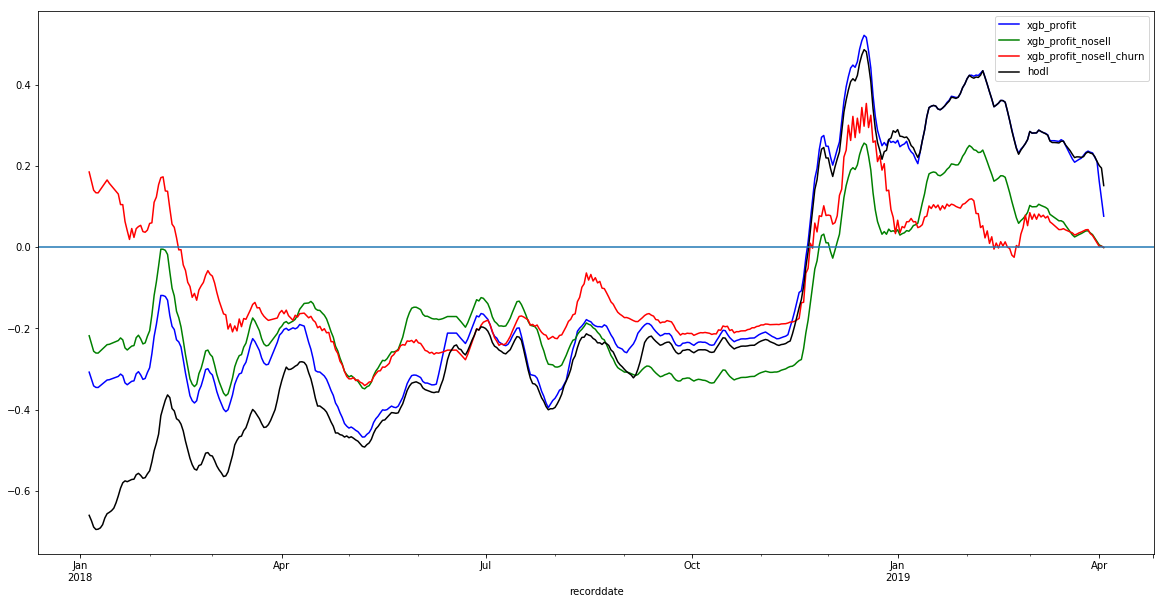

In [751]:
scen_t3 = signal_building_t(3)

              precision    recall  f1-score   support

        -1.0       0.41      0.08      0.13       145
         0.0       0.47      0.22      0.30       167
         1.0       0.34      0.83      0.49       147

   micro avg       0.37      0.37      0.37       459
   macro avg       0.41      0.37      0.30       459
weighted avg       0.41      0.37      0.30       459



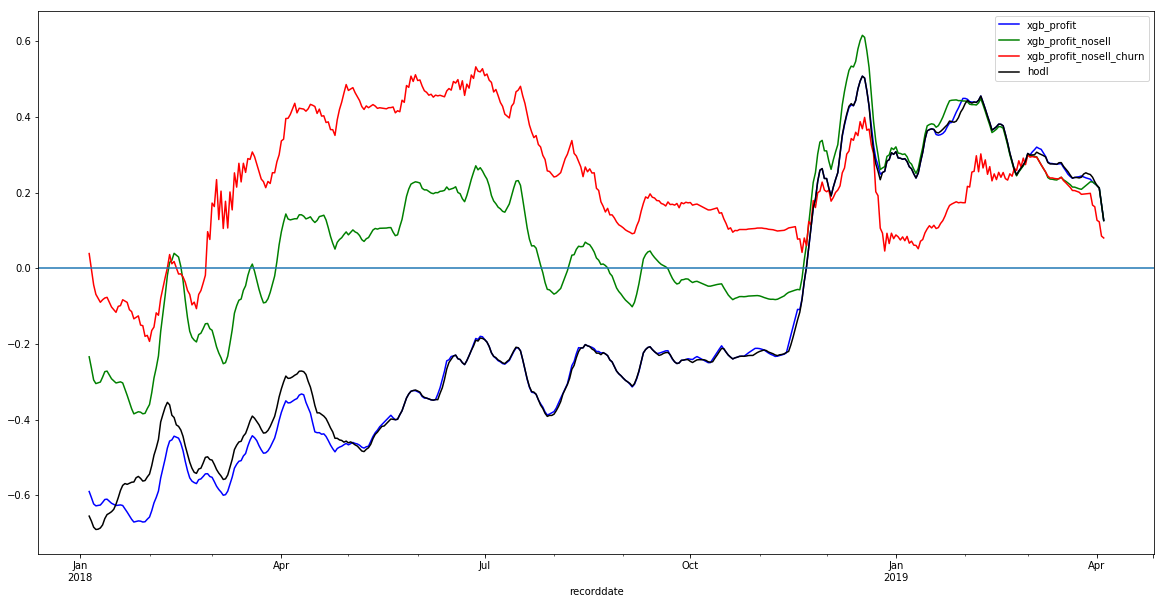

In [752]:
scen_t2 = signal_building_t(2)

              precision    recall  f1-score   support

        -1.0       0.37      0.28      0.32       145
         0.0       0.49      0.36      0.41       166
         1.0       0.33      0.53      0.41       146

   micro avg       0.39      0.39      0.39       457
   macro avg       0.40      0.39      0.38       457
weighted avg       0.40      0.39      0.38       457



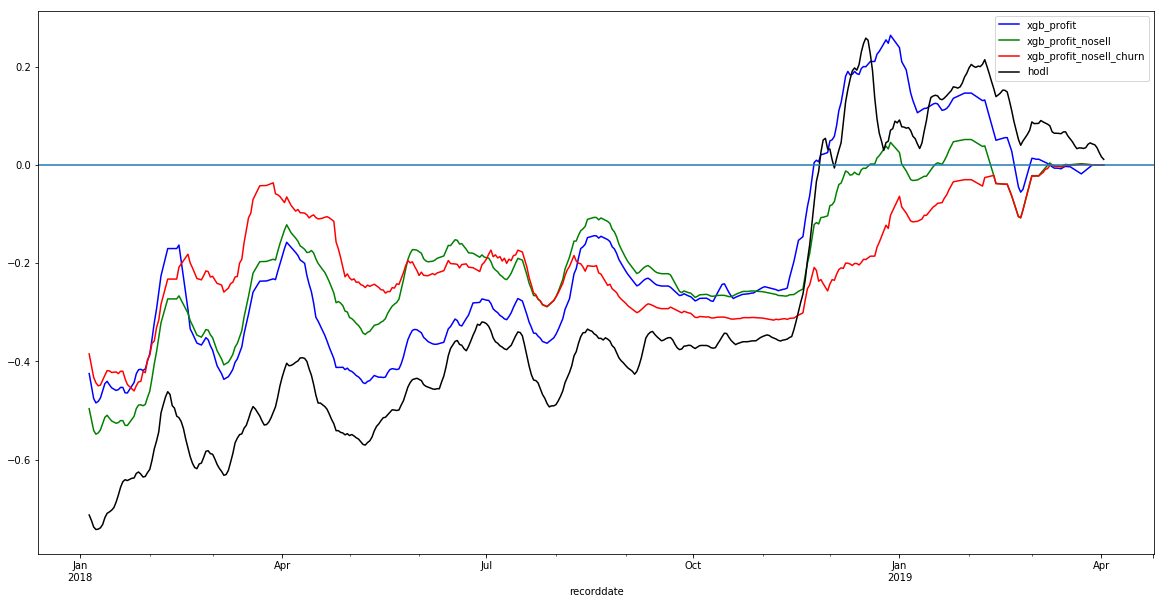

In [754]:
scen_t4 = signal_building_t(4)

              precision    recall  f1-score   support

        -1.0       0.41      0.13      0.20       145
         0.0       0.45      0.23      0.31       166
         1.0       0.31      0.70      0.43       145

   micro avg       0.35      0.35      0.35       456
   macro avg       0.39      0.36      0.31       456
weighted avg       0.40      0.35      0.31       456



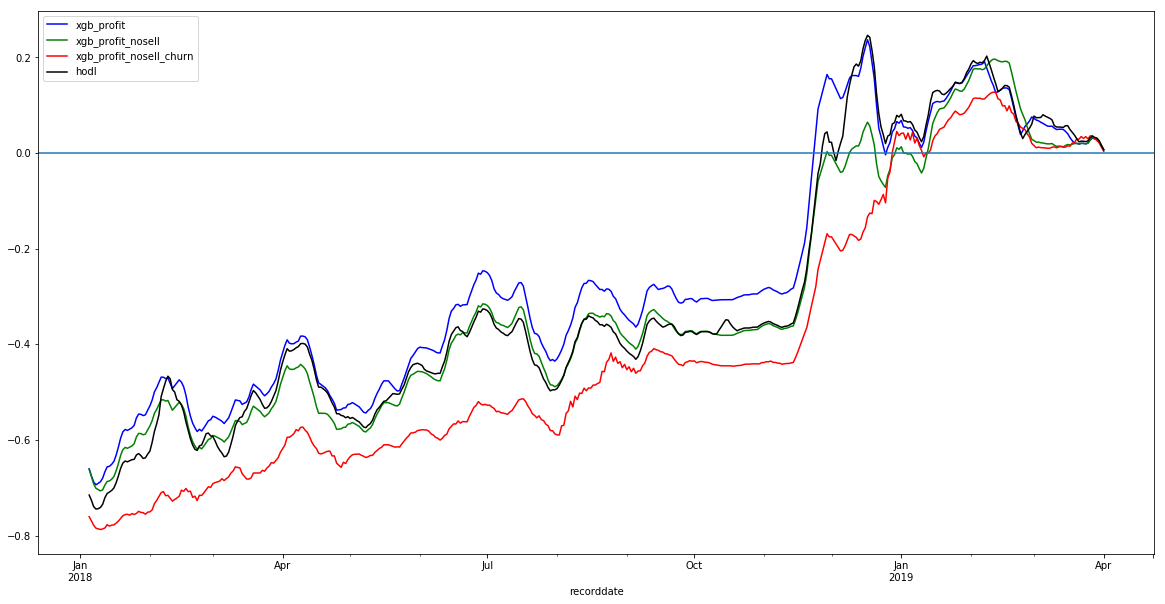

In [755]:
scen_t5 = signal_building_t(5)

In [832]:
model_clss

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [495]:
import joblib
#save model
joblib.dump(model_clss_opt, 'bitcoin_signal_model') 


['bitcoin_signal_model']

In [496]:
model = joblib.load('bitcoin_signal_model')

In [497]:
X.columns.tolist()

['high',
 'low',
 'open',
 'volumefrom',
 'volumeto',
 'intraday_range',
 'intraday_range_pct',
 'rolling_price_vol_7',
 'rolling_price_vol_30',
 'rolling_DoD_vol_7',
 'rolling_DoD_vol_30',
 'high_ETH',
 'low_ETH',
 'open_ETH',
 'volumefrom_ETH',
 'volumeto_ETH',
 'intraday_range_ETH',
 'intraday_range_pct_ETH',
 'dod_change_ETH',
 'rolling_price_vol_7_ETH',
 'rolling_price_vol_30_ETH',
 'rolling_DoD_vol_7_ETH',
 'rolling_DoD_vol_30_ETH',
 'high_LTC',
 'low_LTC',
 'open_LTC',
 'volumefrom_LTC',
 'volumeto_LTC',
 'intraday_range_LTC',
 'intraday_range_pct_LTC',
 'dod_change_LTC',
 'rolling_price_vol_7_LTC',
 'rolling_price_vol_30_LTC',
 'rolling_DoD_vol_7_LTC',
 'rolling_DoD_vol_30_LTC',
 'high_XRP',
 'low_XRP',
 'open_XRP',
 'volumefrom_XRP',
 'volumeto_XRP',
 'intraday_range_XRP',
 'intraday_range_pct_XRP',
 'dod_change_XRP',
 'rolling_price_vol_7_XRP',
 'rolling_price_vol_30_XRP',
 'rolling_DoD_vol_7_XRP',
 'rolling_DoD_vol_30_XRP',
 'high_XMR',
 'low_XMR',
 'open_XMR',
 'volumefrom_

In [837]:
model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=nan, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)